In [1]:
suppressMessages(library(cluster))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(gdata))
suppressMessages(library(ggalluvial))
suppressMessages(library(ggbeeswarm))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpointdensity))
suppressMessages(library(ggrepel))
suppressMessages(library(ggsci))
suppressMessages(library(ggthemes))
suppressMessages(library(glmnet))
suppressMessages(library(glue))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(harmony))
suppressMessages(library(irlba))
suppressMessages(library(janitor))
suppressMessages(library(lisi))
suppressMessages(library(lme4))
suppressMessages(library(magrittr))
suppressMessages(library(MASS))
suppressMessages(library(Matrix))
suppressMessages(library(matrixStats))
suppressMessages(library(monocle))
suppressMessages(library(patchwork))
suppressMessages(library(plyr))
suppressMessages(library(presto))
suppressMessages(library(purrr))
suppressMessages(library(rcna))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reticulate))
suppressMessages(library(rstatix))
suppressMessages(library(Seurat))
suppressMessages(library(stringr))
suppressMessages(library(uwot))
suppressMessages(library(viridis))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(parallel))
suppressMessages(library(scico))

suppressMessages(library('flowCore'))
suppressMessages(library('dplyr'))
suppressMessages(library('CATALYST'))
suppressMessages(library("ggplot2"))
suppressMessages(library("ggsci"))
suppressMessages(library(ggpointdensity))
suppressMessages(library(viridis))
suppressMessages(library("SingleCellExperiment"))
source("/home/jinamo@xsede.org/scripts/cytof/Seurat_functions.R")
source("/home/jinamo@xsede.org/scripts/cytof/cytofAsinh.R")
source("/home/jinamo@xsede.org/scripts/cytof/MASC.R")

FUN <- function(x, n, frac) {
    min_byFrac = as.integer(length(x)*frac)
    if (as.integer(length(x)) <= n) {
        return(x)
    } else if (as.integer(length(x)) > n & min_byFrac <= n) {
        return(x[x %in% sample(x, n)])
    } else if (as.integer(length(x)) > n & min_byFrac > n) {
        return(x[x %in% sample(x, min_byFrac)])
    }
}

# select only the metals with a marker
pregating_channels <- c('140Ce_Beads','191Ir_DNA1','193Ir_DNA2','195Pt_Viability',"Event_length")
markers <- c('AHR','CCR2','CCR7','CD127','CD14','CD16','CD20','CD25','CD27','CD3','CD39','CD4','CD40L','CD45RA','CD45RO','CD56','CD57','CD69','CD8a','CD94','CTLA4','CX3CR1','CXCR3','CXCR5','FoxP3','GrzB','GrzK','HLADR','Helios','ICOS','Ki67','NKG2D','PD1','PU.1','TACTILE','TCRVd1','TCRVd2','TIGIT','Tbet')
markers
length(markers) 
instrument_channels <- c("Time", "Event_length", "Width", 'Center', 'Offset', "Residual")


# downsampling parameters
prop=0.1
n_min=10000
# parameter for selecting variable genes
frac=0.90
# parameter for UMAP
n_neighbors=30
min_dist=0.01
resolution_list=0.7

# cluster annotation

cluster_df = read.table("/projects/jinamo@xsede.org/cytof/data/cluster_annotation.txt",sep="\t",header=TRUE) %>%
    dplyr::filter(cell=="T") %>%
    dplyr::select(-cell) %>%
    dplyr::mutate(cluster = as.character(cluster))
cluster_df

[1] "AHR"     "CCR2"    "CCR7"    "CD127"   "CD14"    "CD16"    "CD20"   
 [8] "CD25"    "CD27"    "CD3"     "CD39"    "CD4"     "CD40L"   "CD45RA" 
[15] "CD45RO"  "CD56"    "CD57"    "CD69"    "CD8a"    "CD94"    "CTLA4"  
[22] "CX3CR1"  "CXCR3"   "CXCR5"   "FoxP3"   "GrzB"    "GrzK"    "HLADR"  
[29] "Helios"  "ICOS"    "Ki67"    "NKG2D"   "PD1"     "PU.1"    "TACTILE"
[36] "TCRVd1"  "TCRVd2"  "TIGIT"   "Tbet"

[1] 39

cluster clu_name                                           
1  0       NCD4                                               
2  1       CCR2+ EMCD4                                        
3  2       CMCD4                                              
4  3       GZMB+CD57+ ECD8                                    
5  4       NCD8                                               
6  5       Th1                                                
7  6       Th2                                                
8  7       Tfh                                                
9  8       Tbet+CXCR3+GZMK+ EMCD8                             
10 9       Treg                                               
11 10      TCF1-SH2D1Alow NCD4                                
12 11      Tfh1 (CXCR5+CXCR3+ EMCD4)                          
13 12      Tbet+GZMK+CCR2+CD161+ DNT                          
14 13      cytotoxic (CD57+GZMB+Tbet+CX3CR1+) ECD4            
15 14      Tph (ICOS+ EMCD4)                                  
16 15      GZMB+GZMK+ ECD8                                    
17 16      GATA3+CCR4+ EMCD8 (Tc2)                            
18 17      cytotoxic (GZMB+Tbet+CX3CR1+) EMCD4                
19 18      TCF1+ DNT                                          
20 19      GZMB+HLA-DR+Ki67+ EMCD8                            
21 20      CD57+CD40L+ EMCD4                                  
22 21      GZMB+ TEMRA CD8+                                   
23 22      CD57highGZMBhighCD56+CX3CR1+Tbet+CXCR3+Helios+ ECD8
24 23      FOXP3+PD-1highCTLA-4+GATA3+CCR6+CD57+CD103+ DPT    
25 24      TCF1highICOS+FOXP3+GATA3+AHR+ NCD4                 
26 25      PU1+ NCD4

In [2]:
fcs_raw <- read.flowSet(path = "/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/fcs/T_cells",
                        pattern = ".fcs",
                        transformation = FALSE,
                        truncate_max_range = FALSE)

In [3]:
panel <- pData(parameters(fcs_raw[[1]]))
panel$desc <- gsub("-", "", panel$desc)
panel
sort(unique(panel$desc))

name         desc            range   minRange maxRange
$P1  Time         Time            7092018 0        7092017 
$P2  Event_length Event_length        140 0            139 
$P3  Y89Di        89Y                  17 0             16 
$P4  Pd102Di      102Pd              2221 0           2220 
$P5  Rh103Di      103Rh                15 0             14 
$P6  Pd104Di      104Pd              2206 0           2205 
$P7  Pd105Di      105Pd               281 0            280 
$P8  Pd106Di      106Pd              1635 0           1634 
$P9  Pd108Di      108Pd               163 0            162 
$P10 Pd110Di      110Pd               107 0            106 
$P11 Cd112Di      112Cd                17 0             16 
$P12 Cd113Di      CD20               8768 0           8767 
$P13 Cd114Di      114Cd                13 0             12 
$P14 In115Di      CD3                 791 0            790 
$P15 Sn120Di      120Sn              2104 0           2103 
$P16 Sb121Di      121Sb               307 0            306 
$P17 Sb123Di      123Sb               316 0            315 
$P18 I127Di       127I               1393 0           1392 
$P19 Xe131Di      131Xe                12 0             11 
$P20 Cs133Di      133Cs               290 0            289 
$P21 Ba138Di      138Ba               970 0            969 
$P22 La139Di      139La                50 0             49 
$P23 Ce140Di      140Ce_Beads        3723 0           3722 
$P24 Pr141Di      CD27                346 0            345 
$P25 Nd142Di      CD45RA              509 0            508 
$P26 Nd143Di      PD1                  80 0             79 
$P27 Nd144Di      CD39                173 0            172 
$P28 Nd145Di      CX3CR1               53 0             52 
$P29 Nd146Di      CD14                162 0            161 
$P30 Sm147Di      CD45RO             2135 0           2134 
...  ...          ...             ...     ...      ...     
$P40 Gd157Di      CD16               272  0           271  
$P41 Gd158Di      CD8a              1445  0          1444  
$P42 Tb159Di      CD57              5084  0          5083  
$P43 Gd160Di      ICOS               387  0           386  
$P44 Dy161Di      AHR              11477  0         11476  
$P45 Dy162Di      CD56               456  0           455  
$P46 Dy163Di      CCR2               125  0           124  
$P47 Dy164Di      Ki67              3264  0          3263  
$P48 Ho165Di      FoxP3             3805  0          3804  
$P49 Er166Di      CD40L              796  0           795  
$P50 Er167Di      GrzB             15330  0         15329  
$P51 Er168Di      Helios           41799  0         41798  
$P52 Tm169Di      PU.1              1843  0          1842  
$P53 Yb170Di      CD127              157  0           156  
$P54 Yb171Di      TCRVd2             740  0           739  
$P55 Yb172Di      NKG2D              100  0            99  
$P56 Yb173Di      CD25              1309  0          1308  
$P57 Yb174Di      TIGIT               72  0            71  
$P58 Lu175Di      Tbet              4582  0          4581  
$P59 Yb176Di      CCR7               139  0           138  
$P60 BCKG190Di    190BCKG             15  0            14  
$P61 Ir191Di      191Ir_DNA1        1921  0          1920  
$P62 Ir193Di      193Ir_DNA2        3341  0          3340  
$P63 Pt195Di      195Pt_Viability    853  0           852  
$P64 Pb208Di      208Pb             3341  0          3340  
$P65 Bi209Di      HLADR           106480  0        106479  
$P66 Center       Center            8888  0          8887  
$P67 Offset       Offset             521  0           520  
$P68 Width        Width              436  0           435  
$P69 Residual     Residual           897  0           896

[1] "102Pd"           "103Rh"           "104Pd"           "105Pd"          
 [5] "106Pd"           "108Pd"           "110Pd"           "112Cd"          
 [9] "114Cd"           "120Sn"           "121Sb"           "123Sb"          
[13] "127I"            "131Xe"           "133Cs"           "138Ba"          
[17] "139La"           "140Ce_Beads"     "190BCKG"         "191Ir_DNA1"     
[21] "193Ir_DNA2"      "195Pt_Viability" "208Pb"           "89Y"            
[25] "AHR"             "CCR2"            "CCR7"            "CD127"          
[29] "CD14"            "CD16"            "CD20"            "CD25"           
[33] "CD27"            "CD3"             "CD39"            "CD4"            
[37] "CD40L"           "CD45RA"          "CD45RO"          "CD56"           
[41] "CD57"            "CD69"            "CD8a"            "CD94"           
[45] "CTLA4"           "CX3CR1"          "CXCR3"           "CXCR5"          
[49] "Center"          "Event_length"    "FoxP3"           "GrzB"           
[53] "GrzK"            "HLADR"           "Helios"          "ICOS"           
[57] "Ki67"            "NKG2D"           "Offset"          "PD1"            
[61] "PU.1"            "Residual"        "TACTILE"         "TCRVd1"         
[65] "TCRVd2"          "TIGIT"           "Tbet"            "Time"           
[69] "Width"

In [4]:

set.seed(1234)
fcs <- fsApply(fcs_raw, function(x, cofactor = 5){     
  colnames(x) <- panel$desc
  expr <- exprs(x)
  expr <- asinh(expr[, c('140Ce_Beads','191Ir_DNA1','193Ir_DNA2','195Pt_Viability',markers)] / cofactor)
  exprs(x) <- expr
  x
})
 
expr <- fsApply(fcs, exprs)
dim(expr)
expr

[1] 7747813      43

140Ce_Beads  191Ir_DNA1 193Ir_DNA2 195Pt_Viability AHR         CCR2      
 [1,] 1.653259e-02 4.840201   5.457639   0.56159281      0.000000000 0.00000000
 [2,] 0.000000e+00 4.924160   5.498086   1.52494566      0.006098165 0.46835877
 [3,] 1.554312e-16 5.126319   5.590273   3.32908702      0.000000000 0.00000000
 [4,] 2.307182e-17 4.824655   5.535476   0.02565693      0.000000000 0.13098713
 [5,] 0.000000e+00 5.096148   5.687236   3.59599390      0.540235638 1.89932597
 [6,] 3.788636e-16 4.952708   5.529691   1.43896696      1.024570837 1.52634547
 [7,] 3.261172e-16 5.297093   5.909240   1.87802916      0.000000000 0.00000000
 [8,] 0.000000e+00 5.432304   5.919166   3.22733492      0.000000000 3.31947360
 [9,] 8.735918e-01 5.870904   6.460559   3.17649808      0.173922007 0.00000000
[10,] 3.750472e-16 4.824852   5.508126   0.00000000      0.931785302 0.06442661
[11,] 0.000000e+00 5.146201   5.732797   0.13761186      0.035845402 0.66640908
[12,] 3.816392e-18 5.032539   5.606204   0.11378412      0.009634170 0.90466591
[13,] 0.000000e+00 5.091801   5.690071   1.83858992      0.006911384 0.20824195
[14,] 0.000000e+00 5.105227   5.815802   2.02705028      0.893499049 0.00000000
[15,] 6.661338e-17 5.133641   5.707082   2.87858360      0.269682140 0.00000000
[16,] 1.527839e-01 5.025759   5.649094   0.99518099      0.259517422 0.76645302
[17,] 1.165734e-16 5.106096   5.660078   1.46147834      0.259412171 0.40194000
[18,] 9.103829e-16 4.899643   5.458150   0.00000000      0.099208743 0.00000000
[19,] 0.000000e+00 5.406412   5.966743   3.09138342      2.007709782 2.64514967
[20,] 0.000000e+00 5.039311   5.690930   2.09173095      0.116314699 0.00000000
[21,] 2.913859e-01 5.097831   5.812250   0.29956695      0.198108037 0.00000000
[22,] 3.335367e-16 5.039466   5.584851   0.25309923      1.717389663 1.45458980
[23,] 3.321995e-16 4.920769   5.510980   0.84723791      0.592025473 2.28473336
[24,] 1.191955e-01 5.319828   5.909224   1.32104986      0.125514105 0.00000000
[25,] 0.000000e+00 5.342964   5.871695   1.76486203      0.171197364 0.00000000
[26,] 9.801953e-02 5.194572   5.624034   1.88793839      0.294511831 0.00000000
[27,] 6.337442e-02 5.097034   5.550887   0.00000000      0.000000000 0.00000000
[28,] 0.000000e+00 4.916191   5.567592   0.04811906      0.000000000 1.60766284
[29,] 0.000000e+00 4.904807   5.511287   0.00000000      0.754202409 0.07800049
[30,] 1.559733e-16 4.826188   5.438330   1.68544628      0.000000000 0.00000000
[31,] ...          ...        ...        ...             ...         ...       
[32,] 7.547097e-03 5.019960   5.758170   1.161009873     0.193649460 0.68840829
[33,] 0.000000e+00 5.209192   5.844676   0.000000000     0.000000000 0.06289735
[34,] 0.000000e+00 5.273366   5.791754   0.069710726     0.000000000 0.00000000
[35,] 5.551115e-17 4.721143   5.347769   0.314288235     0.000000000 0.85608068
[36,] 0.000000e+00 5.175349   5.896832   0.296160273     0.880516701 0.52620953
[37,] 1.088790e-01 4.895814   5.610596   0.000000000     0.000000000 0.00000000
[38,] 1.372875e-01 4.838783   5.457242   0.000000000     0.098252621 0.03922330
[39,] 9.830428e-02 5.112293   5.603769   0.387406092     0.338022060 0.00000000
[40,] 1.826213e-01 5.132888   5.780374   0.538723564     0.272198006 1.65572668
[41,] 0.000000e+00 5.520096   6.127469   0.000000000     0.172359055 0.00000000
[42,] 9.367507e-17 5.267470   5.940682   0.395148471     0.559606785 1.70026468
[43,] 2.734691e-01 5.207032   5.873596   1.173492793     0.646316558 1.04993493
[44,] 6.513040e+00 5.284088   5.874374   0.008503232     0.000000000 0.36356660
[45,] 0.000000e+00 5.090397   5.747847   0.437714746     0.474300877 0.36735686
[46,] 0.000000e+00 4.852832   5.493169   0.367057813     0.000000000 0.00000000
[47,] 7.434374e-17 4.889829   5.496727   0.149522377     0.151797603 0.00000000
[48,] 0.000000e+00 4.763372   5.450717   0.000000000     0.508427002 0.00000000
[49,] 0.000000e+00 5.116571   5.698626   0.160619276     0.008883976 0.05314850
[50,] 

In [5]:
fsApply(fcs_raw, nrow)
dim(fsApply(fcs_raw, nrow))

[,1]  
01-128-99.fcs   75719
01-209-01.fcs   25478
01-781-00.fcs   51378
01-953-00.fcs   30365
01-959-00.fcs  132594
01-970-00.fcs   59225
012027-2.fcs    42868
09-066-00.fcs   31010
09-079-00.fcs  114004
09-113-00.fcs  105667
09-121-00.fcs   44127
10000314.fcs    91481
10000317.fcs   119003
10000318.fcs    93330
10000319.fcs   116092
10000325.fcs    97518
10000328.fcs    69011
10000332.fcs    92650
10000334.fcs   106675
10000336.fcs    73538
10000338.fcs   104088
10000339.fcs    63877
10000340.fcs    54378
10014071.fcs    78026
10021023.fcs    53411
10038223.fcs   112627
10039927.fcs   102689
10041754.fcs    92903
10055724.fcs    94589
111678.fcs     126337
...            ...   
P048.fcs        40646
P084.fcs        50866
SR0024.fcs      85588
SR0025.fcs     116382
SR0028.fcs      44249
SR0029.fcs     109207
SR0030.fcs      95723
SR0031.fcs      82724
SR0032.fcs      99188
SR0033.fcs      86895
SR0039.fcs     104901
SR0048.fcs      87652
SR0052.fcs      37403
SR0068.fcs      44282
SR0078.fcs      62246
SR0080.fcs     103970
SR0083.fcs      71929
SR0085.fcs     101171
SR0090.fcs     110396
SR0094.fcs      66875
SR0095.fcs      83278
SR0096.fcs      88706
SR010400.fcs    92544
SR010661.fcs   108832
SR010771.fcs    93103
SR010939.fcs   121098
SR011075.fcs   112258
SR011104.fcs    39040
SR011159.fcs    42316
normal_845.fcs  57742

[1] 100   1

In [6]:
meta = read.table("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/ValiData_meta.txt",sep="\t",header=TRUE) %>%
    dplyr::mutate(subject_id_tmp = paste0(subject_id,".fcs"),
                  subject_id_tmp = factor(subject_id_tmp,levels = names(fsApply(fcs_raw, nrow)[,1]))) %>%
    dplyr::arrange(subject_id_tmp) %>%
    dplyr::select(-subject_id_tmp)


In [7]:
sample_ids <- rep(meta$subject_id, fsApply(fcs_raw, nrow))
rownames(expr) <- sample_ids
dim(expr)
expr[1:5,1:5]

[1] 7747813      43

140Ce_Beads  191Ir_DNA1 193Ir_DNA2 195Pt_Viability AHR        
01-128-99 1.653259e-02 4.840201   5.457639   0.56159281      0.000000000
01-128-99 0.000000e+00 4.924160   5.498086   1.52494566      0.006098165
01-128-99 1.554312e-16 5.126319   5.590273   3.32908702      0.000000000
01-128-99 2.307182e-17 4.824655   5.535476   0.02565693      0.000000000
01-128-99 0.000000e+00 5.096148   5.687236   3.59599390      0.540235638

In [8]:
n_cell=1e03
ds_prop=0.1

set.seed(1234)
logi = unlist(lapply(split(1:nrow(expr), rownames(expr)), FUN, n = n_cell, frac = ds_prop))


In [9]:
meta_df = as.data.frame(expr) %>%
     dplyr::mutate(subject_id = sample_ids) %>%
     merge(.,meta,by="subject_id") %>%
     .[,c("subject_id","batch","group","CCP","age","sex")]

In [10]:
exp_test <- as.data.frame(expr)[logi, ]
head(exp_test)
meta_df_test = meta_df[logi, ]
head(meta_df_test)
nrow(exp_test)==nrow(meta_df_test)

140Ce_Beads  191Ir_DNA1 193Ir_DNA2 195Pt_Viability AHR      
X01.128.99.24  0.000000e+00 5.342964   5.871695   1.76486203      0.1711974
X01.128.99.52  0.000000e+00 4.970097   5.631951   0.87972830      2.3058494
X01.128.99.80  1.841409e-16 5.212312   5.740142   3.39083632      0.0000000
X01.128.99.129 1.538134e-01 5.240364   5.852517   1.09778276      0.9706126
X01.128.99.140 0.000000e+00 5.828002   6.381640   0.05120442      0.1956759
X01.128.99.143 1.434454e-16 5.418785   5.907280   1.53365716      1.2073673
               CCR2      CCR7      CD127      CD14      CD16       ...
X01.128.99.24  0.0000000 2.0130823 0.66849264 0.0000000 0.08412806 ...
X01.128.99.52  0.9824586 0.0000000 0.08408128 0.8128208 0.06737141 ...
X01.128.99.80  1.4996627 0.6018169 0.49881583 0.2002228 0.00000000 ...
X01.128.99.129 1.4899760 0.1582607 0.32989551 1.8834368 0.03100738 ...
X01.128.99.140 0.6869478 0.1864935 0.00000000 1.8501764 0.00000000 ...
X01.128.99.143 1.0757671 0.7028008 0.00000000 1.3394029 0.00000000 ...
               ICOS        Ki67     NKG2D     PD1          PU.1      TACTILE  
X01.128.99.24  0.000000000 0.000000 1.1579278 1.728813e-01 0.4574280 0.1370632
X01.128.99.52  0.000000000 1.107134 0.0000000 0.000000e+00 3.6137279 0.0000000
X01.128.99.80  0.005657075 0.000000 1.0090790 0.000000e+00 0.1739750 0.1665875
X01.128.99.129 0.000000000 3.426715 0.0000000 1.156773e-05 3.0171500 0.0000000
X01.128.99.140 0.043522058 0.000000 0.0000000 0.000000e+00 0.1117284 0.0000000
X01.128.99.143 0.052072824 3.676647 0.1310448 0.000000e+00 2.6795629 0.1705431
               TCRVd1       TCRVd2      TIGIT      Tbet        
X01.128.99.24  0.000000e+00 0.000000000 1.49138423 0.000000e+00
X01.128.99.52  0.000000e+00 0.000000000 0.00000000 0.000000e+00
X01.128.99.80  0.000000e+00 4.230519529 0.08360414 4.324474e-01
X01.128.99.129 0.000000e+00 0.000000000 0.00000000 1.391961e-09
X01.128.99.140 8.586881e-18 0.004356173 0.00000000 2.027269e-09
X01.128.99.143 0.000000e+00 0.000000000 0.00000000 1.208201e-02

subject_id batch      group  CCP      age sex 
25  01-128-99  Colorado 2 CCP(+) Positive 74  Male
53  01-128-99  Colorado 2 CCP(+) Positive 74  Male
81  01-128-99  Colorado 2 CCP(+) Positive 74  Male
130 01-128-99  Colorado 2 CCP(+) Positive 74  Male
141 01-128-99  Colorado 2 CCP(+) Positive 74  Male
144 01-128-99  Colorado 2 CCP(+) Positive 74  Male

[1] TRUE

geom_pointdensity using method='kde2d' due to large number of points (>20k)



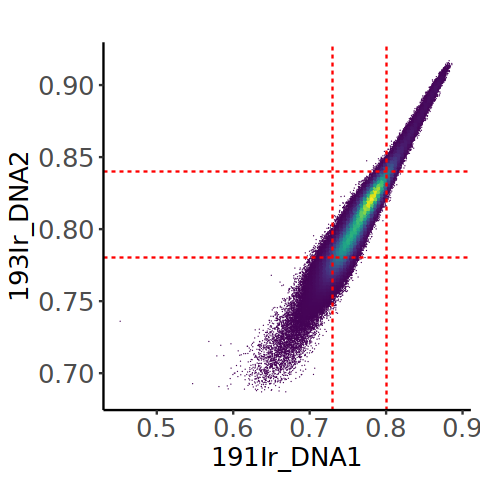

In [11]:
marker1="191Ir_DNA1"
marker2="193Ir_DNA2"
marker1_cut_low=0.73
marker1_cut_up=0.8
marker2_cut_low=0.78
marker2_cut_up=0.84
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(data = exp_test, mapping = aes(x = log10(exp_test[,marker1]+1), y = log10(exp_test[,marker2]+1))) +
      geom_pointdensity(size = 0.1, stroke = 0, shape = 16) +
      scale_color_viridis() +
      geom_vline(xintercept=log10(10^marker1_cut_low), linetype='dashed', color=c('red')) +
      geom_vline(xintercept=log10(10^marker1_cut_up), linetype='dashed', color=c('red')) +
      geom_hline(yintercept=log10(10^marker2_cut_low), linetype='dashed', color=c('red')) +
      geom_hline(yintercept=log10(10^marker2_cut_up), linetype='dashed', color=c('red')) +
      xlim(min(log10(expr[,marker1]+1)),max(log10(expr[,marker1]+1))) +
      ylim(min(log10(expr[,marker2]+1)),max(log10(expr[,marker2]+1))) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "none",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_text(size = 15),
            legend.text =  element_text(size = 15),
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
      labs(title = "",
           x = paste(marker1),
           y = paste(marker2)) 


[1] "Colorado 2"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



[1] "Colorado & BWH"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



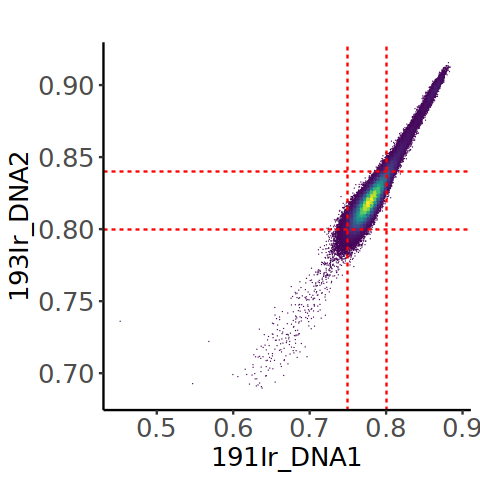

[1] "BWH 1"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



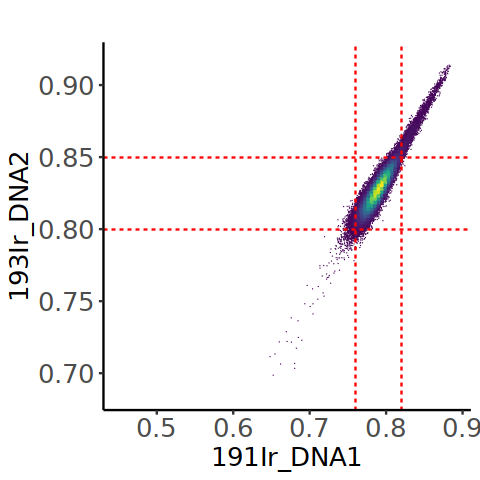

[1] "BWH 2"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



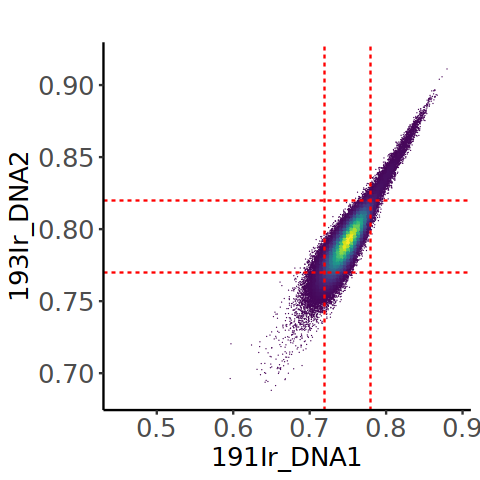

[1] "Colorado 1"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



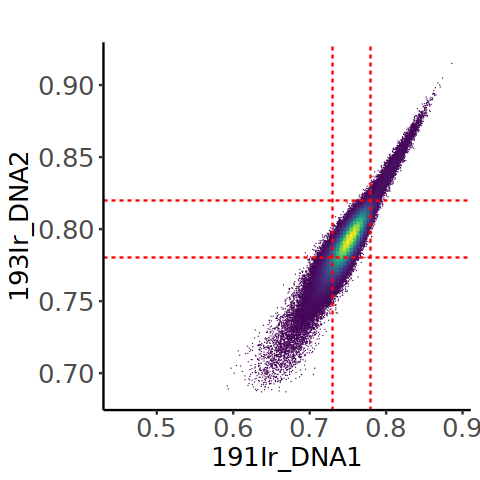

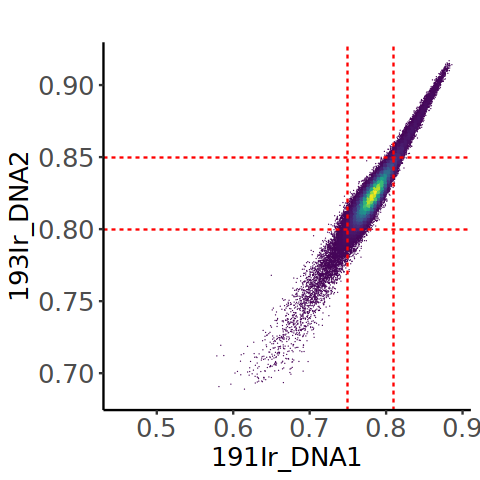

In [12]:
options(repr.plot.height = 4, repr.plot.width = 4)
for(b in unique(meta_df_test$batch)){
  print(b)
  if(b=='Colorado 2'){
    marker1_cut_low=0.75
    marker1_cut_up=0.8
    marker2_cut_low=0.8
    marker2_cut_up=0.84
  } else if(b=='Colorado 1'){
    marker1_cut_low=0.75
    marker1_cut_up=0.81
    marker2_cut_low=0.8
    marker2_cut_up=0.85
  } else if(b=='Colorado & BWH'){
    marker1_cut_low=0.76
    marker1_cut_up=0.82
    marker2_cut_low=0.8
    marker2_cut_up=0.85
  } else if(b=='BWH 1'){
    marker1_cut_low=0.72
    marker1_cut_up=0.78
    marker2_cut_low=0.77
    marker2_cut_up=0.82
  } else if(b=='BWH 2'){
    marker1_cut_low=0.73
    marker1_cut_up=0.78
    marker2_cut_low=0.78
    marker2_cut_up=0.82
  }
  
  plot(as.data.frame(exp_test) %>%
         dplyr::mutate(batch = meta_df_test$batch) %>%
         dplyr::filter(batch == b) %>%
         ggplot(data = ., mapping = aes(x = log10(.[,marker1]+1), y = log10(.[,marker2]+1))) +
         geom_pointdensity(size = 0.1, stroke = 0, shape = 16) +
         scale_color_viridis() +
         geom_vline(xintercept=log10(10^marker1_cut_low), linetype='dashed', color=c('red')) +
         geom_vline(xintercept=log10(10^marker1_cut_up), linetype='dashed', color=c('red')) +
         geom_hline(yintercept=log10(10^marker2_cut_low), linetype='dashed', color=c('red')) +
         geom_hline(yintercept=log10(10^marker2_cut_up), linetype='dashed', color=c('red')) +
         xlim(min(log10(expr[,marker1]+1)),max(log10(expr[,marker1]+1))) +
         ylim(min(log10(expr[,marker2]+1)),max(log10(expr[,marker2]+1))) +
         theme_classic() +
         theme(strip.text.x=element_text(size=15, color="black", face="bold"),
               strip.text.y=element_text(size=15, color="black", face="bold"),
               legend.position = "none",
               plot.title = element_text(size=15),
               axis.title.x = element_text(size=15),
               axis.title.y = element_text(size =15),
               axis.text.y = element_text(size = 15),
               axis.text.x = element_text(size = 15),
               legend.text =  element_text(size = 15),
               legend.key.size = grid::unit(0.8, "lines"),
               legend.title = element_text(size = 0, hjust = 0)) +
         labs(title = "",
              x = paste(marker1),
              y = paste(marker2)))
}


In [13]:
for(b in unique(meta_df_test$batch)){
  print(b)
  if(b=='Colorado 2'){
    marker1_cut_low=0.75
    marker1_cut_up=0.8
    marker2_cut_low=0.8
    marker2_cut_up=0.84
  } else if(b=='Colorado 1'){
    marker1_cut_low=0.75
    marker1_cut_up=0.81
    marker2_cut_low=0.8
    marker2_cut_up=0.85
  } else if(b=='Colorado & BWH'){
    marker1_cut_low=0.76
    marker1_cut_up=0.82
    marker2_cut_low=0.8
    marker2_cut_up=0.85
  } else if(b=='BWH 1'){
    marker1_cut_low=0.72
    marker1_cut_up=0.78
    marker2_cut_low=0.77
    marker2_cut_up=0.82
  } else if(b=='BWH 2'){
    marker1_cut_low=0.73
    marker1_cut_up=0.78
    marker2_cut_low=0.78
    marker2_cut_up=0.82
  }
  
  if(b==unique(meta_df_test$batch)[1]){
    tmp = as.data.frame(exp_test) %>%
      dplyr::mutate(batch = meta_df_test$batch) %>%
      dplyr::filter(batch == b) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)>marker1_cut_low) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)<marker1_cut_up) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)>marker2_cut_low) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)<marker2_cut_up)
  } else {
    tmp = as.data.frame(exp_test) %>%
      dplyr::mutate(batch = meta_df_test$batch) %>%
      dplyr::filter(batch == b) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)>marker1_cut_low) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)<marker1_cut_up) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)>marker2_cut_low) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)<marker2_cut_up) %>%
      rbind(.,tmp)
  }
}
exp_test = tmp

[1] "Colorado 2"
[1] "Colorado & BWH"
[1] "BWH 1"
[1] "BWH 2"
[1] "Colorado 1"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



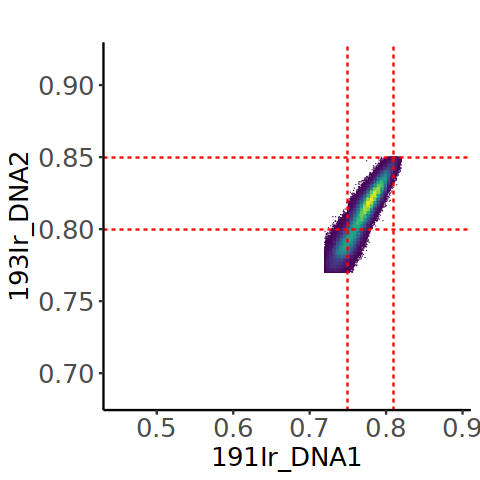

In [14]:

ggplot(data = exp_test, mapping = aes(x = log10(exp_test[,marker1]+1), y = log10(exp_test[,marker2]+1))) +
      geom_pointdensity(size = 0.1, stroke = 0, shape = 16) +
      scale_color_viridis() +
      geom_vline(xintercept=log10(10^marker1_cut_low), linetype='dashed', color=c('red')) +
      geom_vline(xintercept=log10(10^marker1_cut_up), linetype='dashed', color=c('red')) +
      geom_hline(yintercept=log10(10^marker2_cut_low), linetype='dashed', color=c('red')) +
      geom_hline(yintercept=log10(10^marker2_cut_up), linetype='dashed', color=c('red')) +
      xlim(min(log10(expr[,marker1]+1)),max(log10(expr[,marker1]+1))) +
      ylim(min(log10(expr[,marker2]+1)),max(log10(expr[,marker2]+1))) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "none",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_text(size = 15),
            legend.text =  element_text(size = 15),
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
      labs(title = "",
           x = paste(marker1),
           y = paste(marker2)) 

In [15]:
expr %<>%
     as.data.frame() %>%
     dplyr::mutate(subject_id = sample_ids) %>%
     merge(.,meta,by="subject_id")


In [16]:
bf = nrow(expr)

for(b in unique(meta_df$batch)){
  print(b)
  if(b=='Colorado 2'){
    marker1_cut_low=0.75
    marker1_cut_up=0.8
    marker2_cut_low=0.8
    marker2_cut_up=0.84
  } else if(b=='Colorado 1'){
    marker1_cut_low=0.75
    marker1_cut_up=0.81
    marker2_cut_low=0.8
    marker2_cut_up=0.85
  } else if(b=='Colorado & BWH'){
    marker1_cut_low=0.76
    marker1_cut_up=0.82
    marker2_cut_low=0.8
    marker2_cut_up=0.85
  } else if(b=='BWH 1'){
    marker1_cut_low=0.72
    marker1_cut_up=0.78
    marker2_cut_low=0.77
    marker2_cut_up=0.82
  } else if(b=='BWH 2'){
    marker1_cut_low=0.73
    marker1_cut_up=0.78
    marker2_cut_low=0.78
    marker2_cut_up=0.82
  }
  
  if(b==unique(meta_df$batch)[1]){
    tmp = expr %>%
      dplyr::filter(batch == b) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)>marker1_cut_low) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)<marker1_cut_up) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)>marker2_cut_low) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)<marker2_cut_up)
  } else {
    tmp = expr %>%
      dplyr::filter(batch == b) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)>marker1_cut_low) %>%
      dplyr::filter(log10(`191Ir_DNA1`+1)<marker1_cut_up) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)>marker2_cut_low) %>%
      dplyr::filter(log10(`193Ir_DNA2`+1)<marker2_cut_up) %>%
      rbind(.,tmp)
  }
}
expr = tmp
100*nrow(expr)/bf

[1] "Colorado 2"
[1] "Colorado & BWH"
[1] "BWH 1"
[1] "BWH 2"
[1] "Colorado 1"


[1] 82.29364

geom_pointdensity using method='kde2d' due to large number of points (>20k)



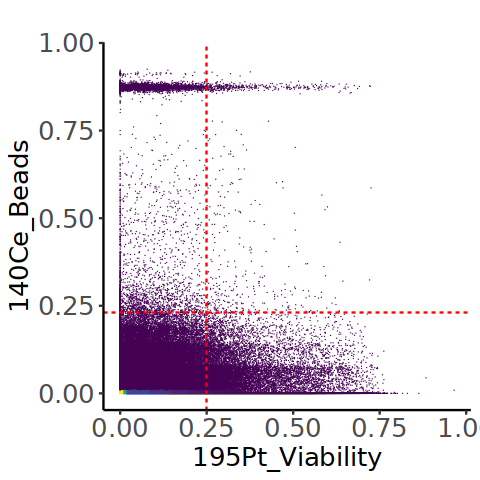

In [17]:
marker1='195Pt_Viability'
marker2='140Ce_Beads'
marker1_cut=0.25
marker2_cut=0.23
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(data = exp_test, mapping = aes(x = log10(exp_test[,marker1]+1), y = log10(exp_test[,marker2]+1))) +
      geom_pointdensity(size = 0.1, stroke = 0, shape = 16) +
      scale_color_viridis() +
      geom_hline(yintercept=log10(10^marker2_cut), linetype='dashed', color=c('red')) +
      geom_vline(xintercept=log10(10^marker1_cut), linetype='dashed', color=c('red')) +
      xlim(min(log10(expr[,marker1]+1)),max(log10(expr[,marker1]+1))) +
      ylim(min(log10(expr[,marker2]+1)),max(log10(expr[,marker2]+1))) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "none",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_text(size = 15),
            legend.text =  element_text(size = 15),
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
      labs(title = "",
           x = paste(marker1),
           y = paste(marker2)) 

[1] "Colorado 2"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



[1] "Colorado & BWH"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



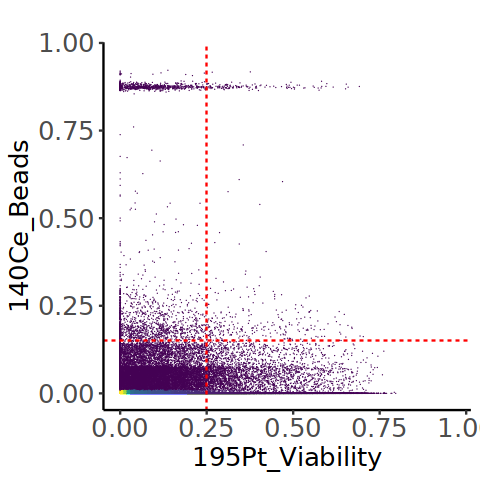

[1] "BWH 1"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



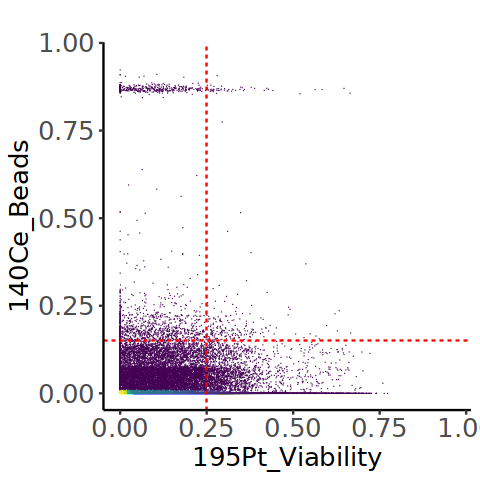

[1] "BWH 2"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



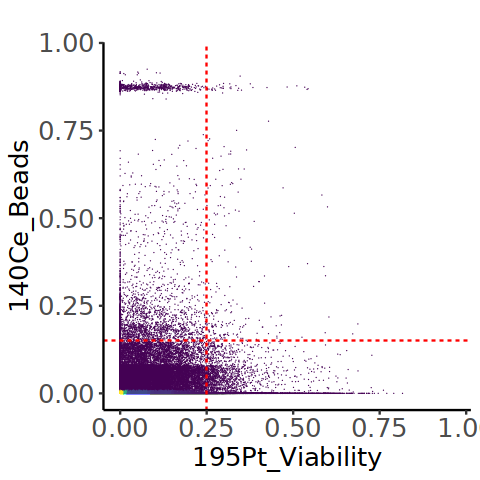

[1] "Colorado 1"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



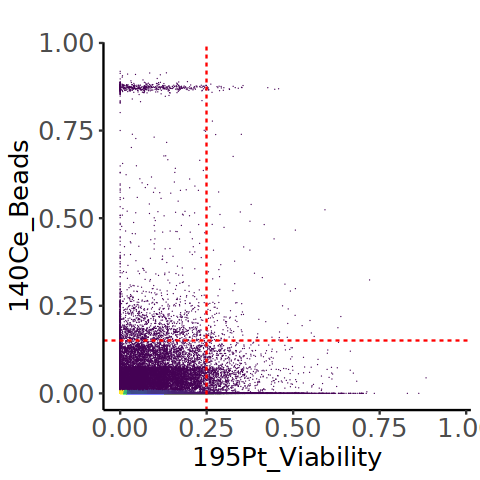

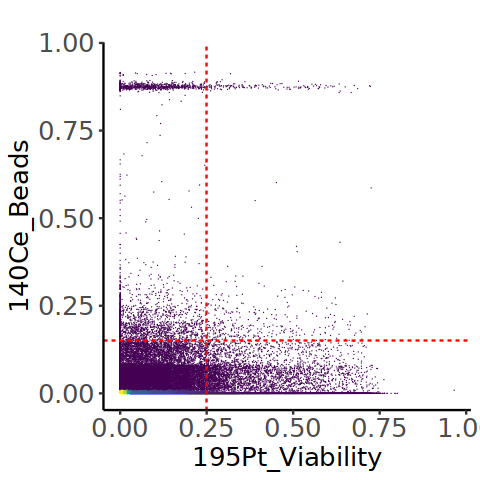

In [18]:
for(b in unique(meta_df_test$batch)){
  print(b)
  if(b=='Colorado 2'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='Colorado 1'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='Colorado & BWH'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='BWH 1'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='BWH 2'){
    marker1_cut=0.25
    marker2_cut=0.15
  }
  
  plot(as.data.frame(exp_test) %>%
         dplyr::filter(batch == b) %>%
         ggplot(data = ., mapping = aes(x = log10(.[,marker1]+1), y = log10(.[,marker2]+1))) +
         geom_pointdensity(size = 0.1, stroke = 0, shape = 16) +
         scale_color_viridis() +
         geom_hline(yintercept=log10(10^marker2_cut), linetype='dashed', color=c('red')) +
         geom_vline(xintercept=log10(10^marker1_cut), linetype='dashed', color=c('red')) +
         xlim(min(log10(expr[,marker1]+1)),max(log10(expr[,marker1]+1))) +
         ylim(min(log10(expr[,marker2]+1)),max(log10(expr[,marker2]+1))) +
         theme_classic() +
         theme(strip.text.x=element_text(size=15, color="black", face="bold"),
               strip.text.y=element_text(size=15, color="black", face="bold"),
               legend.position = "none",
               plot.title = element_text(size=15),
               axis.title.x = element_text(size=15),
               axis.title.y = element_text(size =15),
               axis.text.y = element_text(size = 15),
               axis.text.x = element_text(size = 15),
               legend.text =  element_text(size = 15),
               legend.key.size = grid::unit(0.8, "lines"),
               legend.title = element_text(size = 0, hjust = 0)) +
         labs(title = "",
              x = paste(marker1),
              y = paste(marker2)))
}

In [19]:
for(b in unique(meta_df_test$batch)){
  print(b)
  if(b=='Colorado 2'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='Colorado 1'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='Colorado & BWH'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='BWH 1'){
    marker1_cut=0.25
    marker2_cut=0.15
  } else if(b=='BWH 2'){
    marker1_cut=0.25
    marker2_cut=0.15
  }
  
  if(b==unique(meta_df_test$batch)[1]){
    tmp = as.data.frame(exp_test) %>%
      dplyr::filter(batch == b) %>%
      dplyr::filter(log10(`195Pt_Viability`+1)<marker1_cut) %>%
      dplyr::filter(log10(`140Ce_Beads`+1)<marker2_cut)
  } else {
    tmp = as.data.frame(exp_test) %>%
      dplyr::filter(batch == b) %>%
      dplyr::filter(log10(`195Pt_Viability`+1)<marker1_cut) %>%
      dplyr::filter(log10(`140Ce_Beads`+1)<marker2_cut) %>%
      rbind(.,tmp)
  }
}
exp_test = tmp

[1] "Colorado 2"
[1] "Colorado & BWH"
[1] "BWH 1"
[1] "BWH 2"
[1] "Colorado 1"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



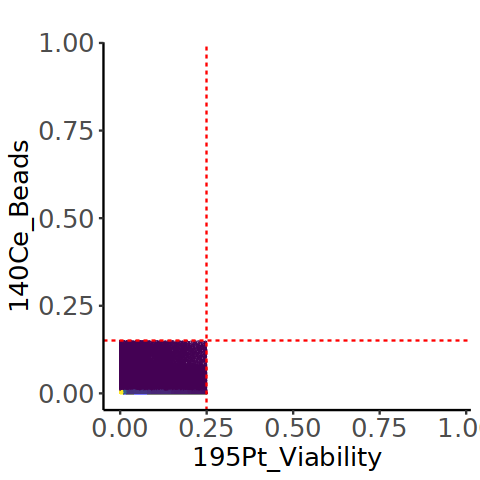

In [20]:
ggplot(data = exp_test, mapping = aes(x = log10(exp_test[,marker1]+1), y = log10(exp_test[,marker2]+1))) +
      geom_pointdensity(size = 0.1, stroke = 0, shape = 16) +
      scale_color_viridis() +
      geom_hline(yintercept=log10(10^marker2_cut), linetype='dashed', color=c('red')) +
      geom_vline(xintercept=log10(10^marker1_cut), linetype='dashed', color=c('red')) +
      xlim(min(log10(expr[,marker1]+1)),max(log10(expr[,marker1]+1))) +
      ylim(min(log10(expr[,marker2]+1)),max(log10(expr[,marker2]+1))) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "none",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_text(size = 15),
            legend.text =  element_text(size = 15),
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
      labs(title = "",
           x = paste(marker1),
           y = paste(marker2)) 

In [21]:
bf = nrow(expr)
expr %<>%
     as.data.frame() %>%
     dplyr::filter(log10(`195Pt_Viability`+1)<marker1_cut) %>%
     dplyr::filter(log10(`140Ce_Beads`+1)<marker2_cut)

100*nrow(expr)/bf

[1] 88.77522

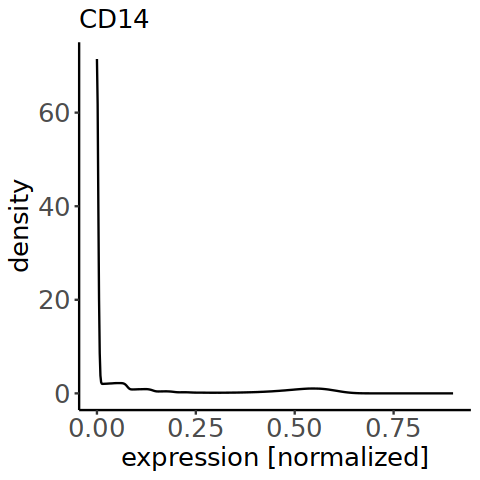

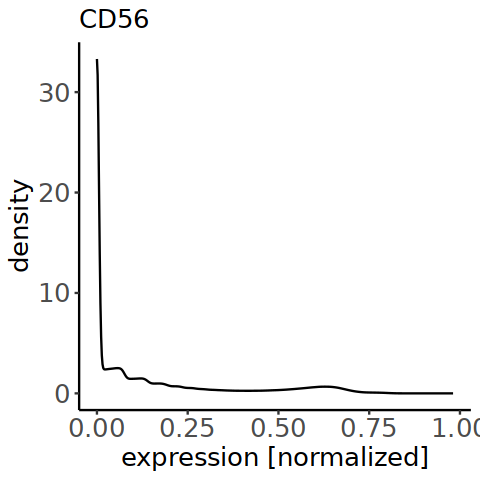

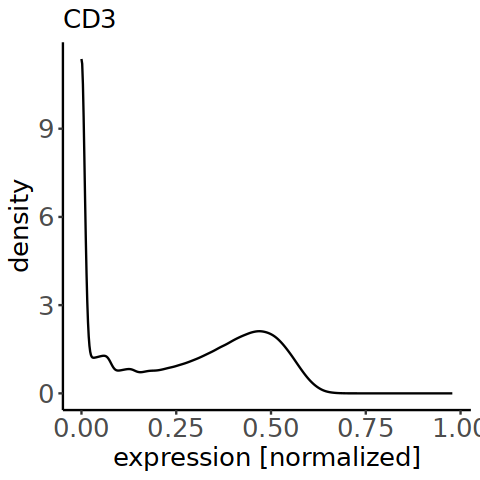

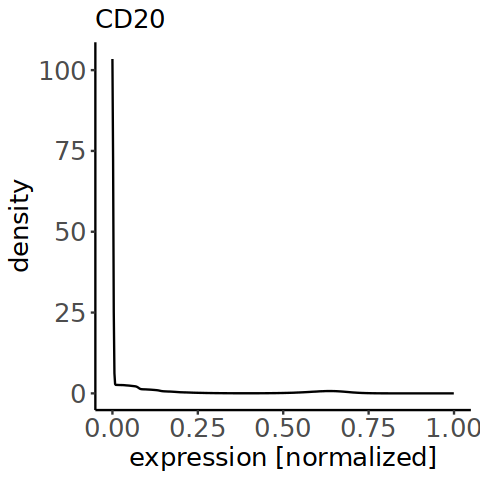

In [22]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(as.data.frame(expr), aes(x=log10(as.data.frame(expr)$CD14+1))) + 
                geom_density() +
                theme_classic() +
                theme(strip.text.x=element_text(size=15, color="black", face="bold"),
                      strip.text.y=element_text(size=15, color="black", face="bold"),
                      legend.position = "right",
                      plot.title = element_text(size=15),
                      axis.title.x = element_text(size=15),
                      axis.title.y = element_text(size =15),
                      axis.text.y = element_text(size = 15),
                      axis.text.x = element_text(size = 15),
                    legend.text =  element_text(size = 15),
                    legend.key.size = grid::unit(0.5, "lines"),
                    legend.title = element_text(size = 0.8, hjust = 0)) +
              labs(title = "CD14",
                   x = "expression [normalized]",
                   y = "density") 

ggplot(as.data.frame(expr), aes(x=log10(as.data.frame(expr)$CD56+1))) + 
                geom_density() +
                theme_classic() +
                theme(strip.text.x=element_text(size=15, color="black", face="bold"),
                      strip.text.y=element_text(size=15, color="black", face="bold"),
                      legend.position = "right",
                      plot.title = element_text(size=15),
                      axis.title.x = element_text(size=15),
                      axis.title.y = element_text(size =15),
                      axis.text.y = element_text(size = 15),
                      axis.text.x = element_text(size = 15),
                    legend.text =  element_text(size = 15),
                    legend.key.size = grid::unit(0.5, "lines"),
                    legend.title = element_text(size = 0.8, hjust = 0)) +
              labs(title = "CD56",
                   x = "expression [normalized]",
                   y = "density") 

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(as.data.frame(expr), aes(x=log10(as.data.frame(expr)$CD3+1))) + 
                geom_density() +
                theme_classic() +
                theme(strip.text.x=element_text(size=15, color="black", face="bold"),
                      strip.text.y=element_text(size=15, color="black", face="bold"),
                      legend.position = "right",
                      plot.title = element_text(size=15),
                      axis.title.x = element_text(size=15),
                      axis.title.y = element_text(size =15),
                      axis.text.y = element_text(size = 15),
                      axis.text.x = element_text(size = 15),
                    legend.text =  element_text(size = 15),
                    legend.key.size = grid::unit(0.5, "lines"),
                    legend.title = element_text(size = 0.8, hjust = 0)) +
              labs(title = "CD3",
                   x = "expression [normalized]",
                   y = "density") 

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(as.data.frame(expr), aes(x=log10(as.data.frame(expr)$CD20+1))) + 
                geom_density() +
                theme_classic() +
                theme(strip.text.x=element_text(size=15, color="black", face="bold"),
                      strip.text.y=element_text(size=15, color="black", face="bold"),
                      legend.position = "right",
                      plot.title = element_text(size=15),
                      axis.title.x = element_text(size=15),
                      axis.title.y = element_text(size =15),
                      axis.text.y = element_text(size = 15),
                      axis.text.x = element_text(size = 15),
                    legend.text =  element_text(size = 15),
                    legend.key.size = grid::unit(0.5, "lines"),
                    legend.title = element_text(size = 0.8, hjust = 0)) +
              labs(title = "CD20",
                   x = "expression [normalized]",
                   y = "density") 

geom_pointdensity using method='kde2d' due to large number of points (>20k)

geom_pointdensity using method='kde2d' due to large number of points (>20k)



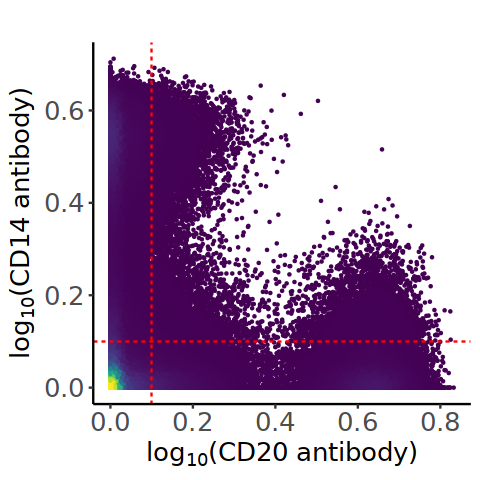

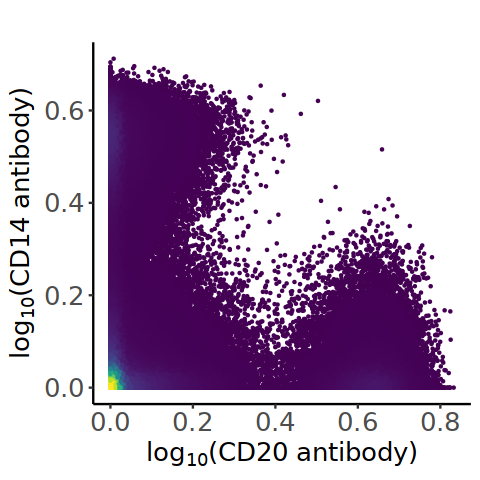

In [23]:
# manual gating T cells by CD3+CD20-CD14-CD56-


options(repr.plot.height = 4, repr.plot.width = 4)
thresh_t = 0.25
thresh_b = 0.1
thresh_nk = 0.1
thresh_m = 0.1
xmin = 0
ymin = 0
xmax = log10(max(exp_test$CD20)+1)
ymax = log10(max(exp_test$CD14)+1)

# remove B cells and myeloid
ggplot(data = exp_test, mapping = aes(x = log10(CD20+1), y = log10(CD14+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16, adjust = 4) +
  scale_color_viridis() +
  geom_hline(yintercept=log10(10^thresh_m), linetype='dashed', color=c('red')) +
  geom_vline(xintercept=log10(10^thresh_b), linetype='dashed', color=c('red')) +
  scale_x_continuous(limits = c(xmin,xmax)) +
  scale_y_continuous(limits = c(ymin,ymax)) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD20 antibody)")),
       y = bquote(paste(log[10], "(CD14 antibody)"))) 

ggplot(data = exp_test, mapping = aes(x = log10(CD20+1), y = log10(CD14+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16, adjust = 4) +
  scale_color_viridis() +
  # geom_hline(yintercept=log10(10^thresh_m), linetype='dashed', color=c('red')) +
  # geom_vline(xintercept=log10(10^thresh_b), linetype='dashed', color=c('red')) +
  scale_x_continuous(limits = c(xmin,xmax)) +
  scale_y_continuous(limits = c(ymin,ymax)) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD20 antibody)")),
       y = bquote(paste(log[10], "(CD14 antibody)"))) 


In [24]:
bf = nrow(expr)
expr %<>%
     as.data.frame() %>%
     dplyr::filter(log10(`CD20`+1)<thresh_b) %>%
     dplyr::filter(log10(`CD14`+1)<thresh_m)
nrow(expr)
100*nrow(expr)/bf

[1] 3234356

[1] 57.14137

geom_pointdensity using method='kde2d' due to large number of points (>20k)

Warning message:
“Removed 34 rows containing missing values (`stat_pointdensity()`).”
geom_pointdensity using method='kde2d' due to large number of points (>20k)

Warning message:
“Removed 34 rows containing missing values (`stat_pointdensity()`).”


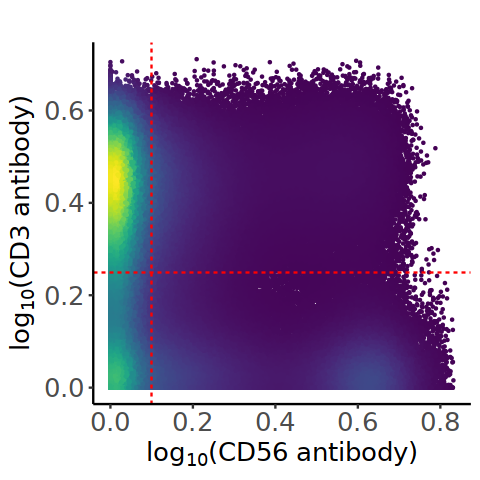

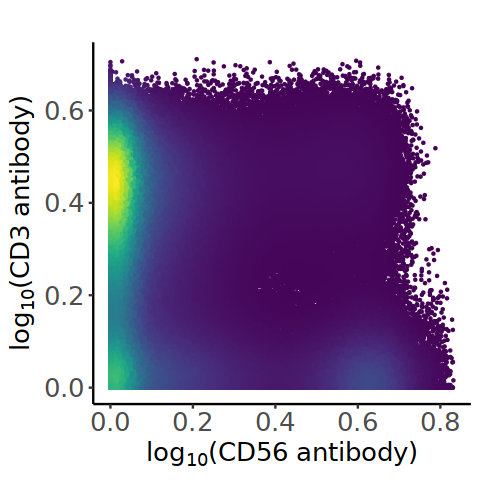

In [25]:

ggplot(data = exp_test, mapping = aes(x = log10(CD56+1), y = log10(CD3+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16, adjust = 4) +
  scale_color_viridis() +
  geom_hline(yintercept=log10(10^thresh_t), linetype='dashed', color=c('red')) +
  geom_vline(xintercept=log10(10^thresh_nk), linetype='dashed', color=c('red')) +
  scale_x_continuous(limits = c(xmin,xmax)) +
  scale_y_continuous(limits = c(ymin,ymax)) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD56 antibody)")),
       y = bquote(paste(log[10], "(CD3 antibody)"))) 

ggplot(data = exp_test, mapping = aes(x = log10(CD56+1), y = log10(CD3+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16, adjust = 4) +
  scale_color_viridis() +
  # geom_hline(yintercept=log10(10^thresh_t), linetype='dashed', color=c('red')) +
  # geom_vline(xintercept=log10(10^thresh_nk), linetype='dashed', color=c('red')) +
  scale_x_continuous(limits = c(xmin,xmax)) +
  scale_y_continuous(limits = c(ymin,ymax)) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD56 antibody)")),
       y = bquote(paste(log[10], "(CD3 antibody)"))) 

In [26]:
bf = nrow(expr)
expr %<>%
     as.data.frame() %>%
     dplyr::filter(log10(`CD56`+1)<thresh_nk) %>%
     dplyr::filter(log10(`CD3`+1)>thresh_t)
nrow(expr)
100*nrow(expr)/bf

[1] 1676495

[1] 51.83397

In [27]:
nrow(expr)

[1] 1676495

In [28]:
# saveRDS(expr[,c("subject_id","batch","group","CCP","age","sex","site",markers)], file = "/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_normalized_all.rds")

In [2]:
expr = readRDS("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_normalized_all.rds")

In [3]:
meta_ah = read.csv("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/metadata_Alice.csv")
colnames(meta_ah) = c("subject_id","rename","Batch","Location","Disease")
meta_ah$subject_id = gsub("\\.fcs","",meta_ah$subject_id)
head(meta_ah)
table(meta_ah$Disease)
table(meta_ah$Location)
table(meta_ah$Batch)
meta_ah %>%
    dplyr::group_by(Location,Disease,Batch) %>%
    dplyr::summarize(count = dplyr::n())
dim(expr)
expr = merge(expr,meta_ah,by="subject_id")
dim(expr)
head(expr)

table(expr$sex)
table(expr$CCP)
table(expr$batch)
table(expr$Batch)
table(expr$group)
table(expr$Disease)
table(expr$site)
table(expr$Location)

subject_id rename       Batch Location Disease
1 10021023   earlyRA_b_1  B1    BWH      EarlyRA
2 10039927   earlyRA_b_2  B1    BWH      EarlyRA
3 10038223   earlyRA_b_3  B1    BWH      EarlyRA
4 10055724   earlyRA_b2_1 B2    BWH      EarlyRA
5 10041754   earlyRA_b2_2 B2    BWH      EarlyRA
6 10014071   earlyRA_b2_3 B2    BWH      EarlyRA


   CCP+ Control EarlyRA     FDR 
     30      23      20      27 


     BWH Colorado 
      48       52 


 B1  B2 BC3  C1  C2 
 20  22  16  20  22 

`summarise()` has grouped output by 'Location', 'Disease'. You can override
using the `.groups` argument.


Location Disease Batch count
1  BWH      CCP+    B1    8    
2  BWH      CCP+    B2    8    
3  BWH      CCP+    BC3   2    
4  BWH      Control B1    4    
5  BWH      Control B2    5    
6  BWH      EarlyRA B1    3    
7  BWH      EarlyRA B2    4    
8  BWH      EarlyRA BC3   2    
9  BWH      FDR     B1    5    
10 BWH      FDR     B2    5    
11 BWH      FDR     BC3   2    
12 Colorado CCP+    C1    5    
13 Colorado CCP+    C2    7    
14 Colorado Control BC3   4    
15 Colorado Control C1    5    
16 Colorado Control C2    5    
17 Colorado EarlyRA BC3   1    
18 Colorado EarlyRA C1    5    
19 Colorado EarlyRA C2    5    
20 Colorado FDR     BC3   5    
21 Colorado FDR     C1    5    
22 Colorado FDR     C2    5

[1] 1676495      46

[1] 1676495      50

subject_id batch      group  CCP      age sex  site AHR        CCR2     
1 01-128-99  Colorado 2 CCP(+) Positive 74  Male CU   0.00000000 0.0000000
2 01-128-99  Colorado 2 CCP(+) Positive 74  Male CU   0.09920874 0.0000000
3 01-128-99  Colorado 2 CCP(+) Positive 74  Male CU   0.00000000 0.0000000
4 01-128-99  Colorado 2 CCP(+) Positive 74  Male CU   0.53030619 0.0000000
5 01-128-99  Colorado 2 CCP(+) Positive 74  Male CU   0.91999830 0.0000000
6 01-128-99  Colorado 2 CCP(+) Positive 74  Male CU   0.11412804 0.2891261
  CCR7      ... PU.1         TACTILE   TCRVd1    TCRVd2   TIGIT    
1 0.0000000 ... 1.093108e-01 0.0000000 0.1834436 4.545495 0.0000000
2 0.0000000 ... 7.575920e-08 0.8065977 0.0000000 0.000000 0.1470930
3 2.4786338 ... 0.000000e+00 0.0000000 0.0000000 0.000000 0.0000000
4 1.5745824 ... 6.784582e-01 0.2667427 0.0000000 0.000000 0.0000000
5 0.1718356 ... 0.000000e+00 0.4589105 0.0000000 0.000000 0.1770185
6 1.2059115 ... 2.606955e-02 0.7471453 0.0000000 0.000000 0.0000000
  Tbet         rename    Batch Location Disease
1 2.395806e+00 case_c2_2 C2    Colorado CCP+   
2 4.390922e-01 case_c2_2 C2    Colorado CCP+   
3 0.000000e+00 case_c2_2 C2    Colorado CCP+   
4 1.259061e-01 case_c2_2 C2    Colorado CCP+   
5 1.139929e-01 case_c2_2 C2    Colorado CCP+   
6 1.058772e-07 case_c2_2 C2    Colorado CCP+


 Female    Male 
1257656  408516 


Negative Positive 
  476371   814043 


         BWH 1          BWH 2 Colorado & BWH     Colorado 1     Colorado 2 
        516349         334684         202206         315963         307293 


    B1     B2    BC3     C1     C2 
516349 352883 170810 315963 320490 


      CCP(+) CCP(-)FDR(+)      Control     Early RA 
      523874       476371       375758       300492 


   CCP+ Control EarlyRA     FDR 
 517206  375758  300492  483039 


   BWH     CU 
960612 715883 


     BWH Colorado 
  946107   730388 

[1] 1676495      50
[1] "Number of subjects"


[1] 100

[1] "Summary of number of cells per individuals"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    532   12058   16030   16765   20761   38063 
[1] "Number of cells per individuals: bottom"
# A tibble: 6 × 2
  subject_id   cell_counts
  <chr>              <int>
1 Normal_886          5498
2 FDRneg_333.1        5455
3 01-128-99           4844
4 01-209-01           4045
5 09-066-00           1135
6 01-953-00            532
[1] "Number of cells per individuals: top"
# A tibble: 6 × 2
  subject_id cell_counts
  <chr>            <int>
1 10000319         38063
2 SR0085           35493
3 10000317         32703
4 SR0029           32479
5 SR0032           31503
6 SR0025           31373


Disease cell_counts
1 CCP+    517206     
2 FDR     483039     
3 Control 375758     
4 EarlyRA 300492

`summarise()` has grouped output by 'subject_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Batch'. You can override using the
`.groups` argument.


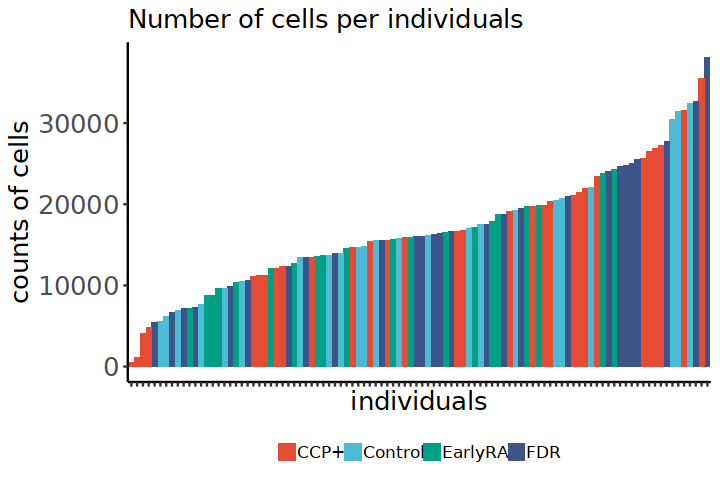

`summarise()` has grouped output by 'Location'. You can override using the
`.groups` argument.


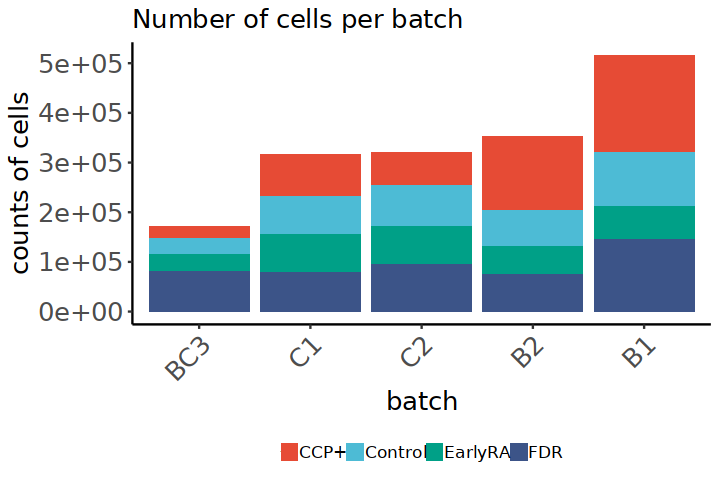

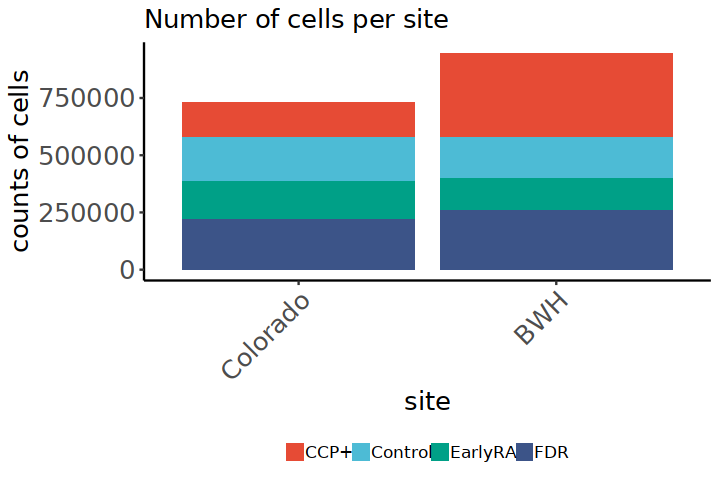

In [4]:
# check the filtered data
print(dim(expr))

# check the number of subjects
print("Number of subjects")
length(unique(expr$subject_id))

# check the number of cells per individual
print("Summary of number of cells per individuals")
print(expr %>%
        dplyr::group_by(subject_id) %>%
        dplyr::summarise(cell_counts = n()) %>%
        dplyr::ungroup() %>%
        .$cell_counts %>%
        summary())
print("Number of cells per individuals: bottom")
print(expr %>%
        dplyr::group_by(subject_id) %>%
        dplyr::summarise(cell_counts = n()) %>%
        dplyr::ungroup() %>%
        dplyr::arrange(desc(cell_counts)) %>%
        tail())
print("Number of cells per individuals: top")
print(expr %>%
        dplyr::group_by(subject_id) %>%
        dplyr::summarise(cell_counts = n()) %>%
        dplyr::ungroup() %>%
        dplyr::arrange(desc(cell_counts)) %>%
        head())
expr %>%
  dplyr::group_by(Disease) %>%
  dplyr::summarise(cell_counts = n()) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(desc(cell_counts))
options(repr.plot.height = 4, repr.plot.width = 6)
# check the number of cells per individual according to diagnosis
options(repr.plot.height = 4, repr.plot.width = 6)
expr %>%
  dplyr::group_by(subject_id, Disease) %>%
  dplyr::summarise(cell_counts = n()) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(desc(cell_counts)) %>%
  ggplot() + 
  geom_bar(aes(reorder(subject_id,cell_counts),cell_counts, fill = Disease), stat = 'identity') + 
  theme_classic() +
  scale_fill_npg() +
  # facet_grid( ~ disease) + 
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_blank(),
        legend.text =  element_text(size = 10), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = 'Number of cells per individuals',
       x = 'individuals',
       y = "counts of cells") 

expr %>%
  dplyr::group_by(Batch, Disease) %>%
  dplyr::summarise(cell_counts = n()) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(desc(cell_counts)) %>%
  ggplot() + 
  geom_bar(aes(reorder(Batch,cell_counts),cell_counts, fill = Disease), stat = 'identity') + 
  theme_classic() +
  scale_fill_npg() +
  # facet_grid( ~ disease) + 
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 10), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = 'Number of cells per batch',
       x = 'batch',
       y = "counts of cells") 

expr %>%
  dplyr::group_by(Location, Disease) %>%
  dplyr::summarise(cell_counts = n()) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(desc(cell_counts)) %>%
  ggplot() + 
  geom_bar(aes(reorder(Location,cell_counts),cell_counts, fill = Disease), stat = 'identity') + 
  theme_classic() +
  scale_fill_npg() +
  # facet_grid( ~ disease) + 
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 10), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = 'Number of cells per site',
       x = 'site',
       y = "counts of cells") 


In [5]:
FUN <- function(x, n, frac) {
    min_byFrac = as.integer(length(x)*frac)
    if (as.integer(length(x)) <= n) {
        return(x)
    } else if (as.integer(length(x)) > n & min_byFrac <= n) {
        return(x[x %in% sample(x, n)])
    } else if (as.integer(length(x)) > n & min_byFrac > n) {
        return(x[x %in% sample(x, min_byFrac)])
    }
}

prop = 0.5
n_min = 10000
print(prop)
print(n_min)

set.seed(1234)
exp_ds <- expr[unlist(lapply(split(1:nrow(expr), expr$subject_id),
                                   FUN, n = n_min, frac = prop)), ] %>%
          as.data.frame()

# check the downsampled data
print(dim(exp_ds))
print(head(exp_ds))
print("ratio of the number of cells of downsampled data compared with filtered data")
print(100*nrow(exp_ds)/nrow(expr))

[1] 0.5
[1] 10000
[1] 1022630      50
  subject_id      batch  group      CCP age  sex site        AHR      CCR2
1  01-128-99 Colorado 2 CCP(+) Positive  74 Male   CU 0.00000000 0.0000000
2  01-128-99 Colorado 2 CCP(+) Positive  74 Male   CU 0.09920874 0.0000000
3  01-128-99 Colorado 2 CCP(+) Positive  74 Male   CU 0.00000000 0.0000000
4  01-128-99 Colorado 2 CCP(+) Positive  74 Male   CU 0.53030619 0.0000000
5  01-128-99 Colorado 2 CCP(+) Positive  74 Male   CU 0.91999830 0.0000000
6  01-128-99 Colorado 2 CCP(+) Positive  74 Male   CU 0.11412804 0.2891261
       CCR7     CD127 CD14      CD16      CD20      CD25         CD27      CD3
1 0.0000000 0.1255817    0 0.2979977 0.0000000 0.0000000 1.223695e-05 2.606196
2 0.0000000 1.1840236    0 0.0000000 0.0000000 0.0000000 2.454134e-01 1.874856
3 2.4786338 1.2691253    0 0.1493958 0.2284452 0.0000000 9.537647e-01 1.715979
4 1.5745824 1.6324094    0 0.0000000 0.0000000 0.0000000 1.825757e+00 1.993345
5 0.1718356 3.1402736    0 0.1586784 0.000

[1] 1022630      50
[1] "Number of subjects"


[1] 100

[1] "Summary of number of cells per individuals"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    532   10000   10000   10226   10380   19031 
[1] "Number of cells per individuals: bottom"
# A tibble: 6 × 2
  subject_id   cell_counts
  <chr>              <int>
1 Normal_886          5498
2 FDRneg_333.1        5455
3 01-128-99           4844
4 01-209-01           4045
5 09-066-00           1135
6 01-953-00            532
[1] "Number of cells per individuals: top"
# A tibble: 6 × 2
  subject_id cell_counts
  <chr>            <int>
1 10000319         19031
2 SR0085           17746
3 10000317         16351
4 SR0029           16239
5 SR0032           15751
6 SR0025           15686


Disease cell_counts
1 CCP+    301328     
2 FDR     288257     
3 Control 234766     
4 EarlyRA 198279

`summarise()` has grouped output by 'subject_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Batch'. You can override using the
`.groups` argument.


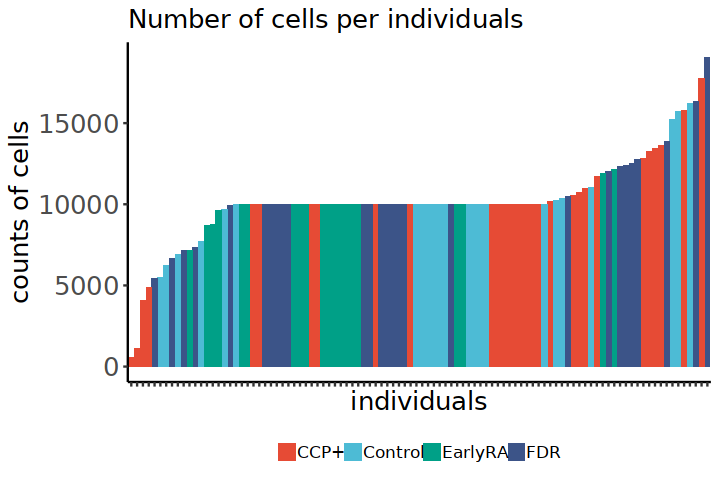

`summarise()` has grouped output by 'Location'. You can override using the
`.groups` argument.


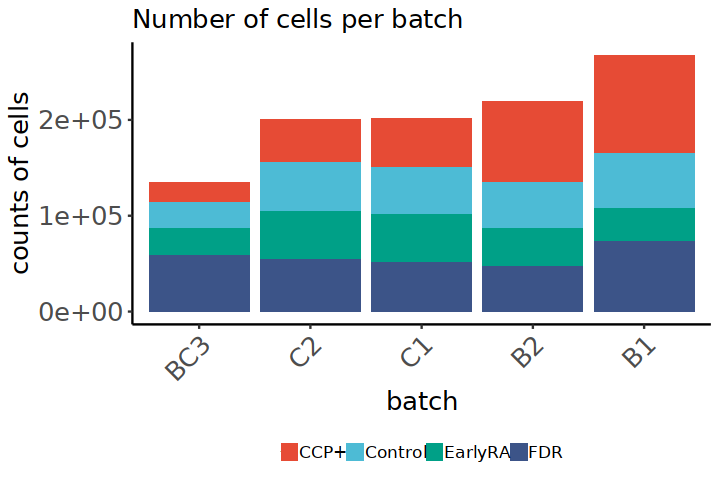

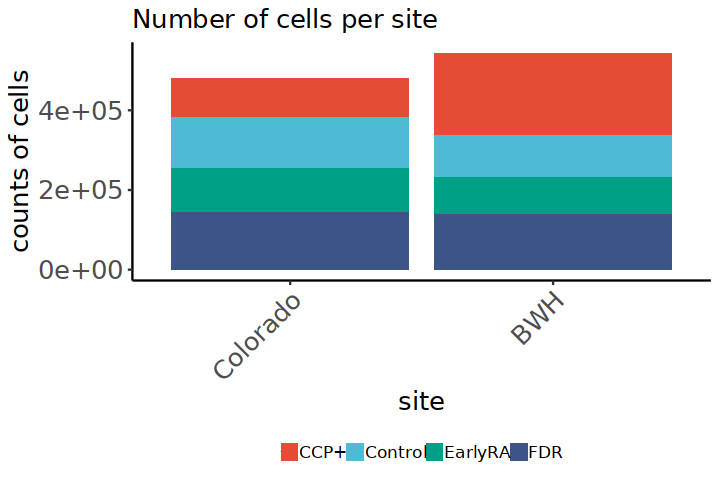

In [8]:
# check the filtered data
print(dim(exp_ds))

# check the number of subjects
print("Number of subjects")
length(unique(exp_ds$subject_id))

# check the number of cells per individual
print("Summary of number of cells per individuals")
print(exp_ds %>%
    dplyr::group_by(subject_id) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    .$cell_counts %>%
    summary())
print("Number of cells per individuals: bottom")
print(exp_ds %>%
    dplyr::group_by(subject_id) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(cell_counts)) %>%
    tail())
print("Number of cells per individuals: top")
print(exp_ds %>%
    dplyr::group_by(subject_id) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(cell_counts)) %>%
    head())
exp_ds %>%
    dplyr::group_by(Disease) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(cell_counts))
options(repr.plot.height = 4, repr.plot.width = 6)
# check the number of cells per individual according to diagnosis
options(repr.plot.height = 4, repr.plot.width = 6)
exp_ds %>%
    dplyr::group_by(subject_id, Disease) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(cell_counts)) %>%
    ggplot() + 
        geom_bar(aes(reorder(subject_id,cell_counts),cell_counts, fill = Disease), stat = 'identity') + 
        theme_classic() +
        scale_fill_npg() +
        # facet_grid( ~ disease) + 
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "bottom",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_blank(),
            legend.text =  element_text(size = 10), 
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
        labs(title = 'Number of cells per individuals',
             x = 'individuals',
             y = "counts of cells") 

exp_ds %>%
    dplyr::group_by(Batch, Disease) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(cell_counts)) %>%
    ggplot() + 
        geom_bar(aes(reorder(Batch,cell_counts),cell_counts, fill = Disease), stat = 'identity') + 
        theme_classic() +
        scale_fill_npg() +
        # facet_grid( ~ disease) + 
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "bottom",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
            legend.text =  element_text(size = 10), 
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
        labs(title = 'Number of cells per batch',
             x = 'batch',
             y = "counts of cells") 

exp_ds %>%
    dplyr::group_by(Location, Disease) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(cell_counts)) %>%
    ggplot() + 
        geom_bar(aes(reorder(Location,cell_counts),cell_counts, fill = Disease), stat = 'identity') + 
        theme_classic() +
        scale_fill_npg() +
        # facet_grid( ~ disease) + 
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
            strip.text.y=element_text(size=15, color="black", face="bold"),
            legend.position = "bottom",
            plot.title = element_text(size=15),
            axis.title.x = element_text(size=15),
            axis.title.y = element_text(size =15),
            axis.text.y = element_text(size = 15),
            axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
            legend.text =  element_text(size = 10), 
            legend.key.size = grid::unit(0.8, "lines"),
            legend.title = element_text(size = 0, hjust = 0)) +
        labs(title = 'Number of cells per site',
             x = 'site',
             y = "counts of cells") 

In [9]:
# saveRDS(exp_ds[,c("subject_id","batch","group","CCP","age","sex","site","Batch","Disease","Location","rename",markers)], file = "/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_downsampled.rds")

In [2]:
exp_ds = readRDS("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_downsampled.rds")

In [3]:
pca_res <- readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_PCA_embeddings.rds"))

# check the data
print(dim(pca_res$x))
print(head(pca_res$x))
print(dim(exp_ds))
print(head(exp_ds))

[1] 1022630      20
           PC1         PC2        PC3         PC4         PC5         PC6
[1,]  3.584249  5.01309421  3.1622179 -4.15564036  2.46627764  0.10960401
[2,]  6.796358  3.09150627  0.1826891 -0.86457756 -1.22929419  0.08627089
[3,] -1.477273  0.19646202  1.5093555 -0.01149618 -0.02875604 -0.32704581
[4,] -2.425686  0.09584817  0.3028183  0.32838468  0.12397176 -0.20670464
[5,] -2.181268  1.09066440 -1.8786545 -0.93123244 -0.58918028 -0.55709518
[6,] -1.980801 -0.36140419  0.4715534 -0.20022726  0.24741458 -0.82419922
            PC7        PC8          PC9       PC10        PC11       PC12
[1,] -2.2996912  0.5472932 -1.223018135 -0.2683617 -0.18249867 -0.5409119
[2,] -0.7615321 -0.1321872 -2.631575337 -1.0511450  0.85026212 -1.1112302
[3,]  0.8635753 -0.6958363 -1.363712834  0.3844494  0.15932186  0.1510914
[4,]  0.1933103  0.4880307 -0.087116069  0.2674607 -0.04373365  0.2268336
[5,]  1.1626299  0.4616289  0.004011479  0.0284452 -0.06608376 -0.8884164
[6,]  0.5013001 -0

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


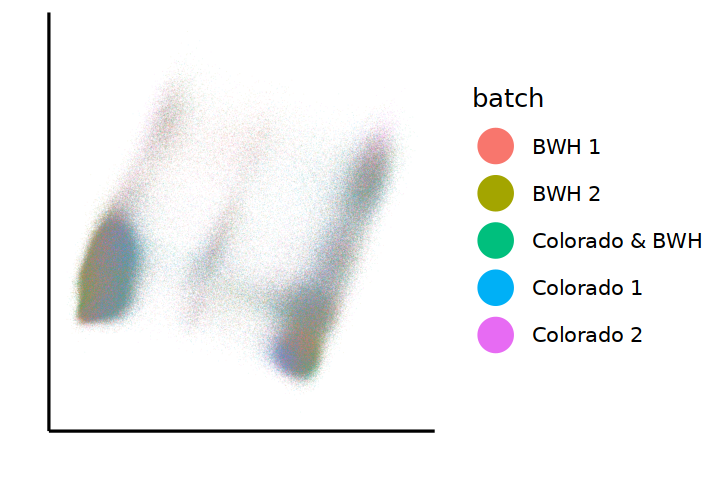

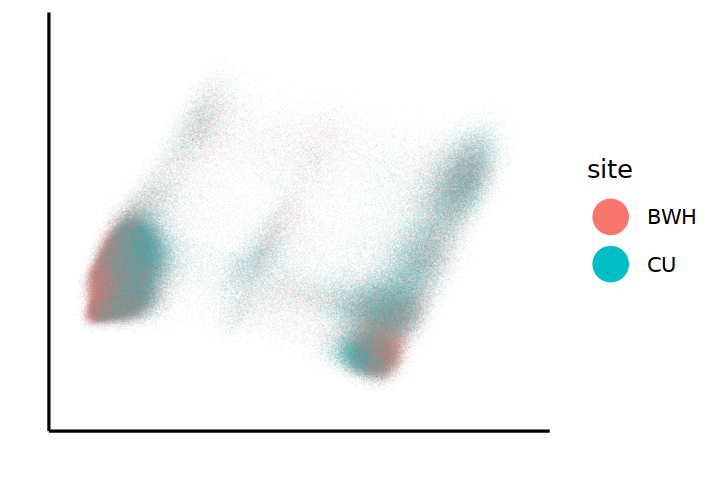

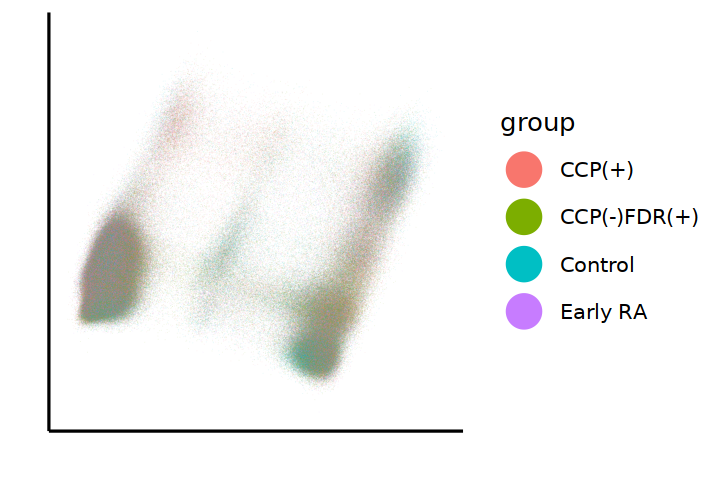

In [4]:
set.seed(1234)
logi = sample(1:nrow(pca_res$x))

options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
    geom_point(
        data = data.frame(pca_res$x[logi,c("PC1","PC2")],exp_ds[logi,]),
        mapping = aes_string(x = "PC1", y = "PC2", color = "batch", fill = "batch"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "right",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.key.size = unit(1, 'cm')
    ) + guides(colour = guide_legend(override.aes = list(size=10, alpha = 1)))

ggplot() +
    geom_point(
        data = data.frame(pca_res$x[logi,c("PC1","PC2")],exp_ds[logi,]),
        mapping = aes_string(x = "PC1", y = "PC2", color = "site", fill = "site"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "right",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.key.size = unit(1, 'cm')
    ) + guides(colour = guide_legend(override.aes = list(size=10, alpha = 1)))

ggplot() +
    geom_point(
        data = data.frame(pca_res$x[logi,c("PC1","PC2")],exp_ds[logi,]),
        mapping = aes_string(x = "PC1", y = "PC2", color = "group", fill = "group"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "right",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.key.size = unit(1, 'cm')
    ) + guides(colour = guide_legend(override.aes = list(size=10, alpha = 1)))

In [5]:
harmony_embeddings_all <- readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_harmony_embeddings.rds"))
print(head(harmony_embeddings_all))
print(dim(harmony_embeddings_all))

           PC1        PC2          PC3         PC4        PC5         PC6
[1,]  4.031390  4.8803238  2.938814774 -3.28732503  1.9858658  0.53657025
[2,]  7.330971  3.0827973  0.003402659 -0.14092577 -1.7644460  0.23454088
[3,] -1.752317 -0.2078587  1.588099515 -0.03120536 -0.5862902 -0.18702435
[4,] -2.688979 -0.3063787  0.387279190  0.32133378 -0.4194325 -0.06769243
[5,] -2.263302  0.9544440 -2.169250273 -0.82273542 -0.8919936 -0.23600196
[6,] -2.247775 -0.7663565  0.554959995 -0.21622961 -0.3037698 -0.68482937
             PC7         PC8         PC9        PC10        PC11       PC12
[1,] -2.22396080  0.63711568 -1.42008898 -0.88448330 -0.03615984 -0.7429901
[2,] -0.81908346 -0.06252466 -3.19219911 -1.33625632  1.20675922 -1.3945795
[3,]  0.30941002 -0.39465098 -1.20507230  0.39897021  0.15468102  0.1104348
[4,] -0.36129240  0.78702142  0.05256420  0.29577224 -0.06172067  0.1925833
[5,]  0.75479989  0.61794651  0.05925785  0.05765281 -0.01286757 -0.7954323
[6,] -0.05140589 -0.096795

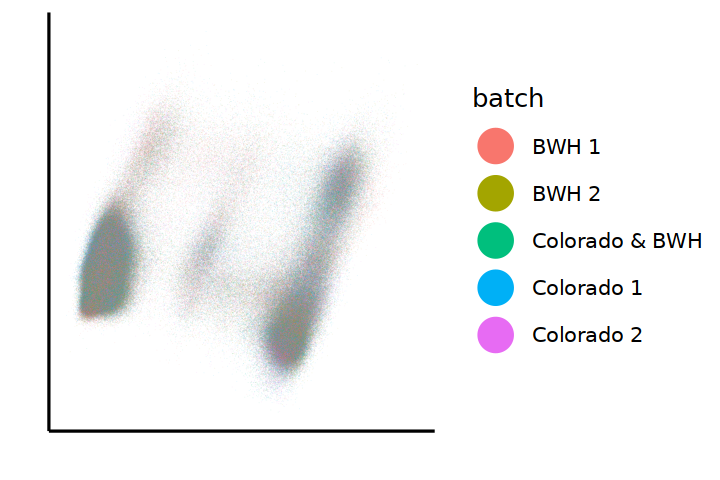

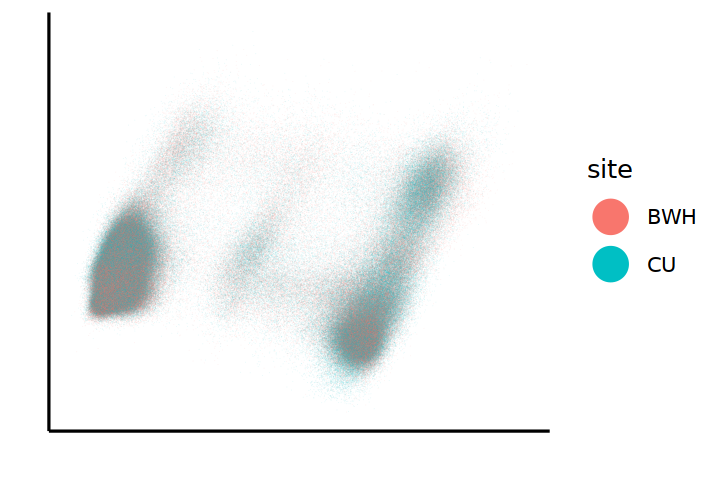

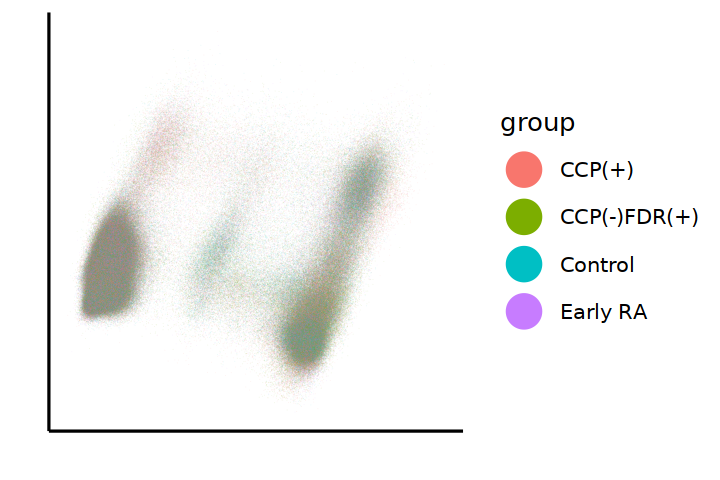

In [6]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all[logi,c("PC1","PC2")],exp_ds[logi,]),
        mapping = aes_string(x = "PC1", y = "PC2", color = "batch", fill = "batch"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "right",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.key.size = unit(1, 'cm')
    ) + guides(colour = guide_legend(override.aes = list(size=10, alpha = 1)))

ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all[logi,c("PC1","PC2")],exp_ds[logi,]),
        mapping = aes_string(x = "PC1", y = "PC2", color = "site", fill = "site"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "right",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.key.size = unit(1, 'cm')
    ) + guides(colour = guide_legend(override.aes = list(size=10, alpha = 1)))

ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all[logi,c("PC1","PC2")],exp_ds[logi,]),
        mapping = aes_string(x = "PC1", y = "PC2", color = "group", fill = "group"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "right",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.key.size = unit(1, 'cm')
    ) + guides(colour = guide_legend(override.aes = list(size=10, alpha = 1)))



`summarise()` has grouped output by 'key'. You can override using the `.groups`
argument.


key        group  median   
1 Batch      after   3.565859
2 Batch      before  3.199760
3 Disease    after   3.149429
4 Disease    before  3.085222
5 Location   after   1.851467
6 Location   before  1.722363
7 subject_id after  10.357313
8 subject_id before  9.550517

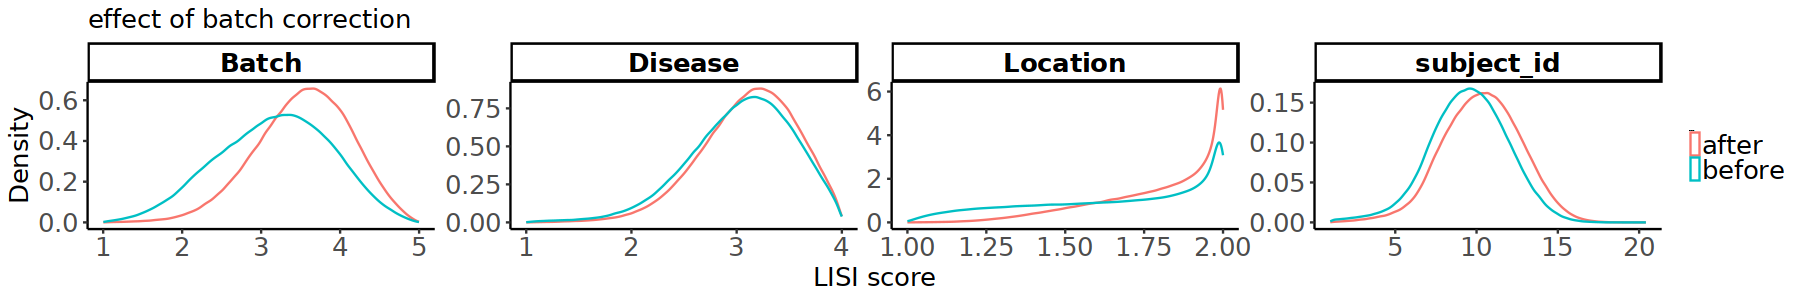

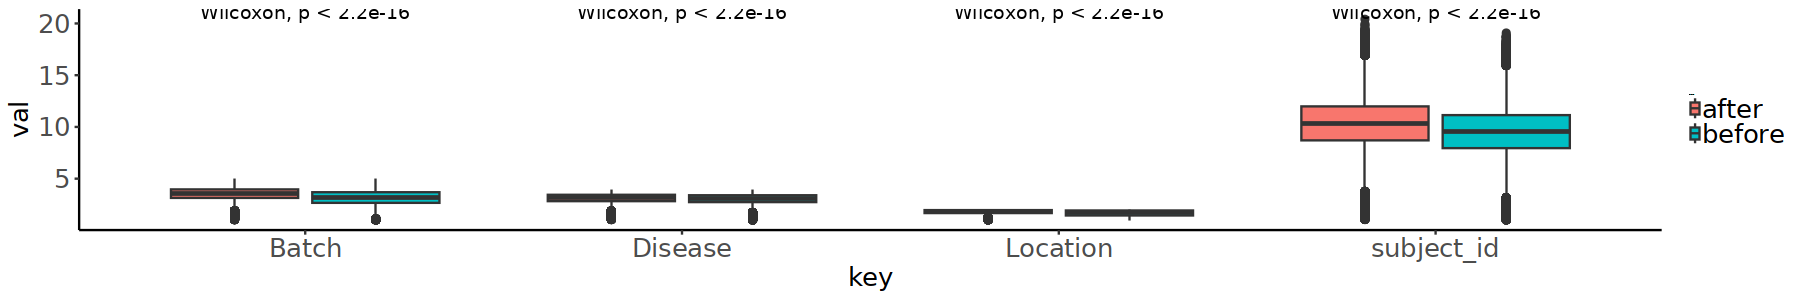

In [7]:
# using PC1-20
LISI_df = rbind(
    readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_LISI_harmony.rds")) %>%
        dplyr::mutate(group = "after"),
    readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_LISI_PCA.rds")) %>%
        dplyr::mutate(group = "before")
    ) %>% na.omit()


LISI_df %>%
    dplyr::group_by(key,group) %>%
    dplyr::summarize(median = median(val))

options(repr.plot.height = 2.5, repr.plot.width = 15)
ggplot(LISI_df) +
      geom_density(
        aes(x  = val, color = group) 
      ) +
      #   scale_x_continuous(limits = c(1, 15))+
      labs(
        title = "effect of batch correction",
        x = "LISI score",
        y = "Density"
      ) +
      facet_wrap( ~ key, scales = "free", ncol = 5) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "right",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) 

LISI_df %>% 
  ggplot(aes(x=key, y=val, fill=group)) +
  geom_boxplot() +
  ggpubr::stat_compare_means(method= "wilcox.test") +
  theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "right",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) 

In [6]:
# de novo clustering

In [8]:
umap_res <- readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_umap_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
# remove clusters less than cut off
min_cell_cluster = 30
clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
clu_logi = umap_res$res_cell %in% clu
print(table(umap_res[clu_logi,]$res_cell))
print(length(unique(umap_res[clu_logi,]$res_cell)))
umap_res = umap_res[clu_logi,]


     0      1      2      3      4      5      6      7      8      9     10 
141047 133305 103346  93119  92831  60937  56865  52138  46221  34882  33811 
    11     12     13     14     15     16     17     18     19     20     21 
 28884  26028  22859  21758  17967  15891  13822   7728   4977   4693   4686 
    22     23     24     25 
  2458   1809    448    105 
[1] 26


In [9]:
# Find cluster center
cluster_center <- umap_res %>%
  dplyr::group_by(res_cell) %>%
  dplyr::summarise_at(vars(UMAP1, UMAP2), dplyr::funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_cell <- as.character(cluster_center$res_cell)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [10]:
# meta data

batch_fl = readRDS("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_downsampled.rds")
batch_fl = batch_fl[clu_logi, c("subject_id","Batch","Disease","age","sex","Location")]
all(umap_res$subject_id == batch_fl$subject_id)

umap_res$sex <- factor(batch_fl$sex, c('Female', 'Male'))
umap_res$Batch <- factor(batch_fl$Batch)
umap_res$Disease = factor(batch_fl$Disease, levels = c('Control', 'FDR', 'CCP+', 'EarlyRA'))
umap_res$Location = factor(batch_fl$Location, levels = c('Colorado', 'BWH'))
umap_res$AtRisk = dplyr::case_when(
  batch_fl$Disease == "FDR" | batch_fl$Disease == "CCP+" ~ "AtRiskRA",
  batch_fl$Disease == "Control" ~ "Control",
  batch_fl$Disease == "EarlyRA" ~ "RA")
umap_res$AtRisk = factor(umap_res$AtRisk, levels=c("Control","AtRiskRA","RA"))
umap_res$res_cell = as.character(umap_res$res_cell)

head(umap_res)
table(umap_res$Location)
table(umap_res$AtRisk)
table(umap_res$Disease)
table(umap_res$Batch)

[1] TRUE

UMAP1       UMAP2       group  batch res_cell Disease Batch sex  Location
1  -6.0232918 -12.2156084 CCP(+) NA    17       CCP+    C2    Male Colorado
2 -10.5170357  -0.7406135 CCP(+) NA    5        CCP+    C2    Male Colorado
3   4.2511151   3.5428397 CCP(+) NA    1        CCP+    C2    Male Colorado
4   3.7699914  -0.1555378 CCP(+) NA    4        CCP+    C2    Male Colorado
5   0.8668123  -6.3274625 CCP(+) NA    2        CCP+    C2    Male Colorado
6   5.1426003   2.1599283 CCP(+) NA    0        CCP+    C2    Male Colorado
  AtRisk  
1 AtRiskRA
2 AtRiskRA
3 AtRiskRA
4 AtRiskRA
5 AtRiskRA
6 AtRiskRA


Colorado      BWH 
  479076   543539 


 Control AtRiskRA       RA 
  234762   589578   198275 


Control     FDR    CCP+ EarlyRA 
 234762  288255  301323  198275 


    B1     B2    BC3     C1     C2 
267642 218719 135044 201147 200063 

In [11]:
get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

umap_res = umap_res %>%
    dplyr::group_by(Disease) %>%
    dplyr::mutate(density_Disease = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Batch) %>%
    dplyr::mutate(density_Batch = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(res_cell) %>%
    dplyr::mutate(density_cluster = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(AtRisk) %>%
    dplyr::mutate(density_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Location,Disease) %>%
    dplyr::mutate(density_Location_Disease = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Location,AtRisk) %>%
    dplyr::mutate(density_Location_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Batch,Disease) %>%
    dplyr::mutate(density_Batch_Disease = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Batch,AtRisk) %>%
    dplyr::mutate(density_Batch_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup()

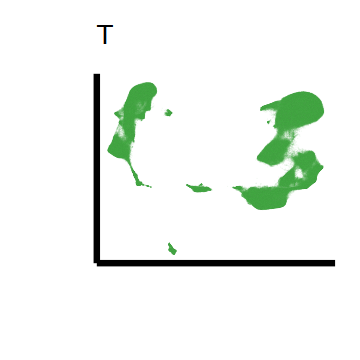

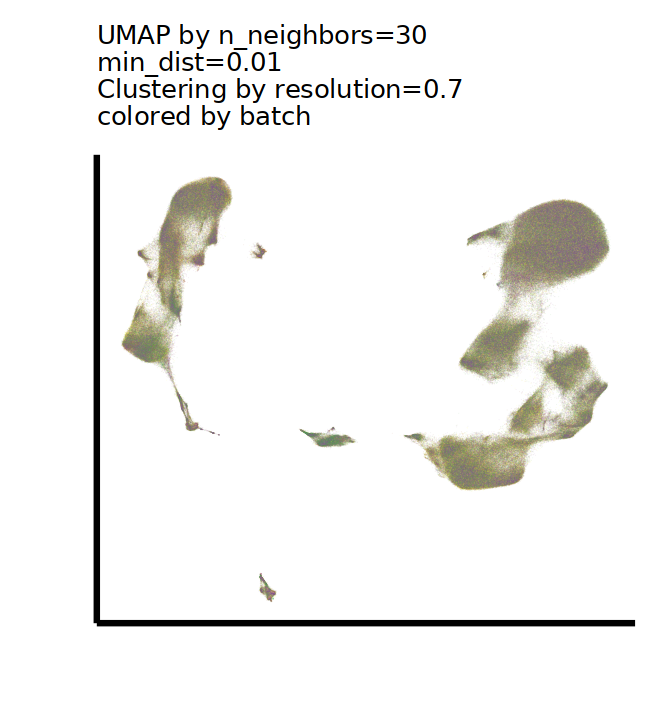

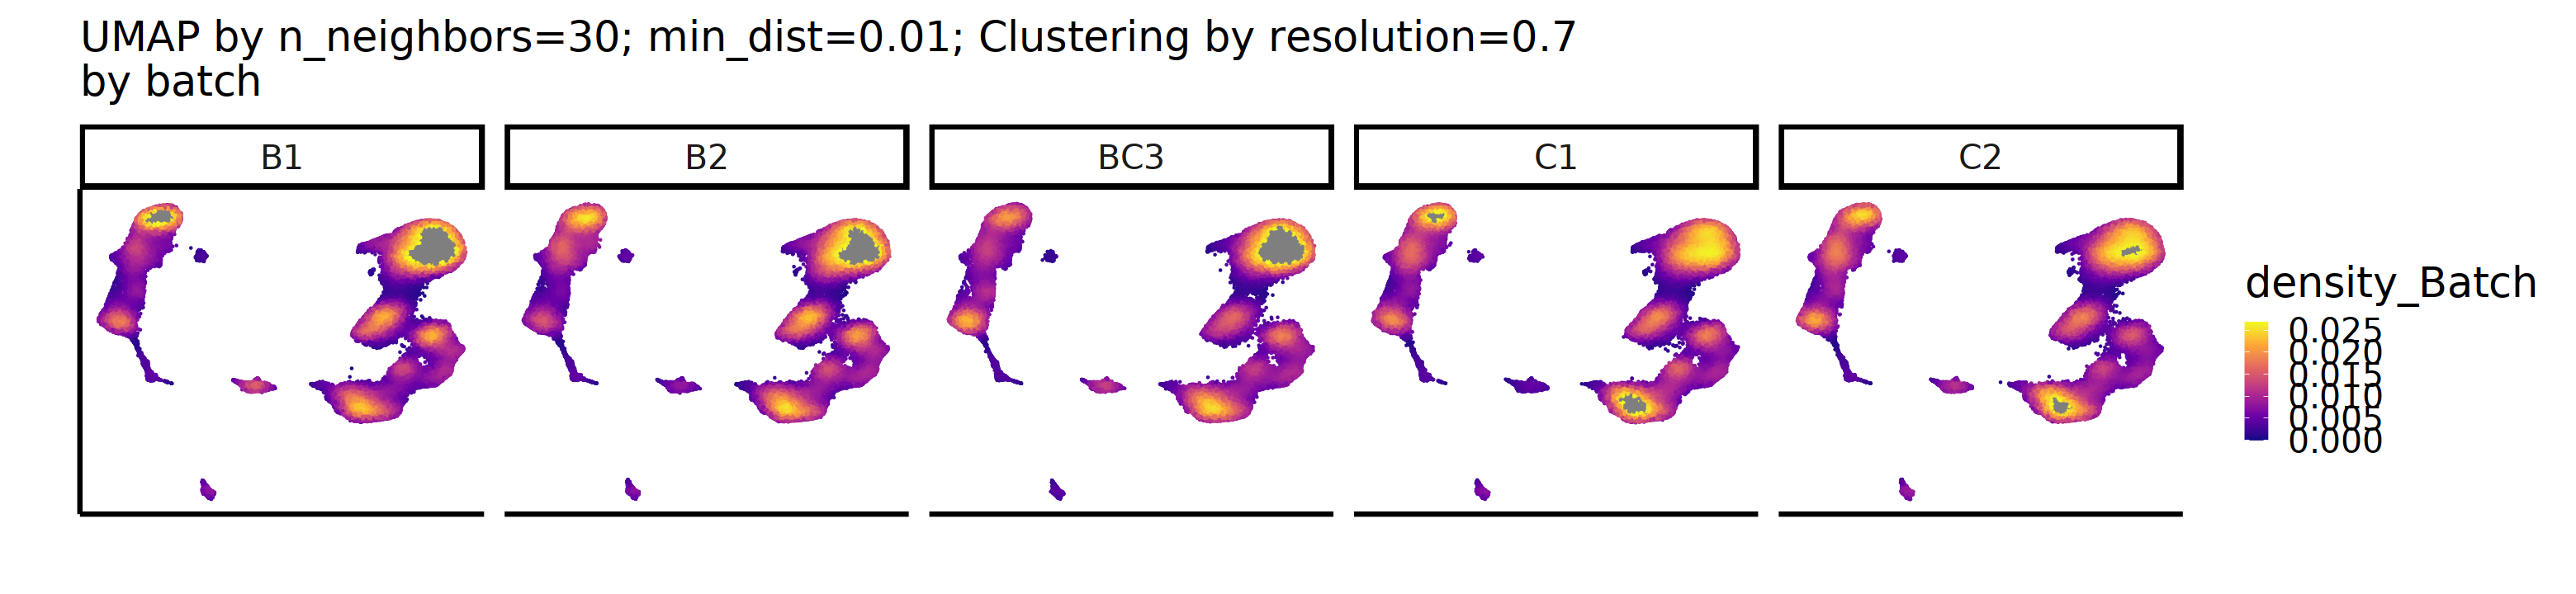

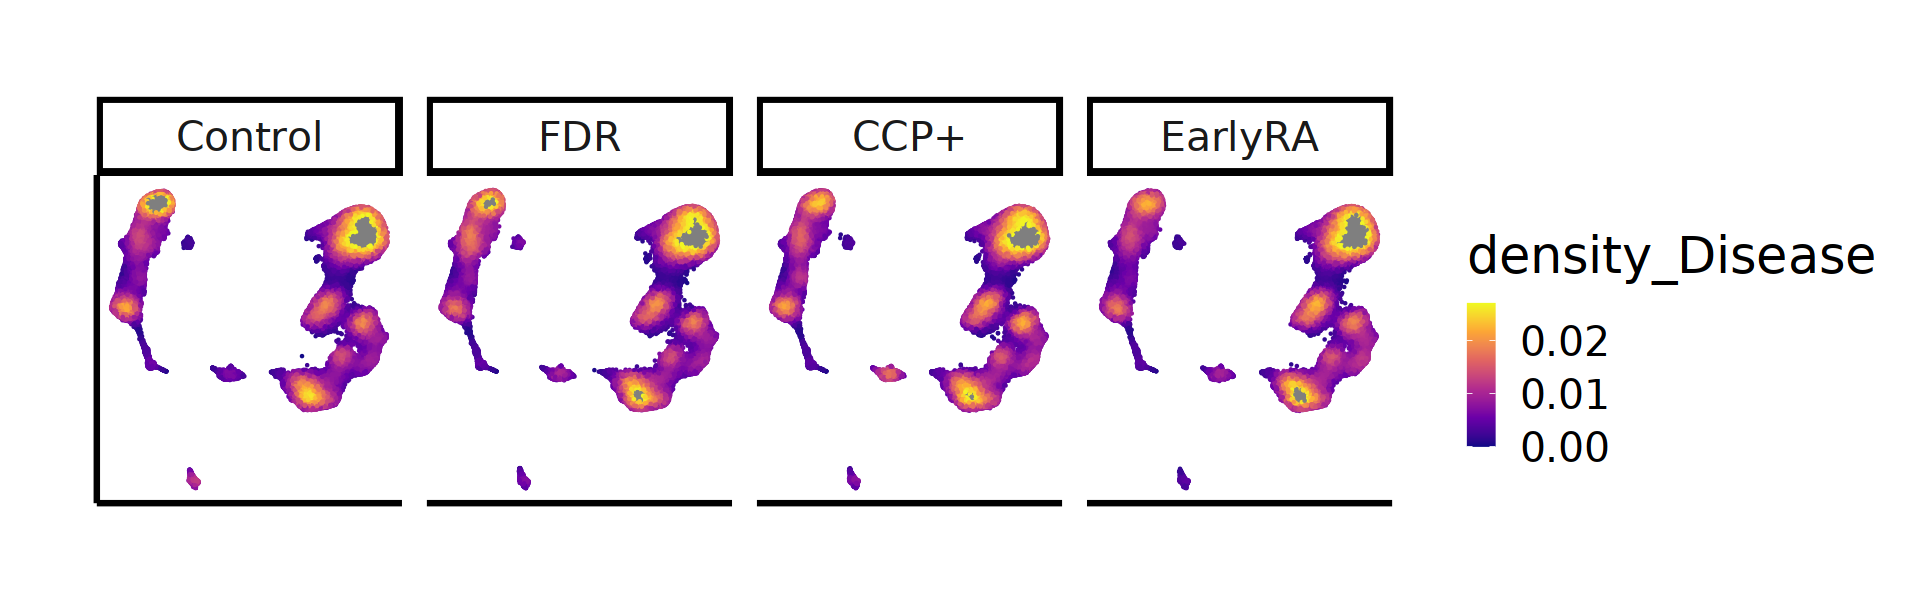

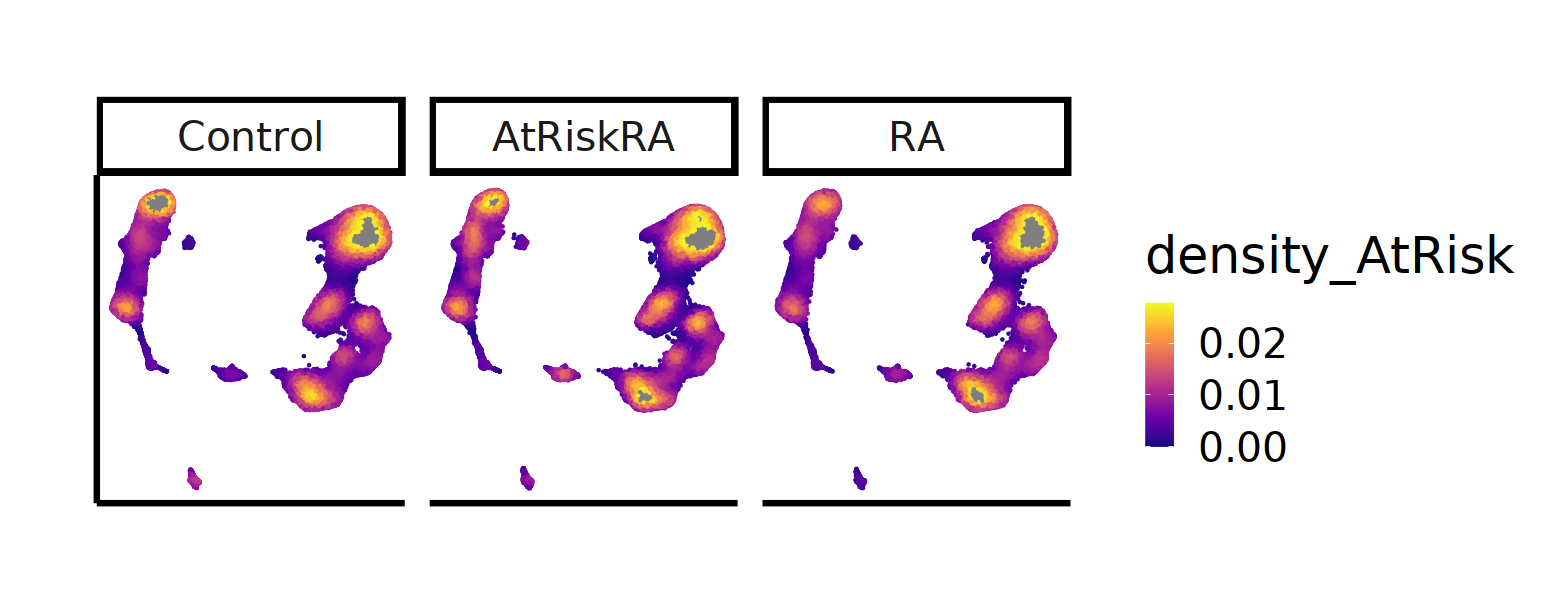

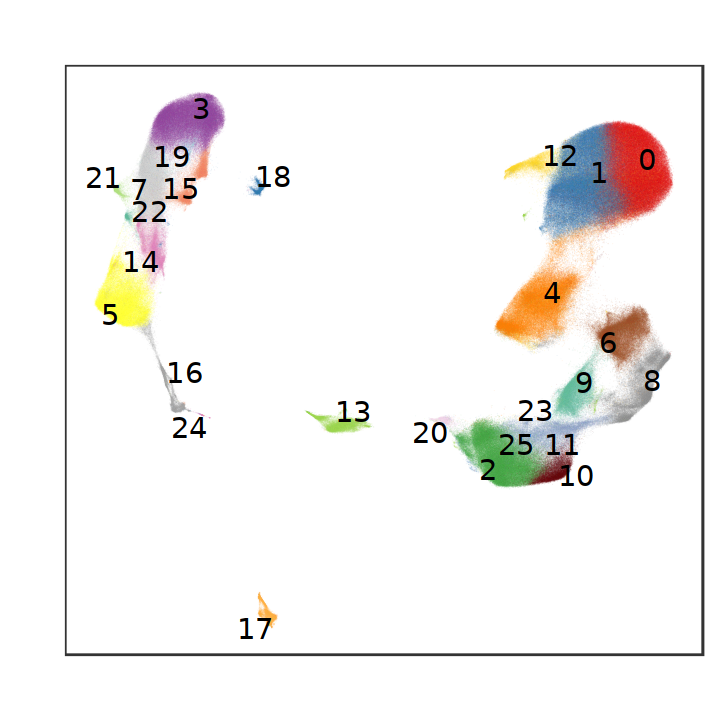

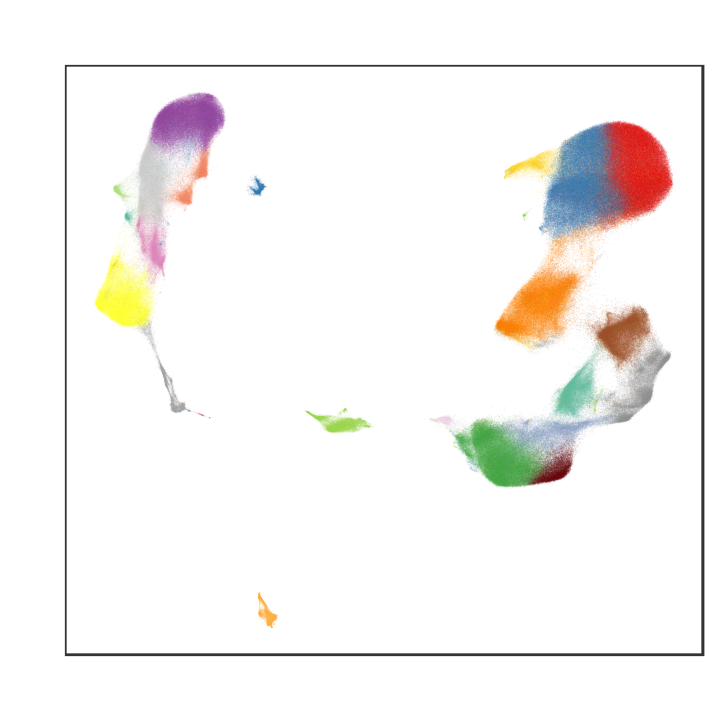

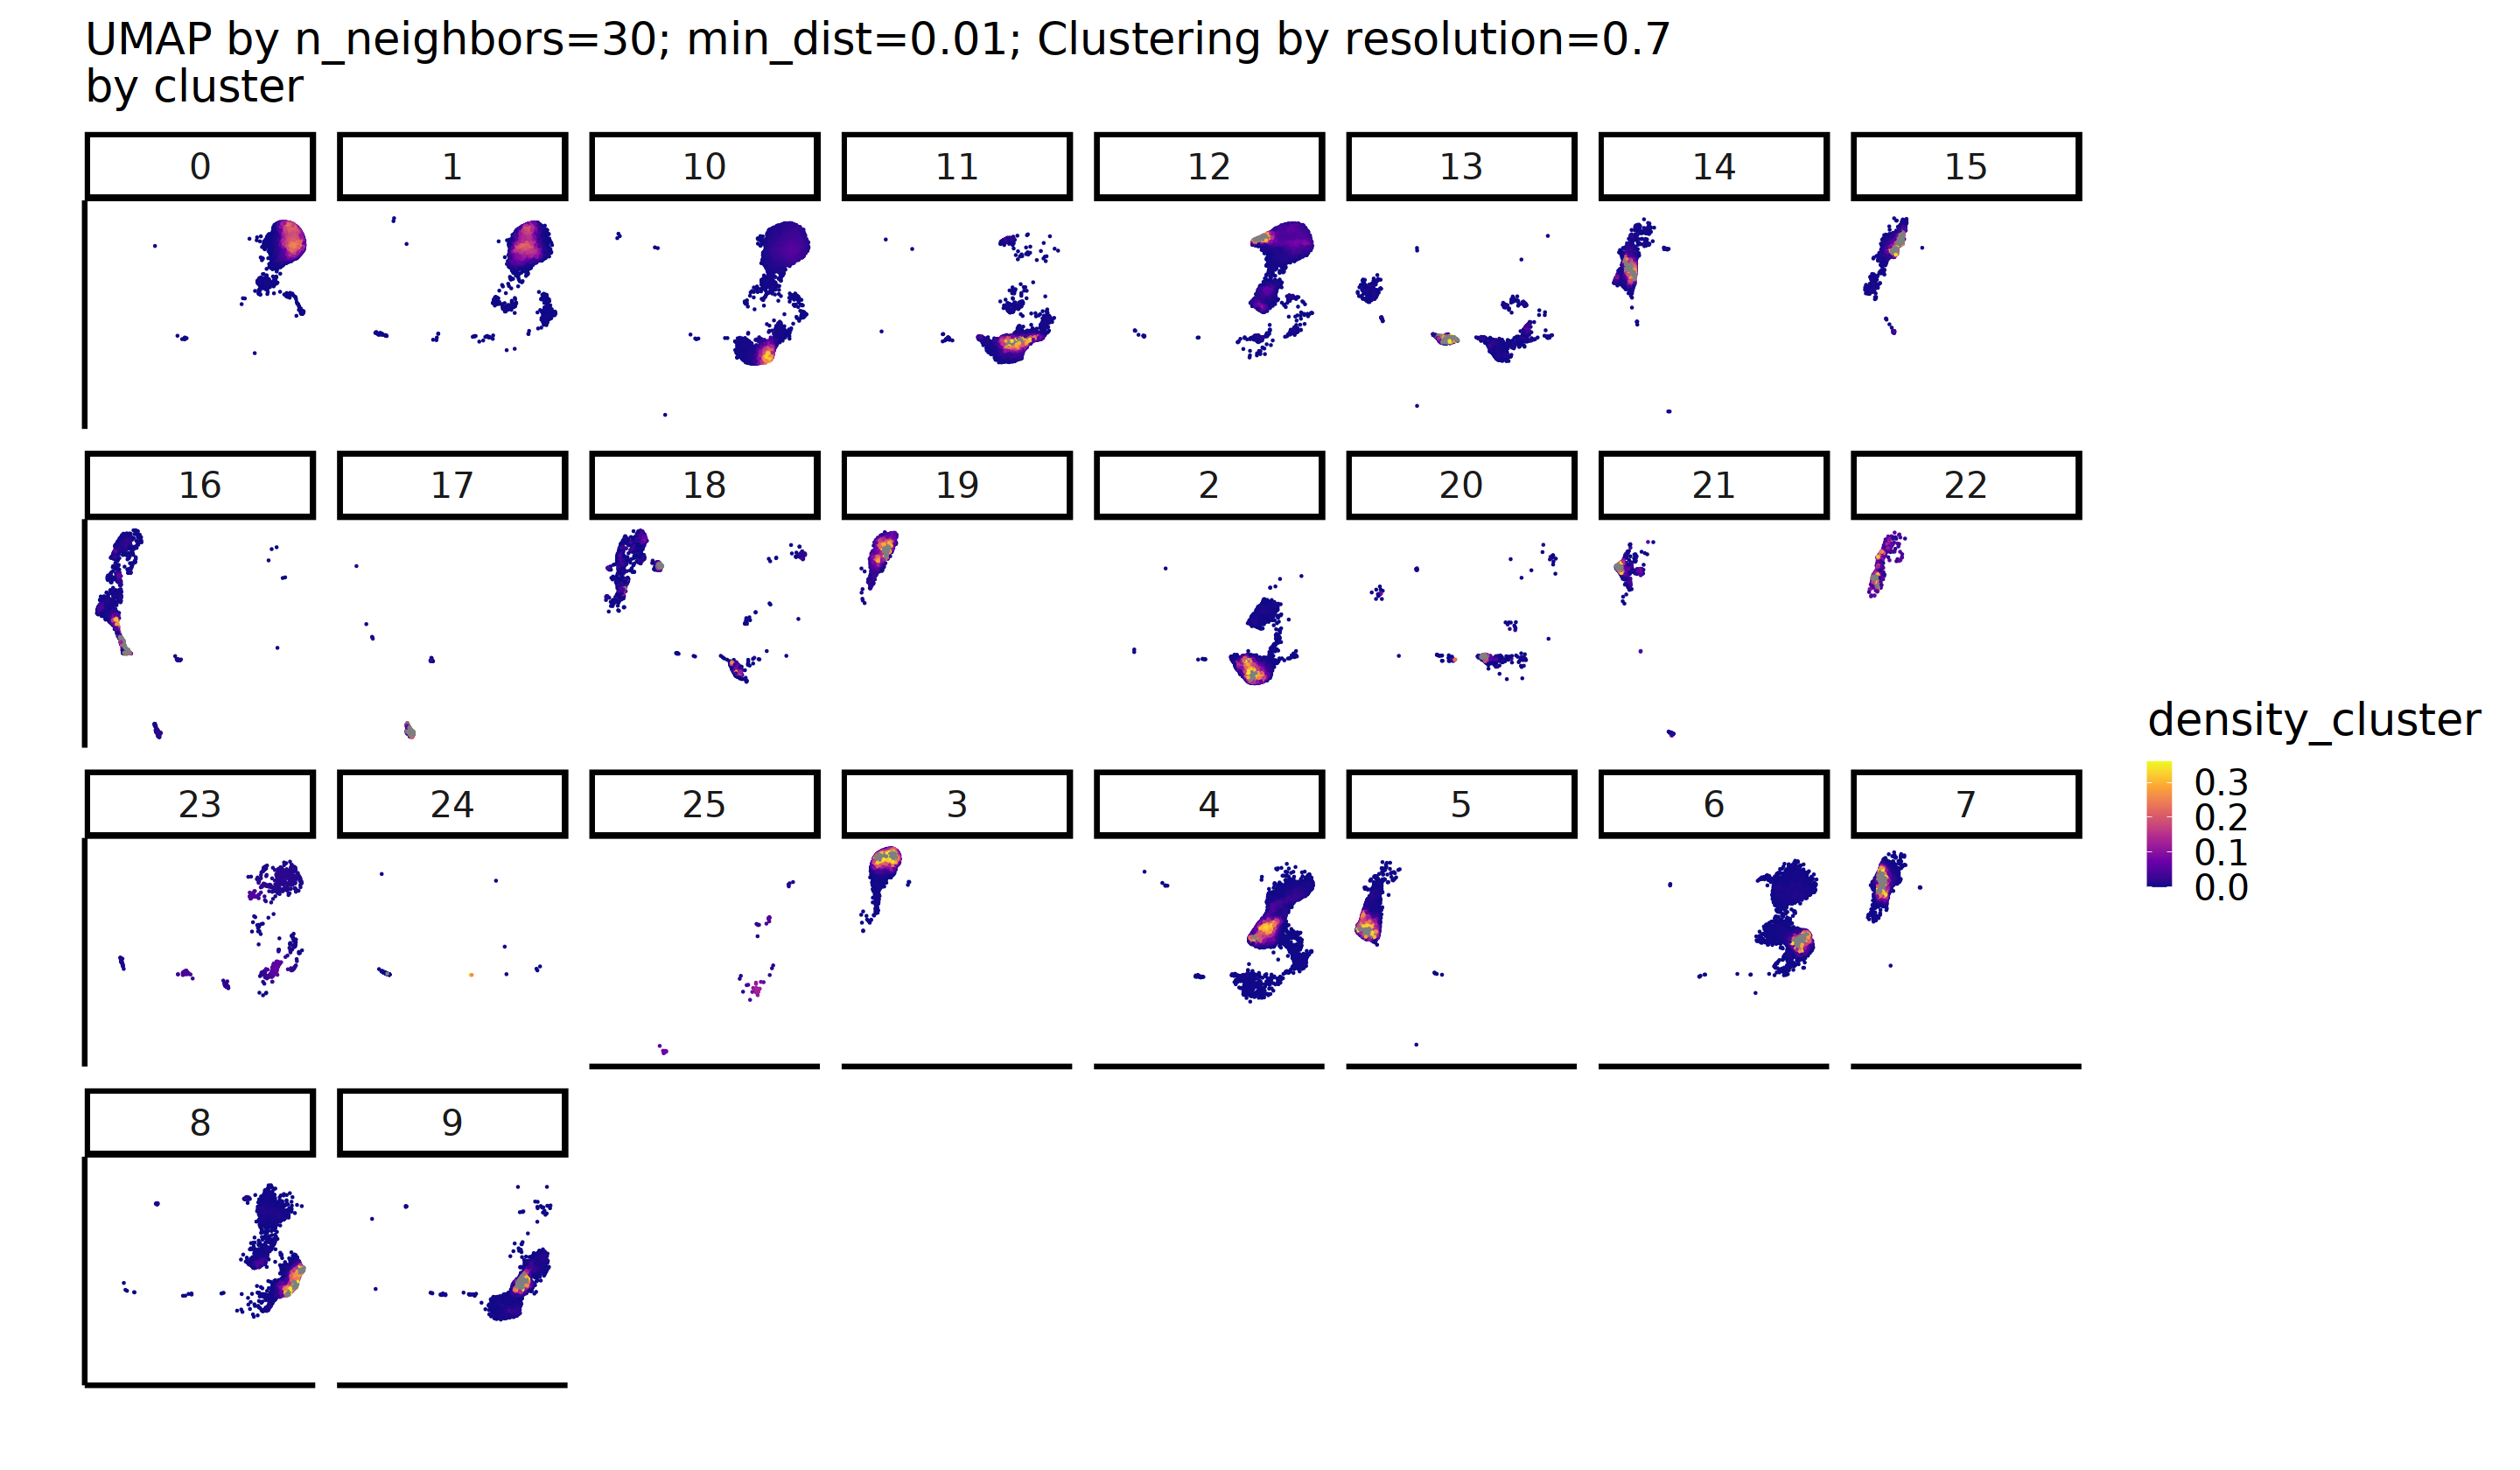

In [12]:
options(repr.plot.height = 3, repr.plot.width = 3)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2"), color = "#4DAF4A",
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#E41A1C",
         "24" = "#377EB8")) +
       labs(
         title = paste0("T"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=15, face = "italic")
       )
)


options(repr.plot.height = 6, repr.plot.width = 5.5)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "Batch"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
         "B1" = "#4DAF4A",
         "B2" = "#984EA3",
         "BB3" = "#FF7F00",
         "C1" = "#FFFF33",
         "C2" = "#A65628")) +
       labs(
         title = paste0("UMAP by n_neighbors=",n_neighbors,"\nmin_dist=",min_dist,"\nClustering by resolution=",resolution_list,"\ncolored by batch"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=15, face = "italic")
       )
)

options(repr.plot.height = 6, repr.plot.width = 26)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_Batch),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma",limits = c(0, quantile(umap_res$density_Batch, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ Batch, ncol = 8) +
       labs(
         title = paste0("UMAP by n_neighbors=",n_neighbors,"; min_dist=",min_dist,"; Clustering by resolution=",resolution_list,"\nby batch"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)
# dev.off()

options(repr.plot.height = 5, repr.plot.width = 16)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_Disease),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma",limits = c(0, quantile(umap_res$density_Disease, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ Disease, ncol = 4) +
       labs(
         title = "",
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)

options(repr.plot.height = 5, repr.plot.width = 13)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_AtRisk),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma",limits = c(0, quantile(umap_res$density_AtRisk, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ AtRisk, ncol = 3) +
       labs(
         title = "",
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)

options(repr.plot.height = 6, repr.plot.width = 6)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_cluster.png"), width = 1400, height = 1400,res=360)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "res_cell"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
         "0" = "#E41A1C",
         "1" = "#377EB8",
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#A6D855",
         "24" = "#E78AC4",
         "25" = "#FC8D63",
         "26" = "brown",
         "27" = "#FEB25C",
         "28" = "#377EB9",
         "29" = "lightgreen",
         "30" = "#FDE1EF"
       )) +
       geom_text_repel(
         data = cluster_center,
         aes(x = UMAP1, y = UMAP2, label = res_cell),
         size = 6, color = "black",
         box.padding = unit(0.02, "lines"),
         point.padding = unit(0.02, "lines")
       ) +
       labs(
         legend.position = "none",
         x = "",
         y = "",
         title = ""
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )
)
# dev.off()


options(repr.plot.height = 6, repr.plot.width = 6)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_cluster.png"), width = 1400, height = 1400,res=360)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "res_cell"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
         "0" = "#E41A1C",
         "1" = "#377EB8",
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#A6D855",
         "24" = "#E78AC4",
         "25" = "#FC8D63",
         "26" = "brown",
         "27" = "#FEB25C",
         "28" = "#377EB9",
         "29" = "lightgreen",
         "30" = "#FDE1EF"
       )) +
       labs(
         legend.position = "none",
         x = "",
         y = "",
         title = ""
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )
)
# dev.off()

options(repr.plot.height = 14, repr.plot.width = 24)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_cluster),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma",limits = c(0, quantile(umap_res$density_cluster, probs = seq(0, 1, 0.1))["70%"])) +
       facet_wrap( ~ res_cell, ncol = 8) +
       labs(
         title = paste0("UMAP by n_neighbors=",n_neighbors,"; min_dist=",min_dist,"; Clustering by resolution=",resolution_list,"\nby cluster"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)


In [13]:
# check expression of markers 
exprs_norm <- readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_arcsinh_transformed_transposed.rds"))
exprs_norm = exprs_norm[, clu_logi]

clu_marker <- presto::wilcoxauc(exprs_norm, umap_res$res_cell)
x <- clu_marker %>%
  dplyr::group_by(group) %>%
  dplyr::top_n(9, wt = logFC) 
x


## parameter	description
## feature	name of feature.
## group	name of group label.
## avgExpr	mean value of feature in group.
## logFC	log fold change between observations in group vs out.
## statistic	Wilcoxon rank sum U statistic.
## auc	area under the receiver operator curve.
## pval	nominal p value, from two-tailed Gaussian approximation of U statistic.
## padj	Benjamini-Hochberg adjusted p value.
## pct_in	Percent of observations in the group with non-zero feature value.
## pct_out	Percent of observations out of the group with non-zero feature value.

feature group avgExpr     logFC         statistic    auc      
1   CCR7    0     2.548211342  1.4034471110 107795125470 0.8669209
2   CD127   0     2.383057007  0.5037443202  80490565264 0.6473294
3   CD20    0     0.026851235 -0.0026784024  60400417260 0.4857583
4   CD27    0     2.460044600  0.7191015920  94884023951 0.7630859
5   CD3     0     2.187344640  0.4333690047  89019193884 0.7159192
6   CD4     0     4.665034574  1.5469164990  92589206394 0.7446303
7   CD45RA  0     0.703393963  0.2261712907  81674796108 0.6568533
8   CD56    0     0.033797391 -0.0029106538  60646879831 0.4877405
9   FoxP3   0     0.746255192  0.0667017058  68003129835 0.5469016
10  CCR7    1     2.112739744  0.8904816936  87443756591 0.7376141
11  CD14    1     0.021763018 -0.0045975779  58706673338 0.4952082
12  CD20    1     0.027898883 -0.0014503979  58520178062 0.4936351
13  CD27    1     2.012051415  0.1976952942  62694360423 0.5288456
14  CD3     1     1.903154445  0.1028067724  65810174514 0.5551284
15  CD4     1     4.392062793  1.2195601605  63964838988 0.5395624
16  CD45RA  1     0.651028665  0.1639876234  74921855259 0.6319881
17  CD56    1     0.036007549 -0.0003438602  58885141466 0.4967137
18  CX3CR1  1     0.007226453 -0.0064260767  58130176171 0.4903453
19  CCR7    10    1.930236857  0.6121375772  22279507223 0.6664036
20  CD127   10    2.024059268  0.0778398959  16759932710 0.5013073
21  CD14    10    0.025559924 -0.0002082303  16466170441 0.4925206
22  CD27    10    2.131523015  0.3013598768  19391958546 0.5800340
23  CD3     10    1.887859521  0.0766443822  18102617374 0.5414684
24  CD4     10    4.490395454  1.1985423809  19971866617 0.5973797
25  CD40L   10    0.196839362  0.0047857850  17467477993 0.5224707
26  CD56    10    0.036719583  0.0004271203  16752328944 0.5010799
27  CXCR3   10    1.727815866  0.7837642568  24616862560 0.7363164
28  CD39    11    0.373062763  0.2611829190  18033421557 0.6282782
29  CD4     11    4.602203377  1.3076576656  19317171030 0.6730035
30  CD45RO  11    1.644022775  0.9170892958  22291361672 0.7766233
... ...     ...   ...         ...           ...          ...      
205 CD45RO  6     1.1573197   0.4282995     36323861260  0.6614275
206 CXCR5   6     2.1063399   1.9176878     53590892122  0.9758459
207 TIGIT   6     0.4502523   0.1037269     31911753162  0.5810867
208 CD127   7     2.1674194   0.2303718     29008133439  0.5732977
209 CD45RO  7     0.8849653   0.1392269     29214479499  0.5773757
210 CD8a    7     5.4419754   4.0686967     45271064707  0.8947075
211 CXCR3   7     2.4754356   1.5863502     43838812121  0.8664014
212 GrzK    7     0.7602990   0.6086146     37308868448  0.7373479
213 NKG2D   7     1.7887967   1.4177334     45959504264  0.9083134
214 TACTILE 7     0.7919363   0.3002933     33606569532  0.6641781
215 TIGIT   7     0.7846379   0.4555719     36012759406  0.7117325
216 Tbet    7     0.5115944   0.1654722     33202684684  0.6561960
217 CD25    8     1.6410522   1.4179581     41316930468  0.9155111
218 CD39    8     0.7590662   0.6700968     33008463302  0.7314100
219 CD4     8     4.3877212   1.1062412     24121631740  0.5344933
220 CD45RO  8     1.2269504   0.4965573     29519168677  0.6540933
221 CTLA4   8     0.3414209   0.2689059     31205455947  0.6914585
222 HLADR   8     0.4321893   0.2323743     26090426235  0.5781183
223 Helios  8     0.8526175   0.4379984     30793665643  0.6823339
224 ICOS    8     1.2406152   0.6217454     30860932398  0.6838244
225 TIGIT   8     1.1087069   0.7922210     36234975517  0.8029038
226 CD127   9     2.0944655   0.1508169     18480485316  0.5363798
227 CD27    9     2.0731780   0.2412812     19244189651  0.5585457
228 CD4     9     4.5259190   1.2366200     21409560100  0.6213936
229 CD45RO  9     1.5707632   0.8468115     26314270687  0.7637485
230 CXCR3   9     2.3619268   1.4411188     29029007187  0.8425414
231 CXCR5   9     2.0924387   1.8606156     33231681288  0.9645203
232 ICOS    9     0.7780880   0.1357464     1994527

In [14]:
## Heatmap of marker genes
# marker_plot <- unique(x$feature)
## marker_plot <- unique(clu_marker$feature)

# same markers for predicted cell types heamtmap
marker_plot <- c('AHR','CCR2','CCR7','CD127','CD16','CD25','CD27','CD39','CD4','CD40L','CD45RA','CD45RO','CD57','CD69','CD8a','CD94','CTLA4','CX3CR1','CXCR3','CXCR5','FoxP3','GrzB','GrzK','HLADR','Helios','ICOS','Ki67','NKG2D','PD1','PU.1','TACTILE','TCRVd1','TCRVd2','TIGIT','Tbet')
                      

exp_heat <- exprs_norm[marker_plot,]
exp_heat <- t(exp_heat)
exp_heat <- as.data.frame(exp_heat)
exp_heat$res_cell <- as.character(umap_res$res_cell)

exp_ave <- aggregate(exp_heat[, 1:(ncol(exp_heat)-1)], list(exp_heat$res_cell), mean)
colnames(exp_ave)[1] <- "res_cell"
exp_ave <- as.data.frame(t(exp_ave))
colnames(exp_ave) <- as.character(t(exp_ave[1,]))
colnames(exp_ave) <- paste0("vT-",colnames(exp_ave))
exp_ave <- exp_ave[-1,]
row_names <- rownames(exp_ave)
exp_ave <- mutate_all(exp_ave, function(x) as.numeric(as.character(x)))
rownames(exp_ave) <- row_names           
                      
# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
  coord <- pheatmap:::find_coordinates(length(coln), gaps)
  x     <- coord$coord - 0.5 * coord$size
  res   <- grid::textGrob(
    coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
    vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
  )
  return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)
exp_ave <- as.matrix(exp_ave)
mat_breaks <- seq(min(exp_ave), max(exp_ave), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}

mat_breaks <- quantile_breaks(exp_ave, n = 20)
scale_rows <- function(x) t(scale(t(x)))
exp_ave_scale <- scale_rows(exp_ave) # Z-score
exp_ave_scale<- na.omit(exp_ave_scale)
mat_breaks <- quantile_breaks(exp_ave_scale, n = 10)
mat_breaks <- seq(min(exp_ave_scale), max(exp_ave_scale), length.out = 24)
mat_breaks <- quantile_breaks(exp_ave_scale, n = 6)
mat_breaks <- seq(min(exp_ave_scale), max(exp_ave_scale), length.out = 24)
exp_ave_scale[exp_ave_scale > 2] <- 2
exp_ave_scale[exp_ave_scale < -2] <- -2
head(exp_ave_scale)
dim(exp_ave_scale)

vT-0       vT-1       vT-10      vT-11      vT-12      vT-13     
AHR   -0.3729320 -0.6172348 -0.1600055  0.4138234 -0.1328639 -0.4841386
CCR2  -0.9067562 -0.9109607 -0.6810556  0.2442937 -0.6938471 -0.2720585
CCR7   2.0000000  1.5558377  1.3162180 -0.3372553  1.5170422 -1.0438045
CD127  0.8636750 -0.1770191  0.3679353 -0.1659144  0.4970627 -0.7945473
CD16  -0.2739596 -0.3688372 -0.3560608 -0.4029709 -0.3211038 -0.3902580
CD25  -0.2094516 -0.4600223 -0.1886108 -0.1082960 -0.1007689 -0.5978402
      vT-14       vT-15       vT-16      vT-17        ... vT-23      vT-24     
AHR   -0.67943473  0.03078538 -0.5791834 -0.816632209 ... -0.2117810  2.0000000
CCR2  -0.30389860  1.56994909 -0.2737875  0.820553885 ... -0.7125167  2.0000000
CCR7  -1.07444827 -0.77440970 -0.5231643 -0.946428700 ...  0.5949300 -1.0986308
CD127 -1.48922911  1.16292632 -0.9740788 -0.029456504 ... -0.7633955 -2.0000000
CD16  -0.03694443 -0.20421061 -0.1657585  0.009089515 ... -0.3043863  2.0000000
CD25  -0.62341075  0.38885046 -0.4845569 -0.364218699 ... -0.3415478 -0.5537094
      vT-25       vT-3        vT-4        vT-5       vT-6       vT-7       
AHR   -0.07380187 -0.50910465  0.85074909 -0.7164178  0.2740350 -0.17267728
CCR2  -0.04351415 -0.65199351  0.20160141 -0.4042647 -0.7934465 -0.15605400
CCR7  -0.17080913  1.56874027  0.05569456 -1.1103551  0.8000917 -0.51778332
CD127  0.82990308  0.25575531  1.18773087 -1.8495682  0.4897928  0.56590119
CD16   0.36099672  0.02345834 -0.37794771  0.1415387 -0.3291220 -0.04559824
CD25   0.18832679 -0.61703726  1.05036377 -0.6391486  0.5059874 -0.32167157
      vT-8        vT-9       
AHR    0.08504871  0.19102134
CCR2  -0.48512278 -0.76008787
CCR7  -0.16555577  0.41216988
CD127 -1.38589157  0.46515919
CD16  -0.36505612 -0.36168964
CD25   2.00000000 -0.01421779

[1] 35 26

Warning message:
“argument `width` is not supported in pheatmap -> Heatmap translation,
skip it.”
Warning message:
“argument `height` is not supported in pheatmap -> Heatmap translation,
skip it.”


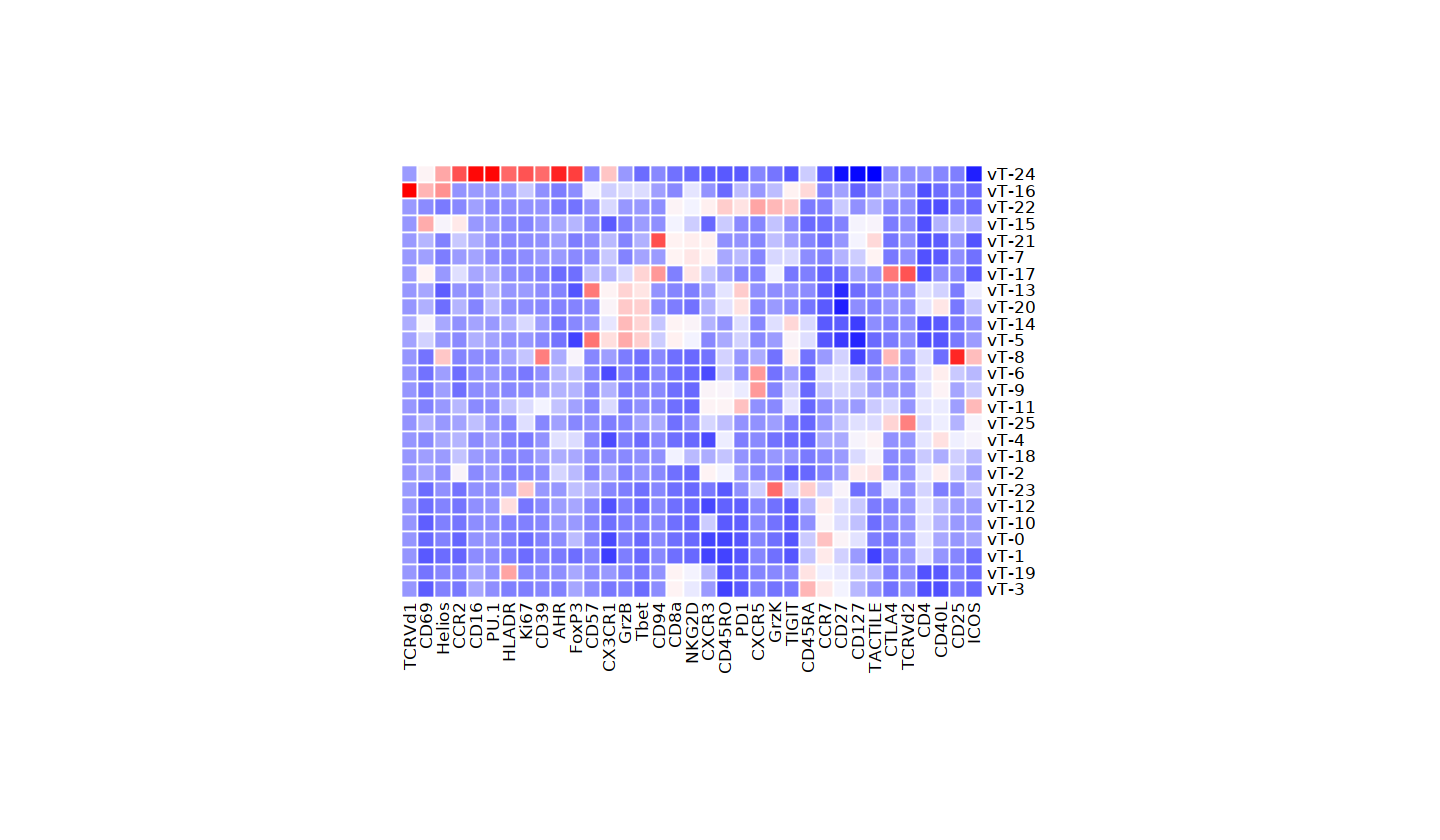

In [16]:

options(repr.plot.height = 7, repr.plot.width = 12)
plot(
    pheatmap(
      mat = scale(t(exp_ave)),
      border_color = "white",
      #breaks  = mat_breaks,
      #color  =inferno(length(mat_breaks) - 1),
      color= colorRampPalette(c("blue", "white", "red"))(length(mat_breaks)),
      show_rownames = TRUE,
      show_colnames = TRUE,
      cluster_rows = TRUE,
      cluster_cols = TRUE,
      show_row_dend = FALSE,show_column_dend = FALSE, 
      fontsize = 10,
      fontsize_row = 10,
      cellwidth = 10, cellheight = 10, 
      width = 7, height=9.1,
      scale = "none",
      legend = FALSE
    )
)


In [17]:
clu_marker %>%
  dplyr::group_by(group) %>%
  dplyr::top_n(3, wt = logFC) 

feature group avgExpr  logFC     statistic    auc       pval         
1   CCR7    0     2.548211 1.4034471 107795125470 0.8669209  0.000000e+00
2   CD27    0     2.460045 0.7191016  94884023951 0.7630859  0.000000e+00
3   CD4     0     4.665035 1.5469165  92589206394 0.7446303  0.000000e+00
4   CCR7    1     2.112740 0.8904817  87443756591 0.7376141  0.000000e+00
5   CD27    1     2.012051 0.1976953  62694360423 0.5288456 1.023154e-253
6   CD4     1     4.392063 1.2195602  63964838988 0.5395624  0.000000e+00
7   CCR7    10    1.930237 0.6121376  22279507223 0.6664036  0.000000e+00
8   CD4     10    4.490395 1.1985424  19971866617 0.5973797  0.000000e+00
9   CXCR3   10    1.727816 0.7837643  24616862560 0.7363164  0.000000e+00
10  CD4     11    4.602203 1.3076577  19317171030 0.6730035  0.000000e+00
11  CD45RO  11    1.644023 0.9170893  22291361672 0.7766233  0.000000e+00
12  CXCR3   11    2.415800 1.4878596  24385948090 0.8495980  0.000000e+00
13  CCR7    12    2.083192 0.7643067  18223920329 0.7025638  0.000000e+00
14  CD4     12    4.560655 1.2612764  16742037451 0.6454347  0.000000e+00
15  HLADR   12    1.628576 1.4552991  24982690710 0.9631262  0.000000e+00
16  CD4     13    4.455267 1.1494814  13863255248 0.6066162  0.000000e+00
17  CD57    13    4.411826 3.9601648  21997681064 0.9625552  0.000000e+00
18  GrzB    13    2.276165 1.8246974  19187946931 0.8396093  0.000000e+00
19  CD8a    14    5.404841 3.9072537  19180069970 0.8807632  0.000000e+00
20  GrzB    14    2.580736 2.1338815  19483658639 0.8947043  0.000000e+00
21  Tbet    14    1.554992 1.2265295  19451244774 0.8932158  0.000000e+00
22  CD127   15    2.599764 0.6626133  12860116451 0.7124517  0.000000e+00
23  CD8a    15    4.695912 3.1709025  14633646597 0.8107054  0.000000e+00
24  NKG2D   15    1.039153 0.6064615  13702999298 0.7591475  0.000000e+00
25  CD57    16    1.987830 1.4704968  10921277056 0.6826715  0.000000e+00
26  NKG2D   16    1.289210 0.8592155  12870902478 0.8045395  0.000000e+00
27  TCRVd1  16    1.128952 1.1081164  10864745425 0.6791378  0.000000e+00
28  CD94    17    2.652889 2.4661731  12809531574 0.9186716  0.000000e+00
29  NKG2D   17    1.793625 1.3687794  12213275765 0.8759095  0.000000e+00
30  TCRVd2  17    5.009982 4.9044604  13868795730 0.9946397  0.000000e+00
... ...     ...   ...      ...       ...          ...       ...          
49  CD4     23    4.093452 0.7633214   897292295  0.4859059  3.780652e-02
50  CD45RA  23    1.300643 0.7936294  1374569901  0.7443635 1.545525e-294
51  GrzK    23    2.089182 1.9098463  1691229078  0.9158422  0.000000e+00
52  CD16    24    1.435202 1.2845300   317286027  0.6928689  1.417743e-55
53  HLADR   24    2.791503 2.5823162   447435965  0.9770820  0.000000e+00
54  PU.1    24    2.052829 1.8196379   424206273  0.9263545 4.804817e-223
55  CD4     25    4.254182 0.9227962    55702338  0.5188198  5.036779e-01
56  CXCR3   25    1.847889 0.8780133    76282784  0.7105091  4.046046e-14
57  TCRVd2  25    4.216693 4.0452971   103733781  0.9661918  7.230112e-83
58  CD45RA  3     1.448054 1.0337710 75228801542  0.8691572  0.000000e+00
59  CD8a    3     5.424433 4.2287838 78445814208  0.9063250  0.000000e+00
60  NKG2D   3     1.325614 0.9706551 74856496084  0.8648557  0.000000e+00
61  CD127   4     2.617727 0.7357215 63131578297  0.7314279  0.000000e+00
62  CD4     4     4.652709 1.4531411 62352504720  0.7224018  0.000000e+00
63  CD45RO  4     1.444112 0.7602927 65639059948  0.7604791  0.000000e+00
64  CD57    5     4.513647 4.2252420 57518660505  0.9815174  0.000000e+00
65  CD8a    5     5.523199 4.1922941 53615294092  0.9149091  0.000000e+00
66  GrzB    5     2.776612 2.4291042 53801874110  0.9180930  0.000000e+00
67  CD4     6     4.539101 1.2787269 34835142978  0.6343192  0.000000e+00
68  CD45RO  6     1.157320 0.4282995 36323861260  0.6614275  0.000000e+00
69  CXCR5   6     2.106340 1.9176878 53590892122  0.9758459  0.000000e+00
70  CD8a    7     5.441975 4.0686967 45271064707  0.8947075  0.000000e+00
71  CXCR

In [ ]:
# mapping validation dataset to reference using symphony

In [2]:
reference = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_harmonyObj_embeddings_refSymphony_Prop",prop,"_Nmin",n_min,"_topVar",frac,".rds"))
query = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_mapped_to_reference.rds"))


In [3]:
head(query$meta_data)
head(reference$meta_data)


subject_id Batch Disease age sex  Location cluster cell_id cell_type_pred_knn
1 01-128-99  C2    CCP+    74  Male Colorado 17      1       13                
2 01-128-99  C2    CCP+    74  Male Colorado 5       2       8                 
3 01-128-99  C2    CCP+    74  Male Colorado 1       3       0                 
4 01-128-99  C2    CCP+    74  Male Colorado 4       4       6                 
5 01-128-99  C2    CCP+    74  Male Colorado 2       5       1                 
6 01-128-99  C2    CCP+    74  Male Colorado 0       6       2                 
  cell_type_pred_knn_prob
1 0.7666667              
2 0.3333333              
3 0.4666667              
4 0.5666667              
5 0.4000000              
6 0.3333333

UMAP1    UMAP2     disease batch res_cell subject_id time_point AtRisk 
6  7.370950 -4.017954 Control 15    0        200_0272   V0         Control
12 6.883081 -4.111760 Control 15    0        200_0272   V0         Control
13 7.510664 -2.762509 Control 15    0        200_0272   V0         Control
24 5.863854 -4.665978 Control 15    0        200_0272   V0         Control
34 5.526290 -4.588978 Control 15    0        200_0272   V0         Control
36 6.535573 -4.470250 Control 15    0        200_0272   V0         Control
   age_at_biopsy sex ... CCP     CCP30_titer CCP31_titer RF RF_IgM_titer
6  28            1   ... Control NA          NA          NA NA          
12 28            1   ... Control NA          NA          NA NA          
13 28            1   ... Control NA          NA          NA NA          
24 28            1   ... Control NA          NA          NA NA          
34 28            1   ... Control NA          NA          NA NA          
36 28            1   ... Control NA          NA          NA NA          
   RF_IgG_titer RF_IgA_titer Site Race                         
6  NA           NA           OMRF [American Indian_Alaska tive]
12 NA           NA           OMRF [American Indian_Alaska tive]
13 NA           NA           OMRF [American Indian_Alaska tive]
24 NA           NA           OMRF [American Indian_Alaska tive]
34 NA           NA           OMRF [American Indian_Alaska tive]
36 NA           NA           OMRF [American Indian_Alaska tive]
   OmiqFileIndex                 
6  T cell_Control_200-0272-V0.fcs
12 T cell_Control_200-0272-V0.fcs
13 T cell_Control_200-0272-V0.fcs
24 T cell_Control_200-0272-V0.fcs
34 T cell_Control_200-0272-V0.fcs
36 T cell_Control_200-0272-V0.fcs

In [4]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$cell_type_pred_knn_prob = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
## cell_type_pred_knn: predicted corresponding clusters with reference
## cluster: de novo clusters in query
meta_que_cols = c("subject_id","Batch","Disease","age",         "sex","Location","cell_type_pred_knn", "cell_type_pred_knn_prob","ref_query")
meta_ref_cols = c("subject_id","batch","AtRisk","age_at_biopsy","sex","Site",    "res_cell",           "cell_type_pred_knn_prob","ref_query")


meta_data_combined = rbind(query$meta_data[,meta_que_cols] %>% magrittr::set_colnames(meta_ref_cols), reference$meta_data[,meta_ref_cols])
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)


In [5]:
umap_combined_labels$res_cell
set.seed(1234)
umap_combined_labels = umap_combined_labels[sample(1:nrow(umap_combined_labels),nrow(umap_combined_labels)),]
umap_combined_labels$res_cell

[1] 13 8  0  6  1  2  6  14 6  18 8  9  9  9  3  7  11 3  11 0  5  4  8  7 
   [25] 6  8  8  0  0  9  5  8  0  8  6  2  6  7  5  0  5  5  7  9  5  5  0  5 
   [49] 6  2  15 8  2  4  11 12 8  7  6  15 1  6  5  19 9  5  1  2  5  10 0  5 
   [73] 8  5  4  5  5  1  0  4  6  5  5  10 1  11 14 9  2  11 11 0  2  1  7  2 
   [97] 6  11 1  3  4  1  9  1  4  12 7  12 4  7  6  0  7  1  5  1  8  1  7  8 
  [121] 6  17 7  12 5  11 1  10 1  4  10 2  11 2  5  1  8  0  6  0  12 0  9  5 
  [145] 5  6  2  2  17 14 5  16 6  5  5  14 0  10 5  6  6  5  14 10 14 5  9  14
  [169] 7  5  9  1  1  7  5  5  12 5  1  1  1  5  5  0  5  9  7  10 0  9  9  6 
  [193] 2  14 0  6  7  0  9  0  7  7  18 5  11 8  12 10 0  8  9  2  5  9  6  6 
  [217] 0  12 0  0  1  12 0  9  1  1  5  4  0  5  5  3  9  6  9  0  7  11 7  10
  [241] 0  0  8  4  0  7  5  6  6  0  7  2  16 9  6  2  7  6  3  9  1  8  14 17
  [265] 4  5  5  3  0  9  8  10 9  11 8  5  5  6  11 7  5  5  7  1  5  8  6  0 
  [289] 5  4  3  11 5  5  10 4  0  1  6  4  4  11 5  7  0  8  0  10 3  5  0  2 
  [313] 5  6  3  10 12 14 7  17 9  0  5  1  5  1  9  1  9  14 15 12 5  5  5  4 
  [337] 10 4  1  5  5  1  0  8  10 9  7  6  14 5  5  2  1  0  6  6  5  5  1  11
  [361] 1  14 5  8  7  4  15 6  0  0  6  0  3  15 7  9  1  7  1  10 5  5  4  8 
  [385] 1  7  17 6  7  1  7  5  6  2  5  15 5  14 2  5  6  1  1  6  18 5  4  8 
  [409] 5  9  5  0  8  7  7  6  5  4  6  6  5  11 9  1  5  6  1  14 2  15 6  5 
  [433] 14 1  9  1  6  1  0  7  5  2  10 6  2  9  5  8  5  5  2  13 1  8  6  8 
  [457] 5  14 6  4  9  5  2  14 1  8  1  8  5  5  6  6  10 11 8  9  5  6  6  6 
  [481] 7  5  4  5  11 14 6  5  0  14 8  9  4  9  8  12 5  5  1  5  12 4  5  11
  [505] 7  6  5  1  6  14 2  6  1  14 0  4  11 14 8  2  9  9  1  17 5  11 9  1 
  [529] 4  6  0  12 14 6  5  5  12 0  6  7  11 10 6  9  0  9  10 9  11 12 6  12
  [553] 0  0  5  9  6  1  8  5  5  7  3  1  8  5  5  7  14 11 17 5  1  5  2  14
  [577] 9  12 7  1  17 2  5  7  4  9  6  6  0  2  2  5  5  6  5  4  5  5  0  4 
  [601] 5  1  5  9  5  1  0  12 7  6  9  7  9  5  8  10 7  0  6  7  6  4  2  8 
  [625] 3  8  1  5  11 6  7  10 5  5  9  9  12 8  1  5  5  8  9  6  5  8  0  17
  [649] 9  4  8  8  2  0  5  7  5  3  6  5  6  9  4  5  11 5  9  0  10 11 6  5 
  [673] 6  4  6  5  1  8  6  8  1  7  5  10 6  16 9  2  8  9  17 1  0  5  6  7 
  [697] 7  6  8  14 19 7  1  7  11 6  2  9  5  13 0  9  2  6  0  0  11 9  11 3 
  [721] 0  0  5  10 4  6  6  5  6  0  9  5  6  12 5  8  9  0  9  2  1  8  7  16
  [745] 5  14 8  5  10 1  0  5  1  5  15 9  10 0  5  5  9  5  5  9  14 7  9  10
  [769] 5  5  9  1  1  11 6  12 12 3  5  0  5  0  5  6  0  14 6  8  5  6  9  6 
  [793] 8  4  4  9  11 7  11 17 5  9  1  19 9  2  5  1  4  8  9  7  0  2  1  0 
  [817] 11 1  6  0  6  16 0  3  2  0  5  5  5  11 2  3  9  2  4  0  8  11 5  0 
  [841] 7  7  6  7  12 2  9  5  5  0  5  5  1  0  7  14 5  8  1  1  7  4  9  4 
  [865] 7  5  7  1  6  0  5  5  2  6  8  4  12 8  11 14 7  6  5  11 14 7  9  8 
  [889] 6  5  14 5  1  6  7  5  0  10 5  6  5  7  6  5  5  0  18 12 5  2  1  8 
  [913] 0  9  6  9  0  7  1  5  12 8  9  0  11 11 1  6  3  1  1  5  10 10 4  6 
  [937] 7  9  7  9  11 6  6  1  1  6  5  11 1  11 6  10 11 8  8  14 11 4  0  6 
  [961] 9  1  6  1  5  0  4  2  10 5  14 12 6  6  14 5  5  14 7  9  13 5  9  0 
  [985] 7  5  11 5  9  4  5  6  9  2  11 2  7  11 5  5  9  1  12 4  5  11 0  6 
 [1009] 0  4  1  2  9  0  9  1  14 0  2  5  6  9  9  8  0  1  1  9  9  2  6  5 
 [1033] 9  2  14 9  10 1  0  18 5  7  4  6  0  2  6  6  7  14 6  4  0  8  5  4 
 [1057] 9  3  2  4  9  5  1  9  14 12 0  2  4  12 1  16 5  14 8  11 6  9  5  6 
 [1081] 1  14 1  9  6  1  10 14 8  0  9  5  5  10 7  1  9  4  6  11 5  5  2  5 
 [1105] 11 1  15 4  5  9  11 0  5  6  6  10 0  2  5  2  0  5  4  6  6  0  8  6 
 [1129] 14 1  12 2  0  2  2  9  2  6  1  5  3  9  4  1  5  7  11 14 4  7  0  14
 [1153] 5  6  11 11 0  0  5  0  14 14 11 1  3  14 1  0  15 0  11 5  0  7  0  6 
 [1177] 6  12 5  9  5  15 0  6  9  6  2  6  12 12 14 0  0  6  4  1  7  6  12 1 
 [12

[1] 13 3  8  5  2  2  1  0  3  3  0  1  0  9  14 1  5  0  6  1  3  2  6  4 
   [25] 9  2  11 4  2  1  5  5  11 0  11 6  0  12 2  3  13 10 16 4  1  2  0  9 
   [49] 3  11 1  4  1  0  1  5  9  11 1  6  16 2  0  6  3  0  1  2  9  5  5  5 
   [73] 5  1  2  11 5  8  15 1  9  10 6  5  0  8  3  0  0  1  8  6  6  6  8  6 
   [97] 5  6  17 2  1  6  0  3  7  3  3  3  6  0  1  17 19 10 0  5  1  1  4  4 
  [121] 0  7  13 5  2  5  5  6  6  3  16 5  7  15 12 0  0  2  1  3  18 1  2  4 
  [145] 5  3  0  2  4  3  0  7  0  1  15 0  4  2  1  8  9  8  1  12 0  9  12 3 
  [169] 7  1  0  7  8  7  2  5  6  5  11 0  8  0  12 2  8  3  9  11 5  0  5  18
  [193] 4  0  7  17 1  2  8  4  13 0  16 12 16 8  8  19 0  6  4  9  16 8  3  2 
  [217] 16 5  3  0  11 4  6  1  14 4  2  2  8  7  0  14 5  1  1  2  0  9  19 7 
  [241] 6  8  4  2  6  0  1  0  0  2  4  15 1  5  3  12 0  0  0  6  7  15 7  5 
  [265] 7  9  0  0  2  2  13 4  2  8  8  4  15 16 19 16 5  4  9  3  11 1  7  2 
  [289] 5  1  5  19 2  0  0  5  5  17 11 3  1  2  5  1  13 8  4  5  7  14 4  7 
  [313] 3  12 2  3  11 0  4  9  0  14 2  2  6  1  9  2  5  16 0  14 14 12 1  2 
  [337] 5  8  0  6  2  16 11 0  2  1  2  6  3  4  8  5  5  2  16 8  2  0  4  0 
  [361] 7  3  12 12 11 1  4  9  2  8  2  5  0  2  3  2  0  0  11 6  13 5  11 7 
  [385] 10 6  1  1  8  1  17 2  0  4  1  1  2  11 17 2  9  5  20 11 4  9  2  9 
  [409] 0  6  12 9  7  2  9  2  17 10 8  1  7  10 6  12 12 4  0  2  4  1  2  0 
  [433] 11 4  8  0  8  4  9  0  9  9  6  0  7  10 10 15 8  11 4  4  3  11 7  5 
  [457] 8  11 2  2  1  4  5  12 5  15 19 5  7  0  15 8  10 4  0  3  1  2  2  14
  [481] 3  5  0  8  3  7  9  6  5  16 15 8  2  2  0  4  14 0  0  8  7  13 6  9 
  [505] 9  6  6  14 4  15 3  5  13 7  6  8  0  1  2  0  3  9  5  3  9  4  3  4 
  [529] 13 2  19 7  4  11 0  5  4  0  7  14 5  3  3  5  16 5  5  11 3  8  2  3 
  [553] 4  8  0  4  3  2  1  12 6  0  3  0  1  8  7  0  9  7  0  2  3  8  1  5 
  [577] 0  0  10 0  5  7  4  5  11 14 6  4  9  4  2  17 6  5  5  5  0  9  10 7 
  [601] 4  3  3  2  9  7  0  1  7  4  4  12 12 0  1  11 18 6  1  1  4  7  8  6 
  [625] 0  0  8  0  3  2  7  12 4  15 8  5  17 1  0  14 0  5  12 2  5  0  7  16
  [649] 5  9  0  2  6  13 7  6  0  11 11 0  11 2  1  7  14 0  2  2  8  7  6  11
  [673] 15 3  11 10 3  5  13 2  10 13 11 6  3  8  13 2  1  6  2  0  1  10 0  0 
  [697] 4  10 14 6  0  1  1  15 2  4  16 0  0  12 4  9  0  3  14 4  15 8  12 11
  [721] 4  3  1  6  3  0  19 9  1  8  0  3  9  13 8  7  4  2  8  8  8  12 3  13
  [745] 5  7  2  0  9  6  5  2  2  10 3  2  8  0  2  1  0  1  10 9  0  7  1  11
  [769] 0  13 8  8  4  8  8  2  2  7  7  7  0  9  16 7  0  0  1  12 12 16 4  7 
  [793] 8  5  8  0  8  13 6  0  9  7  2  0  4  18 0  7  1  4  8  0  9  0  5  10
  [817] 0  3  2  6  3  4  16 9  14 3  13 4  5  5  2  0  4  0  17 8  11 8  6  9 
  [841] 7  10 8  4  6  0  5  0  3  0  1  11 6  8  8  4  11 14 10 6  5  11 1  0 
  [865] 14 1  6  1  9  2  14 3  0  2  2  7  4  1  6  4  4  15 0  1  9  3  0  6 
  [889] 6  4  4  3  11 8  2  10 3  2  9  0  0  1  6  10 2  6  11 13 0  8  8  0 
  [913] 0  7  6  8  15 1  5  2  2  11 6  5  6  2  0  3  7  15 0  0  2  1  9  3 
  [937] 3  5  4  9  4  5  0  5  0  2  2  10 0  8  16 11 4  1  12 5  10 3  12 8 
  [961] 12 0  9  5  0  8  0  5  8  11 8  5  2  5  0  8  5  2  3  6  6  3  8  5 
  [985] 11 11 1  2  2  16 2  8  1  0  9  7  3  2  0  4  2  14 9  6  7  6  4  5 
 [1009] 0  11 5  5  7  4  2  8  1  4  6  0  1  14 7  9  8  6  0  0  8  3  4  9 
 [1033] 16 9  1  4  2  4  9  14 4  2  2  5  5  4  3  7  21 12 2  2  4  7  17 9 
 [1057] 6  2  4  4  11 16 19 7  0  1  4  3  5  0  7  19 9  7  12 15 1  5  14 14
 [1081] 11 4  5  9  0  2  8  0  11 7  3  5  4  10 7  2  0  1  6  15 0  1  7  4 
 [1105] 7  8  5  3  4  1  5  0  11 15 0  2  10 11 0  5  4  4  6  6  3  12 9  6 
 [1129] 0  9  5  3  0  0  6  8  0  2  12 1  6  6  14 0  6  1  8  8  0  11 1  0 
 [1153] 3  9  3  1  7  15 12 0  2  4  0  7  4  11 0  4  5  9  2  3  7  5  4  6 
 [1177] 0  5  4  1  3  18 14 1  5  5  2  4  6  4  8  14 4  0  4  3  3  0  2  0 
 [12

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


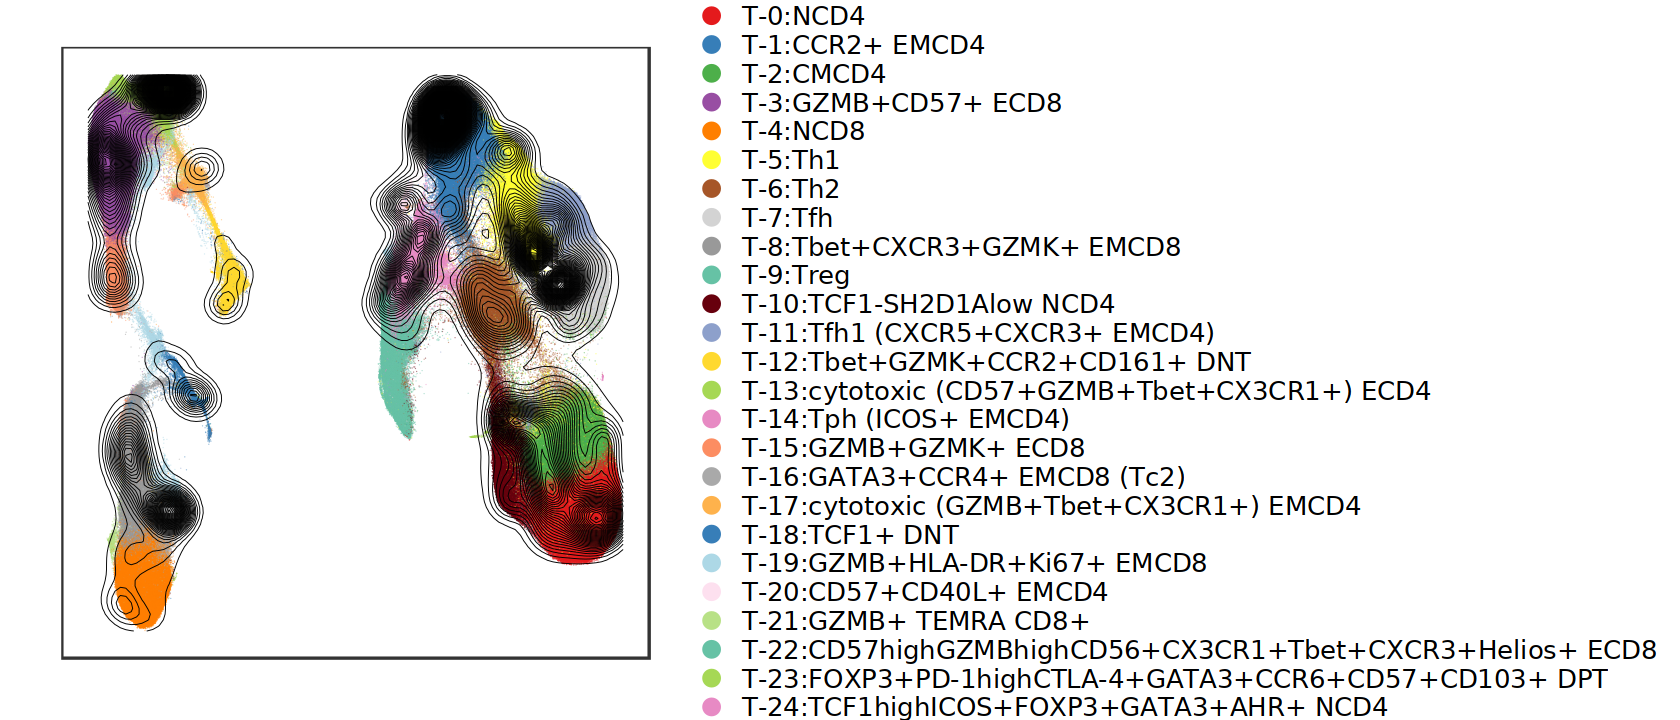

In [6]:
options(repr.plot.height = 6, repr.plot.width = 14)
plot(ggplot() +
       geom_point(
         data = umap_combined_labels %>% dplyr::mutate(res_cell = factor(res_cell,levels=cluster_df$cluster)) %>% dplyr::filter(ref_query=="reference"),
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "res_cell"),
         size = 0.1, stroke = 0, shape = 16, alpha = 0.5
       ) +
       stat_density_2d(data = umap_combined_labels %>% dplyr::mutate(res_cell = factor(res_cell,levels=cluster_df$cluster)) %>% dplyr::filter(ref_query=="query"), 
                       mapping = aes(x = UMAP1, y = UMAP2),
                       colour = "black",
                       binwidth = 0.001,
                       linewidth = 0.2) +
       scale_colour_manual(labels = paste0("T-",cluster_df$cluster,":",cluster_df$clu_name),
                           values = c(
                             "0" = "#E41A1C",
                             "1" = "#377EB8",
                             "2" = "#4DAF4A",
                             "3" = "#984EA3",
                             "4" = "#FF7F00",
                             "5" = "#FFFF33",
                             "6" = "#A65628",
                             "7" = "lightgrey",
                             "8" = "#999999",
                             "9" = "#66C2A5",
                             "10" = "#67000D",
                             "11" = "#8DA0CB",
                             "12" = "#FFD92F",
                             "13" = "#A6D854",
                             "14" = "#E78AC3",
                             "15" = "#FC8D62",
                             "16" = "darkgrey",
                             "17" = "#FEB24C",
                             "18" = "#377EB8",
                             "19" = "lightblue",
                             "20" = "#FDE0EF",
                             "21" = "#B8E186",
                             "22" = "#66C2A5",
                             "23" = "#A6D855",
                             "24" = "#E78AC4",
                             "25" = "#FC8D63",
                             "26" = "brown",
                             "27" = "#FEB25C",
                             "28" = "#377EB9",
                             "29" = "lightgreen",
                             "30" = "#FDE1EF"
                           )) +
       labs(
         x = "",
         y = "",
         title = ""
       ) +
       theme_bw(base_size = 19) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=10)
       ) + guides(colour = guide_legend(override.aes = list(size=5, alpha = 1),
                                        title = "",
                                        ncol = 1))
)

png 
  2

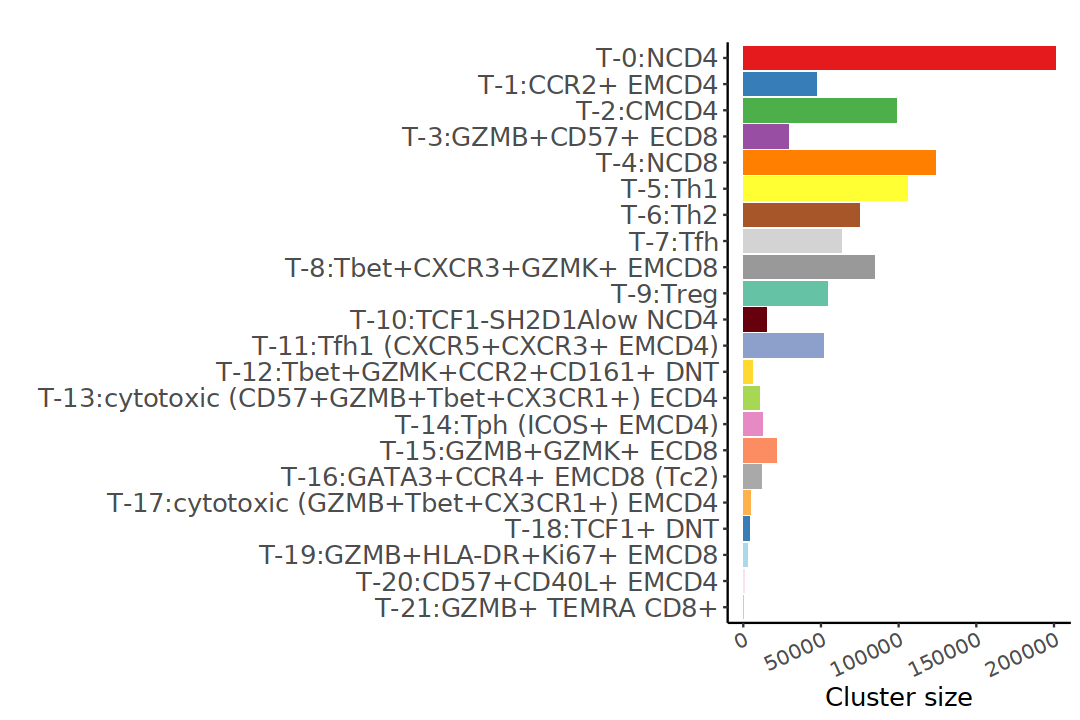

In [7]:
ord = umap_combined_labels %>% 
    dplyr::mutate(res_cell = factor(res_cell,levels=cluster_df$cluster)) %>% 
    dplyr::filter(ref_query=="query") %>%
    .$res_cell %>%
    unique() %>% sort() %>% rev()

options(repr.plot.height = 6, repr.plot.width = 9)
umap_combined_labels %>% 
    dplyr::mutate(res_cell = factor(res_cell,levels=ord)) %>% 
    dplyr::filter(ref_query=="query") %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    ggplot(., aes(y=res_cell, x=count, fill = res_cell)) + 
  geom_bar(stat = "identity", position=position_dodge()) +
       scale_fill_manual(labels = paste0("T-",cluster_df$cluster,":",cluster_df$clu_name),
                           values = c(
                             "0" = "#E41A1C",
                             "1" = "#377EB8",
                             "2" = "#4DAF4A",
                             "3" = "#984EA3",
                             "4" = "#FF7F00",
                             "5" = "#FFFF33",
                             "6" = "#A65628",
                             "7" = "lightgrey",
                             "8" = "#999999",
                             "9" = "#66C2A5",
                             "10" = "#67000D",
                             "11" = "#8DA0CB",
                             "12" = "#FFD92F",
                             "13" = "#A6D854",
                             "14" = "#E78AC3",
                             "15" = "#FC8D62",
                             "16" = "darkgrey",
                             "17" = "#FEB24C",
                             "18" = "#377EB8",
                             "19" = "lightblue",
                             "20" = "#FDE0EF",
                             "21" = "#B8E186",
                             "22" = "#66C2A5",
                             "23" = "#A6D855",
                             "24" = "#E78AC4",
                             "25" = "#FC8D63",
                             "26" = "brown",
                             "27" = "#FEB25C",
                             "28" = "#377EB9",
                             "29" = "lightgreen",
                             "30" = "#FDE1EF"
                           )) + 
  scale_y_discrete(labels=paste0("T-",
                                 cluster_df %>%
                                   magrittr::set_rownames(cluster_df$cluster) %>%
                                   .[ord,] %>% .$cluster,
                                 ":",
                                 cluster_df %>%
                                   magrittr::set_rownames(cluster_df$cluster) %>%
                                   .[ord,] %>% .$clu_name)
  ) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 12, angle = 25, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "Cluster size")


[1] 1022615      12

     0      1     10     11     12     13     14     15     16     17     18 
141047 133305  33811  28884  26028  22859  21758  17967  15891  13822   7728 
    19      2     20     21     22     23     24     25      3      4      5 
  4977 103346   4693   4686   2458   1809    448    105  93119  92831  60937 
     6      7      8      9 
 56865  52138  46221  34882 


22 x 26 Matrix of class "dgeMatrix"
                                              
                                                 vT-0   vT-1    vT-2    vT-3
  T-0:NCD4                                      2.862  2.392  -9.018  -9.236
  T-1:CCR2+ EMCD4                              -4.840 -4.775   3.042  -9.200
  T-2:CMCD4                                     1.618  1.582  -4.962 -10.001
  T-3:GZMB+CD57+ ECD8                          -9.177 -9.112  -8.823  -8.708
  T-4:NCD8                                     -9.639 -9.062 -10.378   7.589
  T-5:Th1                                      -4.754 -4.989   3.668 -10.084
  T-6:Th2                                      -2.024 -1.975  -0.809  -9.701
  T-7:Tfh                                      -4.751 -3.852  -4.450  -8.414
  T-8:Tbet+CXCR3+GZMK+ EMCD8                   -6.070 -5.843  -4.452  -2.171
  T-9:Treg                                     -1.501 -1.292  -2.495  -8.251
  T-10:TCF1-SH2D1Alow NCD4                     -1.384  2.534  -2.858  

Warning message:
“argument `filename` is not supported in pheatmap -> Heatmap
translation, skip it.”


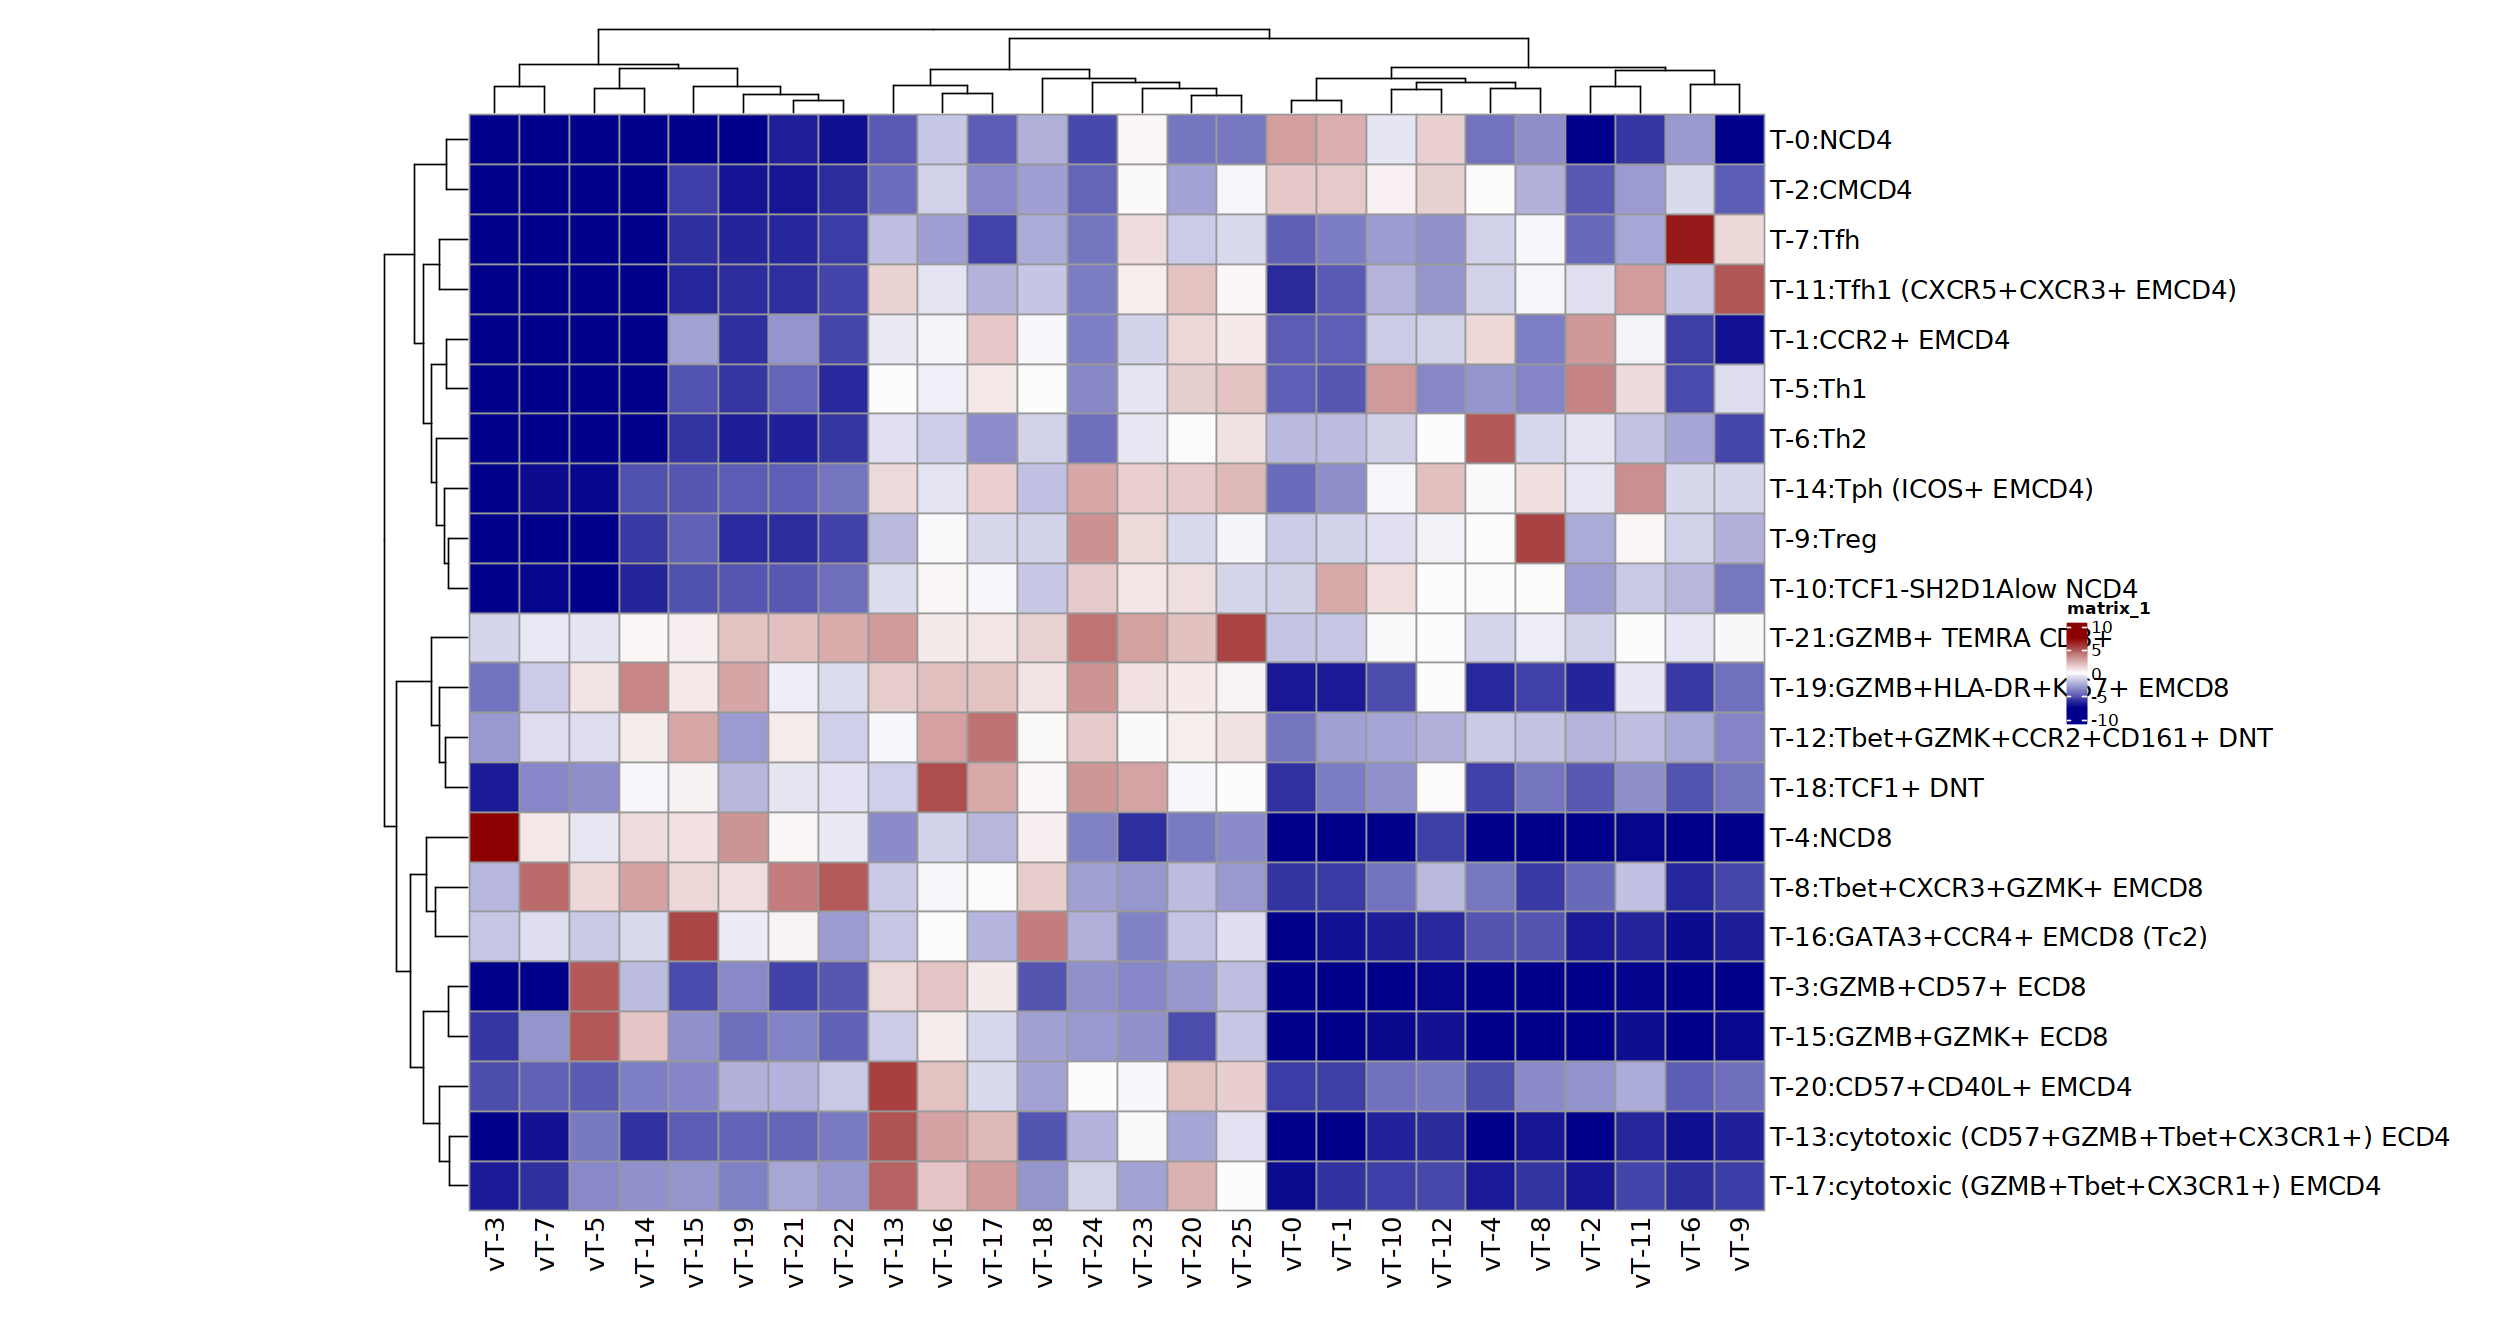

In [8]:
# Cell state mappings heatmap
res = merge(query$meta_data,cluster_df,by.x="cell_type_pred_knn",by.y="cluster")
# remove clusters less than cut off
min_cell_cluster = 30
clu = res %>%
    dplyr::group_by(cluster) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$cluster %>%
    unique()
clu_logi = res$cluster %in% clu
print(dim(res[clu_logi,]))
print(table(res[clu_logi,]$cluster))
res = res[clu_logi,]
res$cluster_val = res$cluster
res$cluster_val = factor(res$cluster_val,levels=sort(as.integer(unique(res$cluster_val))))
res$cluster = paste0("vT-",res$cluster)
res$cluster = factor(res$cluster,levels=paste0("vT-",sort(unique(res$cluster_val))))
res$clu_name = paste0("T-",res$cell_type_pred_knn,":",res$clu_name)
res$clu_name = factor(res$clu_name,levels=intersect(paste0("T-",cluster_df$cluster,":",cluster_df$clu_name), unique(res$clu_name)))

t = table(res$clu_name, res$cluster)
tpseudo = t %>% Matrix() + 0.5 # Add pseudocount
or = tpseudo # initialize results (same dimensions as t)
for (i in 1:ncol(tpseudo)) { # for each phase 1 cluster
    for (j in 1:nrow(t)) {   # for each phase 2 cluster 
        a = tpseudo[j, i]
        b = sum(tpseudo[j, -i])
        c = sum(tpseudo[-j, i])
        d = sum(tpseudo[-j, -i])
        
        or[j, i] = (a/b) / (c/d)
    }
}
round(log(or), 3)

options(repr.plot.height = 11, repr.plot.width = 21)
range <- max(log(or))

pheatmap(as.matrix(log(or)), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
         fontsize = 15, cellheight = 30, cellwidth = 30, 
         filename = '/projects/jinamo@xsede.org/matching_heatmap.pdf')

In [ ]:
# CNA; covarying neighborhood analysis

In [9]:
obj = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_SeuratObj_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))


In [10]:
query = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_mapped_to_reference.rds"))
# umap_res = data.frame(query$umap) #reference mapping UMAP 
umap_res <- readRDS(file=paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_umap_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds")) # de novo UMAP
umap_res$res_cell = query$meta_data$cell_type_pred_knn

# merge meta data to Seurat object 
obj@meta.data$sex <- as.numeric(factor(obj@meta.data$sex, c('Female', 'Male')))
obj@meta.data$Batch <- as.numeric(factor(obj@meta.data$Batch))
obj@meta.data$Disease = factor(obj@meta.data$Disease, levels = c('Control', 'FDR', 'CCP+', 'EarlyRA'))
obj@meta.data$Location_val = as.numeric(factor(obj@meta.data$Location, levels = c('Colorado', 'BWH')))
obj@meta.data$AtRisk = dplyr::case_when(
  obj@meta.data$Disease == "FDR" | obj@meta.data$Disease == "CCP+" ~ "AtRiskRA",
  obj@meta.data$Disease == "Control" ~ "Control",
  obj@meta.data$Disease == "EarlyRA" ~ "RA")
obj@meta.data$cell_type_pred_knn = query$meta_data$cell_type_pred_knn
obj@meta.data$cell_type_pred_knn_prob = query$meta_data$cell_type_pred_knn_prob


# only matched clusters with prob>0.6 in refernce data
prob=0

In [11]:
# Control and AtRiskRA 
logi = (obj$AtRisk %in% c("Control","AtRiskRA")) & (obj$cell_type_pred_knn_prob > prob)
obj_sub = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_SeuratObj_Control_AtRiskRA_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_symphony.rds"))


cluster   size   model.pvalue conditionAtRiskRA.OR
cluster0  cluster0  161327 0.36362475   0.8625219           
cluster1  cluster1   36513 0.80747391   0.9748007           
cluster10 cluster10  12537 0.13359332   1.2292774           
cluster11 cluster11  40875 0.35669887   1.0852944           
cluster12 cluster12   5017 0.29745507   0.8431888           
cluster13 cluster13   8767 0.87417980   0.9460652           
cluster14 cluster14  10065 0.75872500   0.9717104           
cluster15 cluster15  17532 0.89327248   0.9719146           
cluster16 cluster16   9077 0.68328191   1.0769253           
cluster17 cluster17   3614 0.99266197   0.9930136           
cluster18 cluster18   3465 0.30804148   0.8932644           
cluster19 cluster19   2500 0.43567115   0.9003830           
cluster2  cluster2   79123 0.62806919   0.9420450           
cluster20 cluster20    810 0.18713494   1.4351774           
cluster21 cluster21      5 0.30723817   0.3621948           
cluster3  cluster3   24009 0.35670184   0.7898833           
cluster4  cluster4  103651 0.30300891   1.1126650           
cluster5  cluster5   83936 0.30988603   1.0790288           
cluster6  cluster6   58948 0.89015456   1.0157013           
cluster7  cluster7   50591 0.38950743   0.9184362           
cluster8  cluster8   70115 0.07447325   1.2644579           
cluster9  cluster9   41874 0.45447886   0.9417111           
          conditionAtRiskRA.OR.95pct.ci.lower
cluster0  0.74075702                         
cluster1  0.87438000                         
cluster10 1.00127994                         
cluster11 0.95659681                         
cluster12 0.61192506                         
cluster13 0.62143599                         
cluster14 0.82525409                         
cluster15 0.74465872                         
cluster16 0.79561491                         
cluster17 0.60895406                         
cluster18 0.73037740                         
cluster19 0.70107198                         
cluster2  0.82325206                         
cluster20 0.81718318                         
cluster21 0.05564598                         
cluster3  0.62064208                         
cluster4  0.97053773                         
cluster5  0.96931898                         
cluster6  0.88566511                         
cluster7  0.77093279                         
cluster8  1.11528254                         
cluster9  0.82517844                         
          conditionAtRiskRA.OR.95pct.ci.upper
cluster0  1.004302                           
cluster1  1.086755                           
cluster10 1.509191                           
cluster11 1.231307                           
cluster12 1.161854                           
cluster13 1.440276                           
cluster14 1.144158                           
cluster15 1.268525                           
cluster16 1.457700                           
cluster17 1.619294                           
cluster18 1.092478                           
cluster19 1.156357                           
cluster2  1.077979                           
cluster20 2.520529                           
cluster21 2.357494                           
cluster3  1.005275                           
cluster4  1.275606                           
cluster5  1.201156                           
cluster6  1.164830                           
cluster7  1.094162                           
cluster8  1.433586                           
cluster9  1.074701

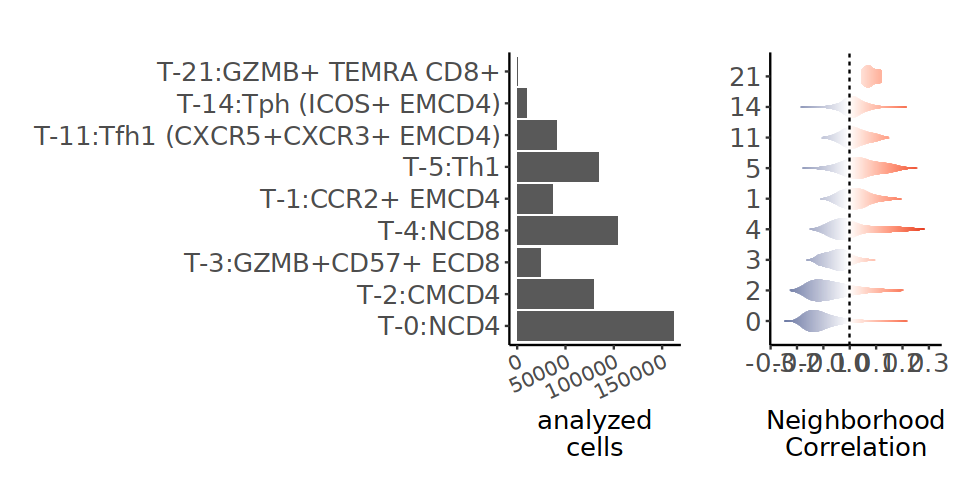

In [14]:

cor_pos = obj_sub@meta.data$cna_ncorrs_fdr05
cor_pos = cor_pos[cor_pos > 0]
# summary(cor_pos)
cor_neg = obj_sub@meta.data$cna_ncorrs_fdr05
cor_neg = cor_neg[cor_neg < 0]
# summary(cor_neg)

new_ord = c("0","2","3","4","1","5","11","14","21")

p <- cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::filter(res_cell %in% new_ord) %>%
    dplyr::mutate(res_cell = factor(res_cell,levels=new_ord)) %>%
    ggplot(aes(x=res_cell, y=cna_ncorrs)) + 
    geom_violin(trim=TRUE, scale = "width")

mywidth <- .35 # bit of trial and error
# This is all you need for the fill: 
vl_fill <- data.frame(ggplot_build(p)$data) %>%
  mutate(xnew = x- mywidth*violinwidth, xend = x+ mywidth*violinwidth) 

# Bit convoluted for the outline, need to be rearranged: the order matters
vl_poly <- 
  vl_fill %>% 
  select(xnew, xend, y, group) %>%
  tidyr::pivot_longer(-c(y, group), names_to = "oldx", values_to = "x") %>% 
  arrange(y) %>%
  split(., .$oldx) %>%
  map(., function(x) {
    if(all(x$oldx == "xnew")) x <- arrange(x, plyr::desc(y))
    x
    }) %>%
  bind_rows()


if (length(cor_pos)!=0 & length(cor_neg)!=0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=new_ord, breaks=1:length(unique(new_ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_pos), max(cor_neg)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +   
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_text(size =15),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)!=0 & length(cor_neg)==0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=new_ord, breaks=1:length(unique(new_ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_pos)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_text(size =15),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)==0 & length(cor_neg)!=0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=new_ord, breaks=1:length(unique(new_ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_neg)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_text(size =15),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)==0 & length(cor_neg)==0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=new_ord, breaks=1:length(unique(new_ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_text(size =15),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  }

# MASC: Mixed-effects association testing for single cells
## Sci Transl Med. 2018 Oct 17;10(463):eaaq0305.

masc = readRDS(file = paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ValiData/T_MASC_Control_AtRiskRA_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_symphony.rds"))
masc

g3 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
    dplyr::mutate(col = dplyr::case_when(
      CIupper < 1 ~ '#3C5488FF',
      CIlower > 1 ~ '#DC0000FF',
      TRUE ~ "lightgray"),
                 CIupper = ifelse(CIupper>100 & model.pvalue>0.05, 1, CIupper),
                 CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
                 OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cluster = gsub("cluster","",cluster)) %>%
  dplyr::filter(cluster %in% new_ord) %>%
  dplyr::mutate(cluster = factor(cluster,levels=new_ord)) %>%
  ggplot(., aes(y=cluster, x=size)) + 
  geom_bar(stat = "identity", position=position_dodge()) + 
  scale_y_discrete(labels=paste0("T-",
                                 cluster_df %>%
                                   dplyr::filter(cluster %in% as.character(new_ord)) %>%
                                   magrittr::set_rownames(.$cluster) %>%
                                   .[as.character(new_ord),] %>% .$cluster,
                                 ":",
                                 cluster_df %>%
                                   dplyr::filter(cluster %in% as.character(new_ord)) %>%
                                   magrittr::set_rownames(.$cluster) %>%
                                   .[as.character(new_ord),] %>% .$clu_name)
  ) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 12, angle = 25, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "analyzed\ncells")
options(repr.plot.height = 4, repr.plot.width = 8)
(g3+g1)+plot_layout(widths = c(1,1))


In [17]:
# load original data
umap_res_orig <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
# remove clusters less than cut off
min_cell_cluster = 30
clu_orig = umap_res_orig %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
clu_logi_orig = umap_res_orig$res_cell %in% clu_orig
umap_res_orig = umap_res_orig[clu_logi_orig,]

obj_orig = readRDS(paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/SeuratObj_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
obj_orig@meta.data$subject_id <- stringr::str_split(obj_orig@meta.data$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
                                    stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
                                    as.data.frame() %>%
                                    .[,1] %>%
                                    gsub("-","_",.)
meta_orig<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta_orig = merge(meta_orig,obj_orig@meta.data,by="subject_id")
meta_orig = meta_orig[order(match(meta_orig$subject_id, obj_orig@meta.data$subject_id)),]
all(meta_orig$subject_id == obj_orig@meta.data$subject_id)
obj_orig@meta.data$AtRisk = dplyr::case_when(
  meta_orig$AMP_Group == "FDR" & meta_orig$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  meta_orig$AMP_Group == "GP" & meta_orig$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  meta_orig$AMP_Group == "FDR" & meta_orig$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  meta_orig$AMP_Group == "GP" & meta_orig$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  obj_orig@meta.data$disease == "Control" ~ "Control",
  obj_orig@meta.data$disease == "RA" ~ "RA")
obj_orig@meta.data$disease = dplyr::case_when(
  obj_orig@meta.data$AtRisk == "FDR(+)/ACPA(+)" | obj_orig@meta.data$AtRisk == "FDR(-)/ACPA(+)" | obj_orig@meta.data$AtRisk == "FDR(+)/ACPA(-)" ~ "AtRiskRA",
  obj_orig@meta.data$AtRisk == "Control" | obj_orig@meta.data$AtRisk == "FDR(-)/ACPA(-)" ~ "Control",
  obj_orig@meta.data$AtRisk == "RA" ~ "RA")
obj_orig@meta.data$condition = obj_orig@meta.data$disease
obj_orig@meta.data$condition = factor(obj_orig@meta.data$condition, levels = c('Control', 'AtRiskRA', "RA"))

logi_orig = obj_orig$condition %in% c("Control","AtRiskRA")
obj_sub_orig = readRDS(paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/SeuratObj_Control_AtRiskRA_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
med_df_orig <- cbind(umap_res_orig[logi_orig,],obj_sub_orig@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::mutate(res_cell = factor(res_cell,levels=ord)) %>%
    dplyr::filter(res_cell %in% c("0","1","2","4","5","11","14")) %>%
    dplyr::group_by(res_cell) %>%
  dplyr::summarize(median=median(cna_ncorrs))
med_df_orig


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] TRUE

res_cell median      
1 14        0.077704989
2 11        0.020163782
3 5         0.001147668
4 4        -0.140310132
5 2        -0.133790903
6 1         0.111306940
7 0        -0.136436507

`summarise()` has grouped output by 'res_cell', 'cna_ncorrs_dir'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'res_cell', 'cna_ncorrs_dir'. You can
override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


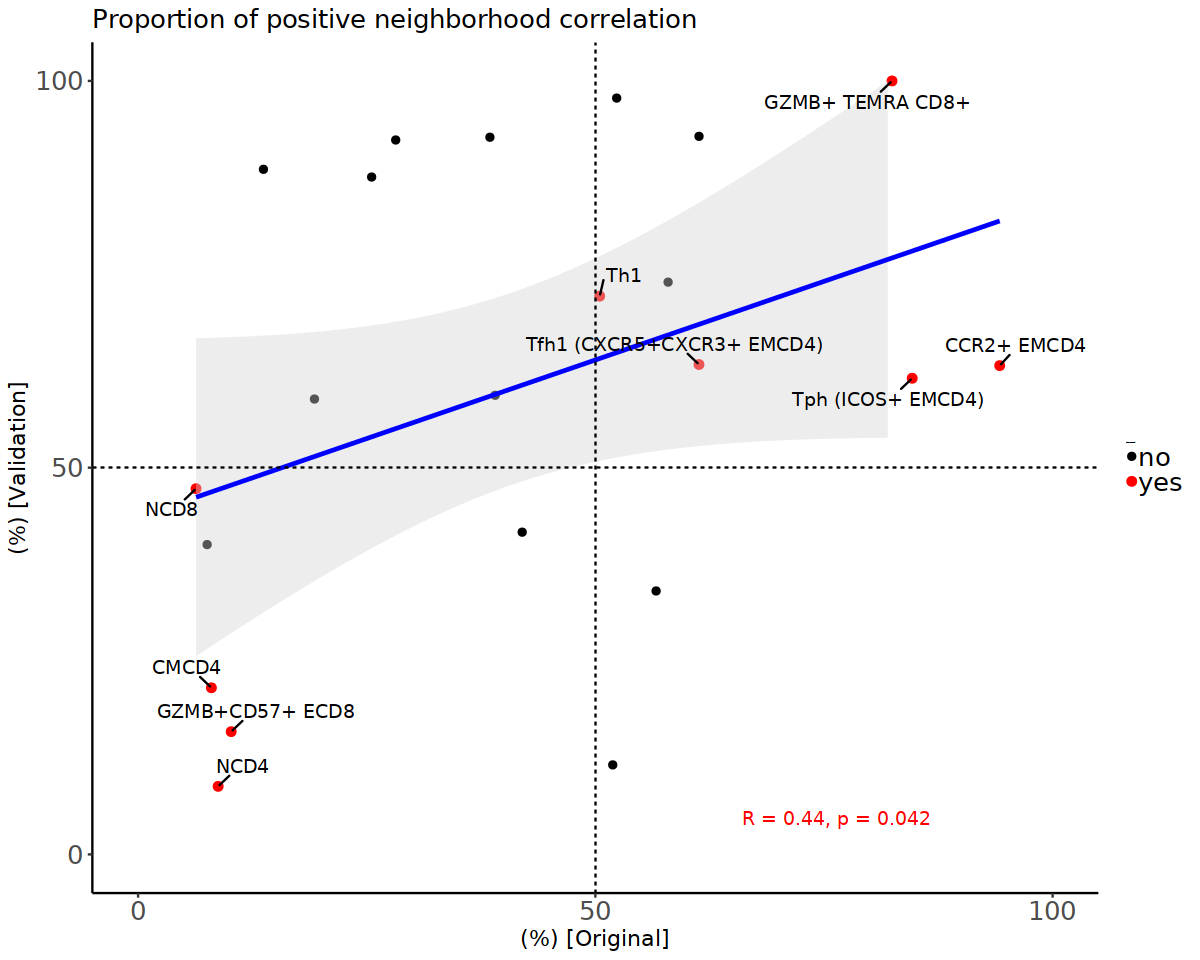

In [19]:
data_cor = merge(
  cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::mutate(cna_ncorrs_dir = ifelse(cna_ncorrs>0, "pos","neg")) %>%
    dplyr::group_by(res_cell) %>%
    dplyr::mutate(total = dplyr::n()) %>%
    dplyr::group_by(res_cell,cna_ncorrs_dir) %>%
    dplyr::summarize(proportion_validate = 100*dplyr::n()/total) %>%
    dplyr::filter(cna_ncorrs_dir == "pos") %>%
    unique() ,
  cbind(umap_res_orig[logi_orig,],obj_sub_orig@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::mutate(cna_ncorrs_dir = ifelse(cna_ncorrs>0, "pos","neg")) %>%
    dplyr::group_by(res_cell) %>%
    dplyr::mutate(total = dplyr::n()) %>%
    dplyr::group_by(res_cell,cna_ncorrs_dir) %>%
    dplyr::summarize(proportion_original = 100*dplyr::n()/total) %>%
    dplyr::filter(cna_ncorrs_dir == "pos") %>%
    unique(),
  by="res_cell",suffix=c("_Validation","_Original")) %>%
  merge(.,
        cluster_df,
        by.x="res_cell", by.y= "cluster") %>%
  dplyr::mutate(label = ifelse(res_cell %in% c("0","1","2","3","4","5","11","14","21"), TRUE, FALSE) ,
                interested = ifelse(res_cell %in% c("0","1","2","3","4","5","11","14","21"), "yes", "no") )


options(repr.plot.height = 8, repr.plot.width = 10)

ggpubr::ggscatter(data_cor, x = paste0("proportion_original"), y = paste0("proportion_validate"),
                    color = "interested", shape = "interested", size = 2, alpha = 1, # Points color, shape and size
                    add = "reg.line",  # Add regressin line
                    add.params = list(color = "blue", fill = "lightgray"), # Customize reg. line
                    conf.int = TRUE
  ) +
  ggpubr::stat_cor(color = "red", label.x = 66,label.y.npc = "bottom", method = "spearman") +
  scale_color_manual(values=c("yes" = "red", "no" = "black")) +
  scale_shape_manual(values=c("yes" = 19, "no" = 16)) +
  geom_text_repel(data = data_cor[data_cor$label,],
                  aes(label = clu_name),
                  min.segment.length = 0, 
                  seed = 42, 
                  box.padding = 0.5,
                  max.overlaps=Inf) +
  geom_vline(xintercept=50, linetype='dashed', color='black') +
  geom_hline(yintercept=50, linetype='dashed', color='black') +
  scale_x_continuous(breaks=c(0,50,100), limits=c(0,100)) +
  scale_y_continuous(breaks=c(0,50,100), limits=c(0,100)) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=13),
        axis.title.y = element_text(size =13),
        axis.text.y = element_text(size =15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "Proportion of positive neighborhood correlation",
       y = paste0("(%) [Validation]"),
       x = paste0("(%) [Original]"))
